# CNS AP-axis VAE model

This notebook runs through the CNS analysis used in the VAE paper (ref: ).  

We use genes that were found to be differentially expressed and aim to understand how different groups of genes responded to PRC2 knockout.  

We do this by using a variational autoencoder (VAE).  

Our VAE model uses a three layer network, and as input data, takes in the normalised expression matrix including the wild type and response to Eed-cKO.  


### Sections:

#### Part 1: VAE setup
    1) Function setup
    2) Read in processed dataframe and organise this
    3) Build VAE model
    
#### Part 2: VAE as a ranking method
    4) Setup data for visualisations
    5) Quantify separability of latent space
    6) Save VAE ranks to csv to run GSEA in R
    
#### Part 3: VAE to identify coordinating groups of genes
    6) Build gene groups using VAE latent space
    7) Save gene groups for ORA in R
    9) Inspecting the groups in context of chromHMM annotations 
    10) Inspect groups in terms of annotations for Epi paper
    

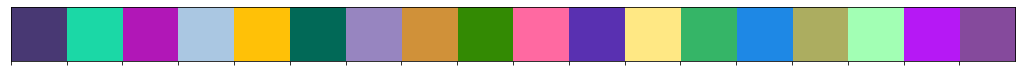

In [1]:
"""
--------------------------------------------------------
                     Imports
--------------------------------------------------------
"""

import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib_venn import venn3
from sklearn.decomposition import PCA
from scipy import stats
from sciviso import *
from sciutil import SciUtil
from scivae import Vis as VVis
import string
u = SciUtil()

module_path = os.path.abspath(os.path.join(''))
sys.path.append(module_path)


"""
--------------------------------------------------------
                     Global variables
--------------------------------------------------------
"""
date = '20210217'

gene_id = 'entrezgene_id'
gene_name = 'external_gene_name'

sci_colour = ['#483873', '#1BD8A6', '#B117B7', '#AAC7E2', '#FFC107', '#016957', '#9785C0', 
             '#D09139', '#338A03', '#FF69A1', '#5930B1', '#FFE884', '#35B567', '#1E88E5', 
             '#ACAD60', '#A2FFB4', '#B618F5', '#854A9C']

hist_colour = '#483873'

e11_colour = '#BEC0C2'
e13_colour = '#A7A9AC'
e15_colour = '#7D7E81'
e18_colour = '#58595B'

fb_colour = '#ffbf80'
mb_colour = '#ff8c1a'
hb_colour = '#b35900'
sc_colour = '#663300'
fb_color = '#ffbf80'
mb_color = '#ff8c1a'
hb_color = '#b35900'
sc_color = '#663300'

h3k36me3_colour = '#CEF471'
h3k27me3_colour = '#9F71F4'
h3k4me3_colour = '#9F00FA'
h3k4me2_colour = '#5930B1'
h3k4me1_colour = '#FFE884'
h3k27ac_colour = '#35B567'
h3k9me3_colour = '#1E88E5'
h3k9ac_colour = '#A2FFB4'
           
wt_colour = '#AADFF1'
ko_colour = '#A53736'

sci_colour = ['#483873', '#1BD8A6', '#B117B7', '#AAC7E2', '#FFC107', '#016957', '#9785C0', 
             '#D09139', '#338A03', '#FF69A1', '#5930B1', '#FFE884', '#35B567', '#1E88E5', 
             '#ACAD60', '#A2FFB4', '#B618F5', '#854A9C']
sns.palplot(sci_colour)
sns.color_palette(sci_colour)

project_name = '3_node_consistent_genes'

data_dir = '../../data/'
r_dir = f'{data_dir}results/deseq2/'
fig_dir = f'../../figures/{project_name}/vae/'
output_dir = f'{data_dir}results/{project_name}/vae/'
input_dir = f'{data_dir}results/prelim/'
rna_dir = f'{input_dir}feature-counts_04052020/'
supp_dir = f'{data_dir}input/supps/'
logging_dir = 'logging/'
ora_dir = '../../data/results/3_node_consistent_genes/functional/'

grey = '#bdbdbd'
hist_cmap = 'Greens'
rna_cmap = 'Purples'
div_cmap = 'seismic'

experiment_name = project_name
from_saved = True  # Load from a saved VAE

## 1) Function setup

Here we just initialise the functions that will be used in the notebook.

In [2]:
"""
--------------------------------------------------------
                     Colour/style getters
--------------------------------------------------------
"""
def get_time_colour(c):
    if '11' in c or '10' in c:
        return e11_colour
    elif '13' in c or '12' in c:
        return e13_colour
    elif '15' in c or '14' in c:
        return e15_colour
    elif '18' in c or '16' in c:
        return e18_colour
    return '#FFFFFF'

def get_tissue_colour(c):
    if 'sc' in c or 'spinal' in c:
        return sc_colour
    elif 'hb' in c or 'hindbrain' in c:
        return hb_colour
    elif 'fb' in c or 'forebrain' in c:
        return fb_colour
    elif 'mb' in c or 'midbrain' in c:
        return mb_colour
    return '#FFFFFF'

def get_cond_colour(c):
    if 'ko' in c:
        return ko_colour
    elif 'wt' in c:
        return wt_colour
    return '#FFFFFF'

def get_mark_colour(c):
    if '36me3' in c:
        return h3k36me3_colour
    elif '27me3' in c:
        return h3k27me3_colour
    elif 'K4me3' in c:
        return h3k4me3_colour
    elif 'K4me2' in c:
        return h3k4me2_colour
    elif 'K4me1' in c:
        return h3k4me1_colour
    elif '27ac' in c:
        return h3k27ac_colour
    elif 'K9me3' in c:
        return h3k9me3_colour
    elif 'K9ac' in c:
        return h3k9ac_colour
    return '#FFFFFF'

"""
--------------------------------------------------------
                     Plotting
--------------------------------------------------------
"""
def pplot():
    return
        
def cplot():
    return
    
def save_fig(title):
    plt.savefig(f'{fig_dir}{title.replace(" ", "-")}_{experiment_name}_{date}.svg')
    
"""
--------------------------------------------------------
                     Heatmap and vis function
--------------------------------------------------------
"""
def plot_gene_heatmap(df, fb_genes, mb_genes, hb_genes, sc_genes, 
                      input_cols, vae_data, vae, gene_name, mark, method='input', 
                      title="", merge_reps=False, input_col_ids=None, cmap='', genes=None, 
                      values=None, v_min=None, v_max=None):
    brain_genes = []
    colours = []
    gene_idxs = []
    genes = genes if genes is not None else df[gene_name].values
    for g1 in fb_genes:
        for i, g2 in enumerate(genes):
            if g1 == g2:
                brain_genes.append(g1)
                colours.append(fb_colour)
                gene_idxs.append(i)
                break
    for g1 in mb_genes:
        for i, g2 in enumerate(genes):
            if g1 == g2:
                brain_genes.append(g1)
                colours.append(mb_colour)
                gene_idxs.append(i)
                break
            i += 1
    for g1 in hb_genes:
        for i, g2 in enumerate(genes):
            if g1 == g2:
                brain_genes.append(g1)
                colours.append(hb_colour)
                gene_idxs.append(i)
                break

    for g1 in sc_genes:
        for i, g2 in enumerate(genes):
            if g1 == g2:
                brain_genes.append(g1)
                colours.append(sc_colour)
                gene_idxs.append(i)
                break
    heatmap_df = pd.DataFrame()
    heatmap_df[gene_name] = brain_genes

    if method == 'decoding':
        deocded = vae.decoder.predict(vae_data)
        deocded = scaler.fit_transform(deocded)
        cols_idxs = []
        for i, c in enumerate(df.columns):
            if c in input_cols:
                cols_idxs.append(i)

        val_df = pd.DataFrame(deocded[gene_idxs])
        vals = val_df[cols_idxs].values
    elif method == 'input':
        vals = df[input_cols].values[gene_idxs]
    else:
        vals = vae_data[gene_idxs]
    vals = values[gene_idxs] if values is not None else vals

    cols = []
    for i, c in enumerate(input_cols):
        if input_col_ids is not None:
            if i in input_col_ids:
                heatmap_df[c] = np.nan_to_num(vals[:,i])
                cols.append(c)
        else:
            heatmap_df[c] = np.nan_to_num(vals[:,i])
            cols.append(c)
    heatmap_cols = cols

    cols = []
    col_colours = []
    cond_colours = []
    tissue_colours = []
    time_colours = []
    for c in heatmap_df.columns:
        if 'wt' in c or 'ko' in c:
            cols.append(c)
            time_colours.append(get_time_colour(c))
            tissue_colours.append(get_tissue_colour(c))
            cond_colours.append(get_cond_colour(c))
        if mark in c and hist_metric in c:
            time_colours.append(get_time_colour(c))
            tissue_colours.append(get_tissue_colour(c))
            cond_colours.append('white')
            cols.append(c)
        elif 'log2' in c:
            time_colours.append(get_time_colour(c))
            tissue_colours.append(get_tissue_colour(c))
            cond_colours.append(get_mark_colour(c))
            cols.append(c)
    col_colours = [cond_colours, tissue_colours, time_colours]

    # Now plot the rnaseq response as a heatmap
    vmin = None
    vmax = None
    if cmap == hist_cmap or cmap == rna_cmap:
        vmin = 0
        vmax = 10
    elif cmap == div_cmap:
        vmin = -3
        vmax = 3
    if v_min != None:
        vmin = v_min
    if v_max != None:
        vmax = v_max
    heatmap = Heatmap(heatmap_df, heatmap_cols, gene_name,
                      title=title, cluster_cols=False, cluster_rows=False, vmin=vmin, vmax=vmax,
                      figsize=(3, 5),
                      cmap=cmap)
    heatmap.cmap = cmap
    heatmap.plot()
    pplot()
    plt.title(title)
    save_fig(title)
    plt.show()


## 2) Read in processed dataframe

Here we import the results from running the AP-axis dataset generation script.  

This used the output from differential analysis and also annotated histone marks to genes.  

We merge replicates to make the visualisations nicer.

In [3]:
df_all = pd.read_csv(f'{input_dir}df-all_epi-2500_20210124.csv')
df_training = pd.read_csv(f'{input_dir}df-consistent_epi-2500_20210124.csv')
df_sig = pd.read_csv(f'{input_dir}df-significant_epi-2500_20210124.csv')

"""
--------------------------------------------------------
                    Merge replicates for vis
--------------------------------------------------------
"""

# Smooth out the columns in the data frame i.e. for the clones we only put in the mean of the two replicates
u.dp(['Merging consistently affected gene replicates'])
cols_to_merge = [c for c in df_training.columns if 'wt' in c or 'ko' in c]
i = 0
while(i < len(cols_to_merge)):
    df_training[f'{cols_to_merge[i][:-1]}_merged-rep'] = 0.5 * (df_training[cols_to_merge[i]].values +
                                                                df_training[cols_to_merge[i + 1]].values)
    print("merged", cols_to_merge[i], cols_to_merge[i + 1])
    i += 2
    
"""
--------------------------------------------------------
                     Merge sig. Dataset
--------------------------------------------------------
"""
u.dp(['Merging sig. affected gene replicates'])
cols_to_merge = [c for c in df_sig.columns if 'wt' in c or 'ko' in c]
i = 0
while(i < len(cols_to_merge)):
    df_sig[f'{cols_to_merge[i][:-1]}_merged-rep'] = 0.5 * (df_sig[cols_to_merge[i]].values +
                                                                df_sig[cols_to_merge[i + 1]].values)
    print("merged", cols_to_merge[i], cols_to_merge[i + 1])
    i += 2
    
"""
--------------------------------------------------------
                     Merge all dataset
--------------------------------------------------------
"""
u.dp(['Merging whole dataset'])
cols_to_merge = [c for c in df_all.columns if 'wt' in c or 'ko' in c]
i = 0
while(i < len(cols_to_merge)):
    df_all[f'{cols_to_merge[i][:-1]}_merged-rep'] = 0.5 * (df_all[cols_to_merge[i]].values +
                                                                df_all[cols_to_merge[i + 1]].values)
    print("merged", cols_to_merge[i], cols_to_merge[i + 1])
    i += 2


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


--------------------------------------------------------------------------------
                 Merging consistently affected gene replicates	                 
--------------------------------------------------------------------------------
merged wt11fb1 wt11fb2
merged wt13fb1 wt13fb2
merged wt15fb1 wt15fb2
merged wt18fb1 wt18fb2
merged wt11mb1 wt11mb2
merged wt13mb1 wt13mb2
merged wt15mb1 wt15mb2
merged wt18mb1 wt18mb2
merged wt11hb1 wt11hb2
merged wt13hb1 wt13hb2
merged wt15hb1 wt15hb2
merged wt18hb1 wt18hb2
merged wt11sc1 wt11sc2
merged wt13sc1 wt13sc2
merged wt15sc1 wt15sc2
merged wt18sc1 wt18sc2
merged ko11fb1 ko11fb2
merged ko13fb1 ko13fb2
merged ko15fb1 ko15fb2
merged ko18fb1 ko18fb2
merged ko11mb1 ko11mb2
merged ko13mb1 ko13mb2
merged ko15mb1 ko15mb2
merged ko18mb1 ko18mb2
merged ko11hb1 ko11hb2
merged ko13hb1 ko13hb2
merged ko15hb1 ko15hb2
merged ko18hb1 ko18hb2
merged ko11sc1 ko11sc2
merged ko13sc1 ko13sc2
merged ko15sc1 ko15sc2
merged ko18sc1 ko18sc2
---------------------

In [4]:
df_all_genes = df_all[gene_name].values
caff_genes = df_training[gene_name].values
sig_genes = df_sig[gene_name].values

gene_markers_sep = [['Emx1', 'Eomes', 'Tbr1', 'Foxg1', 'Lhx6'], 
                    ['En1', 'En2', 'Lmx1a', 'Bhlhe23', 'Sall4'], 
                    ['Hoxb1', 'Krox20', 'Fev', 'Hoxd3', 'Phox2b'],
                    ['Hoxd8', 'Hoxd9', 'Hoxd10', 'Hoxd11', 'Hoxd12', 'Hoxd13', 'Hoxa7', 'Hoxa9', 'Hoxa10', 'Hoxa11', 
                    'Hoxa13', 'Hoxb9', 'Hoxb13',  'Hoxc8', 'Hoxc9', 'Hoxc10', 'Hoxc11', 'Hoxc12', 'Hoxc13'],
                    ['Ccna1', 'Ccna2', 'Ccnd1', 'Ccnd2', 'Ccnd3', 'Ccne1', 'Ccne2', 'Cdc25a', 
                    'Cdc25b', 'Cdc25c', 'E2f1', 'E2f2', 'E2f3', 'Mcm10', 'Mcm5', 'Mcm3', 'Mcm2', 'Cip2a'],
                    ['Cdkn1a', 'Cdkn1b', 'Cdkn1c', 'Cdkn2a', 'Cdkn2b', 'Cdkn2c', 'Cdkn2d'],
                    ['Sox2', 'Sox1', 'Sox3', 'Hes1', 'Hes5'],
                    ['Snap25', 'Syt1', 'Slc32a1','Slc17a6', 'Syn1'],
                    ['Cspg4', 'Aqp4', 'Slc6a11', 'Olig1', 'Igfbp3']]
u.dp(['Not affected markers'])
for gl in gene_markers_sep:
    for g in gl:
        if g in df_all_genes and g not in caff_genes and g not in sig_genes:
            print(g)

for gl in gene_markers_sep:
    for g in gl:
        if g in sig_genes and g not in caff_genes:
            u.dp([g])       
        elif g in caff_genes:
            u.err_p([g])
            

--------------------------------------------------------------------------------
                             Not affected markers	                              
--------------------------------------------------------------------------------
Hoxd12
--------------------------------------------------------------------------------
                                     Emx1	                                      
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                                     Eomes	                                     
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                                     Tbr1	                                      
--------------------------------------------------------------------------------
---------------------

## 3) Build VAE model

Since the VAEs are stochastic rather than deterministic we want to create our clusters based on a number of iterations.
We also are interested in how much the genes differ in various latent spaces.

In [5]:
from scivae import VAE

hist_metric = 'signal'
labels = df_training[gene_name].values


# -----------------------------------------------------------------------------------
#                         Set the input data space
# -----------------------------------------------------------------------------------
def get_input_data(df: pd.DataFrame, label_col: str):
    scaler = MinMaxScaler(copy=True)
    """ Here we define the data for the VAE we choose to log2 the signal """
    cols_bin = []
    tmp_df = pd.DataFrame()
    non_nan_df = df.copy()
    non_nan_df = non_nan_df.fillna(0)
    for c in df.columns:
        if 'H3K27me3' in c and 'signal' in c and 'brain' in c:
            v = np.log2(non_nan_df[c].values + 1)
            nn_min = np.nanmin(v)
            nn_max = np.nanmax(v)
            tmp_df[f'{c}_log2'] = (v-nn_min) / (nn_max - nn_min)
            cols_bin.append(f'{c}_log2')
        elif ('merged-rep' not in c) and ('log2FoldChange' in c or 'wt' in c or 'ko' in c): 
            cols_bin.append(c)
            v = non_nan_df[c].values
            nn_min = np.nanmin(v)
            nn_max = np.nanmax(v)
            tmp_df[c] = (v-nn_min) / (nn_max - nn_min)
    vae_values = tmp_df[cols_bin].values
    vae_values = np.nan_to_num(vae_values)
    tmp_df[label_col] = df[label_col].values
    return vae_values, tmp_df, df[label_col].values


In [6]:
# # -----------------------------------------------------------------------------------
# #                         Run a test to work out the best number of nodes
# # -----------------------------------------------------------------------------------
# vae_input_values, df_input, labels = get_input_data(df_training, gene_name)
# tsts = [1, 2, 3, 4, 6, 8, 16, 24]
# for i in tsts:
#     for j in range(0, 5):
#         config = {'loss': {'loss_type': 'mse', 'distance_metric': 'mmd', 'mmd_weight': 2.0}, 
#                   'encoding': {'layers': [{'num_nodes': 64, 'activation_fn': 'selu'}, 
#                                           {'num_nodes': 32, 'activation_fn': 'relu'}]}, 
#                   'decoding': {'layers': [{'num_nodes': 32, 'activation_fn': 'relu'},
#                                           {'num_nodes': 64, 'activation_fn': 'selu'}]}, 
#                   'latent': {'num_nodes': i}, 'optimiser': {'params': {}, 'name': 'adam'}}

#         vae_mse = VAE(vae_input_values, vae_input_values, labels, config, f'vae_num-nodes_{i}_rep_{j}')
#         vae_mse.encode('default', epochs=100, batch_size=50,
#                        logging_dir=logging_dir, logfile=f'run_num-nodes_{i}_rep_{j}.csv')

# # -----------------------------------------------------------------------------------
# #                         Plot results
# # -----------------------------------------------------------------------------------

# # Read in each of the csv's and then add a line for each one
# tsts = [1, 2, 3, 4, 6, 8, 16, 24]
# fig, ax = plt.subplots()
# labels = []
# for i, t in enumerate(tsts):
#     c = sci_colour[i]
#     print(c, i)
#     for j in range(0, 5):
#         d = pd.read_csv(f'{logging_dir}run_num-nodes_{t}_rep_{j}.csv')
#         print(f'{logging_dir}run_num-nodes_{t}_rep_{j}.csv')
#         ax.plot(d['epoch'].values, d['loss'].values, c=c, alpha=0.5)
#         label=f'{t} node(s)'
#         if label not in labels:
#             ax.plot(d['epoch'].values, d['val_loss'].values, c=c, alpha=0.8, label=label)
#             labels.append(label)
#         else:
#             ax.plot(d['epoch'].values, d['val_loss'].values, c=c, alpha=0.8)
        
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# axes = plt.gca()
# axes.set_ylim([0, 5])
# save_fig(f'node_num')
# plt.show()

In [7]:
from_saved

True

In [8]:
# -----------------------------------------------------------------------------------
#                         Based on the above, set the number of nodes
#                         1) Build non-linear VAE
#                         2) Build linear VAE
# -----------------------------------------------------------------------------------
num_nodes = 3
vae_input_values, df_input, labels = get_input_data(df_training, gene_name)

config = {'loss': {'loss_type': 'mse', 'distance_metric': 'mmd', 'mmd_weight': 1.0, 
                   'mmcd_method': 'k'}, 
                  'encoding': {'layers': [{'num_nodes': 64, 'activation_fn': 'selu'}, 
                                          {'num_nodes': 32, 'activation_fn': 'relu'}
                                          ]}, 
                  'decoding': {'layers': [
                                          {'num_nodes': 32, 'activation_fn': 'relu'},
                                          {'num_nodes': 64, 'activation_fn': 'selu'}]}, 
                  'latent': {'num_nodes': num_nodes}, 'optimiser': {'params': {}, 'name': 'adam'}}

vae_mse = VAE(vae_input_values, vae_input_values, labels, config, f'final')
if not from_saved:
    vae_mse.encode('default', epochs=250, batch_size=50,
                   logging_dir="final_vae_logs", logfile=f'final.csv')
    vae_mse.save() # save the VAE
    vae_mse.u.dp(["Saved VAE to current directory."])
else:
    vae_mse.u.dp(["Trying to load saved VAE..."])
    vae_mse.load()
    vae_mse.u.dp(["Loaded saved VAE :) "])

df = df_training.copy()

# Encode the values using the VAE
scaler = MinMaxScaler(copy=True)
scaled_vals = scaler.fit_transform(vae_input_values)
vae_data = vae_mse.encode_new_data(scaled_vals)


None
--------------------------------------------------------------------------------
                          Trying to load saved VAE...	                          
--------------------------------------------------------------------------------
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
default_input (InputLayer)      [(None, 97)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           6272        default_input[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           2080        dense[0][0]                      
__________________________________________

## 4) Setup data for visualisations

Here we setup the data and summarise key features, for example calcualting the median values. 

We do this so we can easily access these later.

In [9]:
# -----------------------------------------------------------------------------------
#                         Data setup for Vis
# -----------------------------------------------------------------------------------

hist_metric = 'signal'
input_cols = list(df_input.columns)


def get_median(df, mark, time="", tissue="brain"):
    cols = []
    for c in df.columns:
        if tissue in c and mark in c and hist_metric in c and time in c and 'median' not in c:
            cols.append(c)
    # get nan median
    vals = np.nanmedian(df[cols].values, axis=1)
    
    return np.nan_to_num(vals)

marks = ['H3K27me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K27ac', 'H3K9me3', 'H3K36me3', 'H3K9ac']

# Get the median over all time points and all brain tissues
for m in marks:
    df[f'{m}'] = get_median(df, m, time="", tissue="brain")
    
times = ['10.5', '11.5', '12.5', '13.5', '14.5', '15.5', '16.5']
for m in marks:
    for e in times:
        df[f'median_brain_{e}_signal_{m}'] = get_median(df, m, time=e, tissue="brain")
    
tissues = ['hindbrain', 'midbrain', 'forebrain']
for m in marks:
    for e in times:
        for t in tissues:
            df[f'median_{t}_{e}_signal_{m}'] = get_median(df, m, time=e, tissue=t)


df['mean_wt'] = np.mean(df[[c for c in df.columns if 'wt' in c]].values, axis=1)
df['mean_ko'] = np.mean(df[[c for c in df.columns if 'ko' in c]].values, axis=1)
df['mean_ko-wt'] = df['mean_ko'].values - df['mean_wt'].values

# Add in the VAE columns 
for v in range(0, len(vae_data[0])):
    df[f'VAE{v}'] = vae_data[:, v]

# Rename/add some columns just to make figs easier
df['Log2FC FB'] = df['log2FoldChange_fb'].values
df['Log2FC MB'] = df['log2FoldChange_mb'].values
df['Log2FC HB'] = df['log2FoldChange_hb'].values
df['Log2FC SC'] = df['log2FoldChange_sc'].values
df['Log2FC A11'] = df['log2FoldChange_a11'].values
df['Log2FC A13'] = df['log2FoldChange_a13'].values
df['Log2FC A15'] = df['log2FoldChange_a15'].values
df['Log2FC A18'] = df['log2FoldChange_a18'].values
df['Log2FC P11'] = df['log2FoldChange_p11'].values
df['Log2FC P13'] = df['log2FoldChange_p13'].values
df['Log2FC P15'] = df['log2FoldChange_p15'].values
df['Log2FC P18'] = df['log2FoldChange_p18'].values

all_cols = [
    'H3K9me3',
    'H3K4me1', 
    'H3K4me2', 
    'H3K4me3', 
    'H3K27ac',
    'H3K36me3', 
    'H3K9ac',
    'mean_wt',
    'mean_ko',
    'mean_ko-wt',
    'H3K27me3',
    'Log2FC FB',
    'Log2FC MB',
    'Log2FC HB',
    'Log2FC SC',
    'VAE0',
    'VAE1',
    'VAE2',
    'Log2FC A11',
    'Log2FC A13',
    'Log2FC A15',
    'Log2FC A18',
    'Log2FC P11',
    'Log2FC P13',
    'Log2FC P15',
    'Log2FC P18'
]
unobserved_cols = [
    'H3K9me3',
    'H3K4me1', 
    'H3K4me2', 
    'H3K4me3', 
    'H3K27ac',
    'H3K36me3', 
    'H3K9ac',
    'mean_wt',
    'mean_ko',
    'mean_ko-wt'
]

observed_cols = [
    'H3K4me1', 
    'H3K4me2', 
    'H3K4me3', 
    'H3K27ac',
    'H3K36me3', 
    'H3K27me3',
    'Log2FC FB',
    'Log2FC MB',
    'Log2FC HB',
    'Log2FC SC',
    'VAE0',
    'VAE1',
    'VAE2'
]

hist_cols = [
    'H3K9me3',
    'H3K4me1', 
    'H3K4me2', 
    'H3K4me3', 
    'H3K27ac',
    'H3K36me3', 
    'H3K27me3',
    'H3K9ac'
]

div_cols = [
    'Log2FC FB',
    'Log2FC MB',
    'Log2FC HB',
    'Log2FC SC',
    'Log2FC A11',
    'Log2FC A13',
    'Log2FC A15',
    'Log2FC A18',
    'Log2FC P11',
    'Log2FC P13',
    'Log2FC P15',
    'Log2FC P18',
]

raw_cols = [
    'mean_wt',
    'mean_ko'
]
vae_cols = observed_cols
df_unobserved = df[unobserved_cols]
df_observed = df[observed_cols]
observed_dict = {}

for c in observed_cols:
    observed_dict[c] = df_observed[c].values
unobserved_dict = {}
for c in unobserved_cols:
    unobserved_dict[c] = df_unobserved[c].values
    

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


## 5. Plots for Figure 1

- Figure I: The gene heatmaps for select spatial marker genes
- Figure K: The gene heatmaps for sox genes normalised to gene expression level
- Suppl. Figure with all Hox genes
- Figure J: Line plots of the larger marker gene lists 

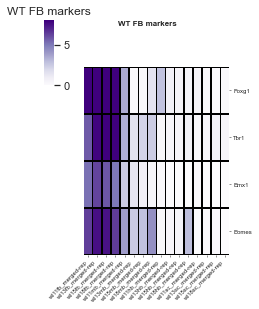

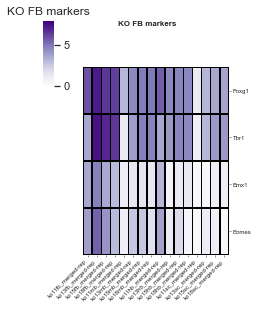

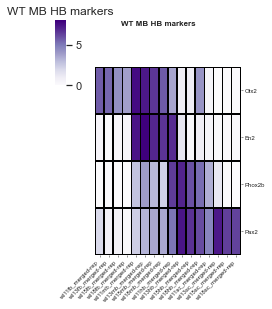

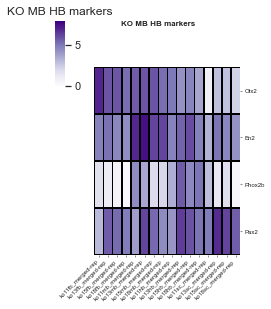

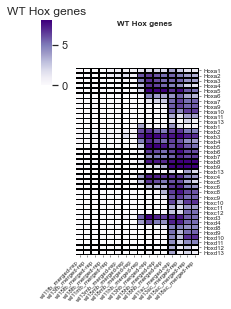

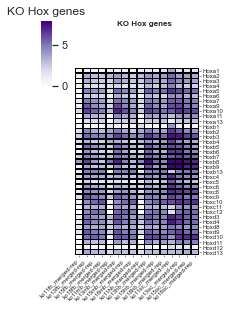

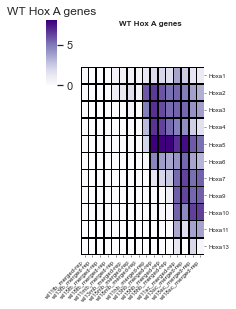

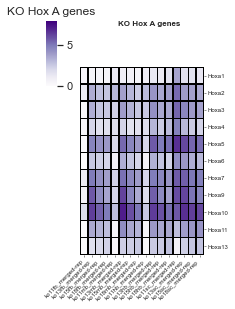

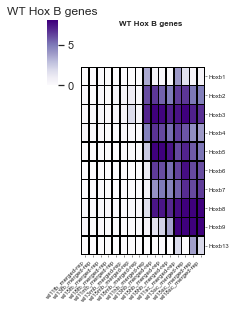

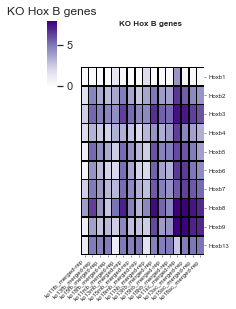

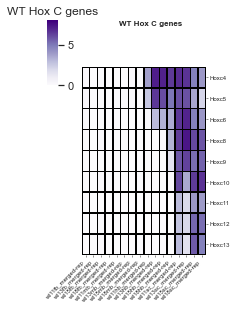

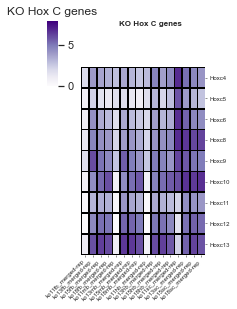

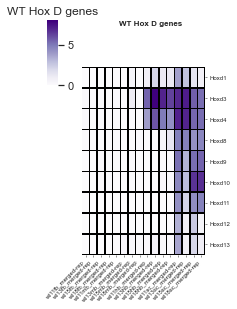

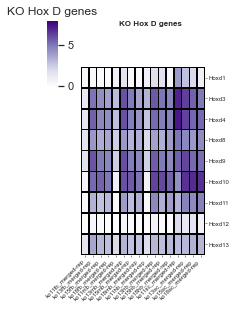

In [10]:
all_vae_data = np.copy(vae_data)
vae_data = all_vae_data[:, 0:3]
vae_vis = VVis(vae_mse, u, None)
div_cmap = 'seismic'
input_cols = [c for c in df_input.columns if c != gene_name]

merged_cols = [c for c in df.columns if "merged" in c]
# Also do the main markers
fb_genes = ['Foxg1', 'Tbr1', 'Emx1', 'Eomes']
mb_genes = ['Otx2', 'En2', 'Phox2b', 'Pax2']
hb_genes = ['Hoxd3', 'Pax2']
sc_genes = [ 'Hoxb9', 'Hoxc9', 'Hoxd9']
all_hox_genes = [
    'Hoxa1',
    'Hoxa2',
    'Hoxa3',
    'Hoxa4',
    'Hoxa5',
    'Hoxa6',
    'Hoxa7',
    'Hoxa8', # N CS
    'Hoxa9',
    'Hoxa10',
    'Hoxa11',
    'Hoxa12',  # N CS
    'Hoxa13',
    
    'Hoxb1',
    'Hoxb2',
    'Hoxb3',
    'Hoxb4',
    'Hoxb5',
    'Hoxb6',
    'Hoxb7',
    'Hoxb8',
    'Hoxb9',
    'Hoxb10'
    'Hoxb11',
    'Hoxb12',
    'Hoxb13',

    'Hoxc1', # N CS
    'Hoxc2', # N CS
    'Hoxc3', # N CS
    'Hoxc4',
    'Hoxc5',
    'Hoxc6',
    'Hoxc7',
    'Hoxc8',
    'Hoxc9',
    'Hoxc10',
    'Hoxc11',
    'Hoxc12',
    'Hoxc13'

    'Hoxd1', # N CS
    'Hoxd2', # N CS
    'Hoxd3',
    'Hoxd4',
    'Hoxd5', # N CS
    'Hoxd6',# N CS
    'Hoxd7',# N CS
    'Hoxd8',
    'Hoxd9',
    'Hoxd10',
    'Hoxd11',
    'Hoxd12', # N CS
    'Hoxd13'
 ]
sox_genes = ['Sox1', 'Sox2', 'Sox3']

# -----------------------------------------------------------------------------------
#                         Figure I 
# -----------------------------------------------------------------------------------
wt_merged_cols = [c for c in merged_cols if 'wt' in c]
plot_gene_heatmap(df, fb_genes, [], [], [], 
                  wt_merged_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='input', cmap=rna_cmap, title='WT FB markers',
                 v_min=0, v_max=8)
ko_merged_cols = [c for c in merged_cols if 'ko' in c]
plot_gene_heatmap(df, fb_genes, [], [], [], 
                  ko_merged_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='input', cmap=rna_cmap, title='KO FB markers', 
                 v_min=0, v_max=8)
wt_merged_cols = [c for c in merged_cols if 'wt' in c]
plot_gene_heatmap(df, [], mb_genes, [], [], 
                  wt_merged_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='input', cmap=rna_cmap, title='WT MB HB markers',
                 v_min=0, v_max=8)
ko_merged_cols = [c for c in merged_cols if 'ko' in c]
plot_gene_heatmap(df, [], mb_genes, [], [], 
                  ko_merged_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='input', cmap=rna_cmap, title='KO MB HB markers', 
                 v_min=0, v_max=8)
# -----------------------------------------------------------------------------------
#                         Figure I. Suppl All Hoxs 
# -----------------------------------------------------------------------------------
wt_merged_cols = [c for c in merged_cols if 'wt' in c]
plot_gene_heatmap(df_all, [], [], [], all_hox_genes, 
                  wt_merged_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='input', cmap=rna_cmap, title='WT Hox genes', v_min=0, v_max=8)
ko_merged_cols = [c for c in merged_cols if 'ko' in c]
plot_gene_heatmap(df_all, [], [], [], all_hox_genes, 
                  ko_merged_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='input', cmap=rna_cmap, title='KO Hox genes', v_min=0, v_max=8)

hox_a = [
    'Hoxa1',
    'Hoxa2',
    'Hoxa3',
    'Hoxa4',
    'Hoxa5',
    'Hoxa6',
    'Hoxa7',
    'Hoxa8', # N CS
    'Hoxa9',
    'Hoxa10',
    'Hoxa11',
    'Hoxa12',  # N CS
    'Hoxa13']
hox_b = [
    'Hoxb1',
    'Hoxb2',
    'Hoxb3',
    'Hoxb4',
    'Hoxb5',
    'Hoxb6',
    'Hoxb7',
    'Hoxb8',
    'Hoxb9',
    'Hoxb10'
    'Hoxb11',
    'Hoxb12',
    'Hoxb13']

hox_c = [
    'Hoxc1', # N CS
    'Hoxc2', # N CS
    'Hoxc3', # N CS
    'Hoxc4',
    'Hoxc5',
    'Hoxc6',
    'Hoxc7',
    'Hoxc8',
    'Hoxc9',
    'Hoxc10',
    'Hoxc11',
    'Hoxc12',
    'Hoxc13']
hox_d = [
    'Hoxd1', # N CS
    'Hoxd2', # N CS
    'Hoxd3',
    'Hoxd4',
    'Hoxd5', # N CS
    'Hoxd6',# N CS
    'Hoxd7',# N CS
    'Hoxd8',
    'Hoxd9',
    'Hoxd10',
    'Hoxd11',
    'Hoxd12', # N CS
    'Hoxd13'
 ]

wt_merged_cols = [c for c in merged_cols if 'wt' in c]
plot_gene_heatmap(df_all, [], [], [], hox_a, 
                  wt_merged_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='input', cmap=rna_cmap, title='WT Hox A genes', v_min=0, v_max=8)
ko_merged_cols = [c for c in merged_cols if 'ko' in c]
plot_gene_heatmap(df_all, [], [], [], hox_a, 
                  ko_merged_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='input', cmap=rna_cmap, title='KO Hox A genes', v_min=0, v_max=8)

wt_merged_cols = [c for c in merged_cols if 'wt' in c]
plot_gene_heatmap(df_all, [], [], [], hox_b, 
                  wt_merged_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='input', cmap=rna_cmap, title='WT Hox B genes', v_min=0, v_max=8)
ko_merged_cols = [c for c in merged_cols if 'ko' in c]
plot_gene_heatmap(df_all, [], [], [], hox_b, 
                  ko_merged_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='input', cmap=rna_cmap, title='KO Hox B genes', v_min=0, v_max=8)

wt_merged_cols = [c for c in merged_cols if 'wt' in c]
plot_gene_heatmap(df_all, [], [], [], hox_c, 
                  wt_merged_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='input', cmap=rna_cmap, title='WT Hox C genes', v_min=0, v_max=8)
ko_merged_cols = [c for c in merged_cols if 'ko' in c]
plot_gene_heatmap(df_all, [], [], [], hox_c, 
                  ko_merged_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='input', cmap=rna_cmap, title='KO Hox C genes', v_min=0, v_max=8)

wt_merged_cols = [c for c in merged_cols if 'wt' in c]
plot_gene_heatmap(df_all, [], [], [], hox_d, 
                  wt_merged_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='input', cmap=rna_cmap, title='WT Hox D genes', v_min=0, v_max=8)
ko_merged_cols = [c for c in merged_cols if 'ko' in c]
plot_gene_heatmap(df_all, [], [], [], hox_d, 
                  ko_merged_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='input', cmap=rna_cmap, title='KO Hox D genes', v_min=0, v_max=8)


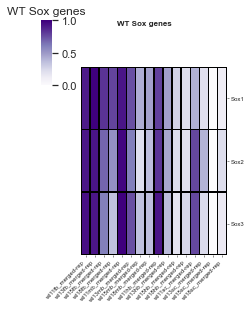

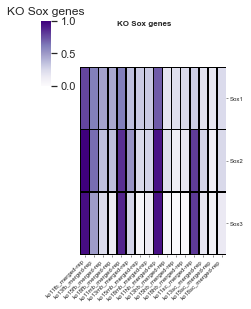

In [11]:
# -----------------------------------------------------------------------------------
#                         Figure K
# -----------------------------------------------------------------------------------
x = df_sig[wt_merged_cols + ko_merged_cols].values #returns a numpy array
x = ((x.T - np.min(x, axis=1))/(np.max(x, axis=1) - np.min(x, axis=1))).T
df_norm = pd.DataFrame(x)
df_norm.columns = wt_merged_cols + ko_merged_cols

# Normalise Sox rows so we can see comparative difference more easily
df_norm[gene_name] = df_sig[gene_name].values
plot_gene_heatmap(df_norm, ['Sox1'], ['Sox2'], ['Sox3'], [], 
                  wt_merged_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='input', genes=None,  cmap=rna_cmap, title='WT Sox genes',
                  v_min=0, v_max=1
                 )

ko_merged_cols = [c for c in merged_cols if 'ko' in c]
plot_gene_heatmap(df_norm, ['Sox1'], ['Sox2'], ['Sox3'], [], 
                  ko_merged_cols, vae_data, vae_mse, 
                  gene_name, mark='', genes=None,  method='input', cmap=rna_cmap, title='KO Sox genes',
                  v_min=0, v_max=1)



#### Figure 1 Line plots

Figure 1K is used to show how the genes change and the variability of larger groups of marker genes.

In [12]:
import statsmodels.stats.api as sms

from sklearn import linear_model
plt.rcParams['svg.fonttype'] = 'none'  # Ensure text is saved as text
plt.rcParams['figure.figsize'] = (1, 1)
sns.set(rc={'figure.figsize': (1, 1), 'font.family': 'sans-serif',
            'font.sans-serif': 'Arial', 'font.size': 6}, style='ticks')

def set_ax_params(ax):
    ax.tick_params(direction='out', length=2, width=0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=6)
    ax.tick_params(axis='x', which='major', pad=2.0)
    ax.tick_params(axis='y', which='major', pad=2.0)
    
    
e11_cols = [c for c in df_training if 'ko' in c and '11' in c and 'merged' in c]
e13_cols = [c for c in df_training if 'ko' in c and '13' in c and 'merged' in c]
e15_cols = [c for c in df_training if 'ko' in c and '15' in c and 'merged' in c]
e18_cols = [c for c in df_training if 'ko' in c and '18' in c and 'merged' in c]

w_e11_cols = [c for c in df_training if 'wt' in c and '11' in c and 'merged' in c]
w_e13_cols = [c for c in df_training if 'wt' in c and '13' in c and 'merged' in c]
w_e15_cols = [c for c in df_training if 'wt' in c and '15' in c and 'merged' in c]
w_e18_cols = [c for c in df_training if 'wt' in c and '18' in c and 'merged' in c]

ko_fb_cols = [c for c in df_training if 'ko' in c and 'fb' in c and 'merged' in c]
wt_fb_cols = [c for c in df_training if 'wt' in c and 'fb' in c and 'merged' in c]

def get_gis(genes, df):
    gene_idxs = []
    gene_names = []
    for i, g in enumerate(df[gene_name].values):
        if g in genes:
            gene_idxs.append(i)
            gene_names.append(g)
    return gene_idxs, gene_names

def plot_tissue_line(w_e18_cols, gene_idxs, gene_names, df_training, title='', ko_e18_cols=None):
    labels_lst = []
    c_i = 5
    wt_colour = '#5ebce5'
    fig, ax = plt.subplots()
    wt_values = []
    ko_values = []
    for i, g in enumerate(gene_names):
        labels_lst.append(f'WT {g}')
        wt_values.append(df_training[w_e18_cols].values[gene_idxs[i]])
        if ko_e18_cols:
            labels_lst.append(f'Eed-cKO {g}')
            ko_values.append(df_training[ko_e18_cols].values[gene_idxs[i]])
        c_i += 1
        if c_i == len(sci_colour):
            c_i = 0
    wt_values = np.array(wt_values)
    ko_values = np.array(ko_values)
    wt_mean = np.mean(wt_values, axis=0)
    ko_mean = np.mean(ko_values, axis=0)

    wt_yerr = np.std(wt_values, axis=0)/np.sqrt(len(wt_values[0]))
    ko_yerr = np.std(ko_values, axis=0)/np.sqrt(len(ko_values[0]))

    (_, caps, _) = ax.errorbar(['FB', 'MB', 'HB', 'SC'], wt_mean, yerr=wt_yerr,
                               fmt='o', markersize=3, capsize=5, c=wt_colour, alpha=1.0, linewidth=2.0)
    for cap in caps:
        cap.set_markeredgewidth(1)
        
    (_, caps, _) = ax.errorbar(['FB', 'MB', 'HB', 'SC'], ko_mean, yerr=ko_yerr, fmt='o', markersize=3, capsize=5, 
                               c=ko_colour, alpha=1.0, linewidth=2.0)

    for cap in caps:
        cap.set_markeredgewidth(1)

    
    ax.plot(['FB', 'MB', 'HB', 'SC'], wt_mean, c=wt_colour, alpha=1.0, linewidth=1.0)
    ax.plot(['FB', 'MB', 'HB', 'SC'], ko_mean, c=ko_colour, alpha=1.0, linewidth=1.0)

    plt.title(f'{title}')
    ax.tick_params(labelsize=6)
    ax.set_ylim(0, 8)
    
    set_ax_params(ax)
    save_fig(f'line_time_{title}')
    plt.show()
    plt.show()


def plot_time_line(w_fb_cols, gene_idxs, gene_names, df_training, title='', ko_fb_cols=None):
    labels_lst = []
    c_i = 5
    fig, ax = plt.subplots()
    wt_values = []
    ko_values = []
    wt_colour = '#5ebce5'
    
    for i, g in enumerate(gene_names):
        wt_values.append(df_training[w_fb_cols].values[gene_idxs[i]])

        labels_lst.append(f'WT {g}')
        if ko_fb_cols:
            ko_values.append(df_training[ko_fb_cols].values[gene_idxs[i]])
            labels_lst.append(f'Eed-cKO {g}')
        c_i += 1
        if c_i == len(sci_colour):
            c_i = 0
        
    wt_values = np.array(wt_values)
    ko_values = np.array(ko_values)
    
    wt_mean = np.mean(wt_values, axis=0)
    ko_mean = np.mean(ko_values, axis=0)
    
    wt_yerr = np.std(wt_values, axis=0)/np.sqrt(len(wt_values[0]))
    ko_yerr = np.std(ko_values, axis=0)/np.sqrt(len(ko_values[0]))
    
    (_, caps, _) = ax.errorbar(['E11.5', 'E13.5', 'E15.5', 'E18.5'], wt_mean, yerr=wt_yerr,
                               fmt='o', markersize=3, capsize=5, c=wt_colour, alpha=1.0, linewidth=2.0)
    for cap in caps:
        cap.set_markeredgewidth(1)
        
    (_, caps, _) = ax.errorbar(['E11.5', 'E13.5', 'E15.5', 'E18.5'], ko_mean, yerr=ko_yerr, fmt='o', markersize=3, capsize=5, 
                               c=ko_colour, alpha=1.0, linewidth=2.0)

    for cap in caps:
        cap.set_markeredgewidth(1)


    
    ax.plot(['E11.5', 'E13.5', 'E15.5', 'E18.5'], wt_mean, c=wt_colour, alpha=1.0, linewidth=1.0)
    ax.plot(['E11.5', 'E13.5', 'E15.5', 'E18.5'], ko_mean, c=ko_colour, alpha=1.0, linewidth=1.0)
    plt.title(f'{title}')
    ax.tick_params(labelsize=6)
    ax.set_ylim(0, 8)

    ax.legend(labels_lst, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=6)
    set_ax_params(ax)
    save_fig(f'line_tissue_{title}')
    plt.show()

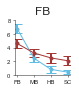

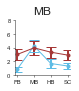

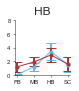

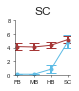

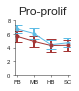

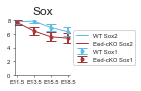

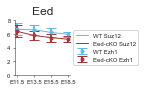

In [13]:
# -----------------------------------------------------------------------------------
#                         Figure J
# -----------------------------------------------------------------------------------


fb_genes = ['Dlx1', 'Dlx5', 'Dlx2', 'Lhx6', 'Emx1', 'Eomes', 'Tbr1', 'Foxg1', 'Lhx6', 'Dlx1', 'Dlx2', 'Dlx5', 'Nr2e2']
mb_genes = ['En1', 'En2', 'Lmx1a', 'Bhlhe23', 'Sall4']
hb_genes = ['Hoxb1', 'Krox20', 'Fev', 'Hoxd3', 'Phox2b']
sc_genes = ['Hoxd8', 'Hoxd9', 'Hoxd10', 'Hoxd11', 'Hoxd12', 'Hoxd13', 'Hoxa7', 'Hoxa9', 'Hoxa10', 'Hoxa11', 'Hoxa13',
            'Hoxb9', 'Hoxb13',  'Hoxc8', 'Hoxc9', 'Hoxc10', 'Hoxc11', 'Hoxc12', 'Hoxc13']

genes = fb_genes 
gene_idxs, gene_names = get_gis(genes, df_sig)
plot_tissue_line(w_e18_cols, gene_idxs, gene_names, df_sig, 'FB', e18_cols)

genes = mb_genes 
gene_idxs, gene_names = get_gis(genes, df_sig)
plot_tissue_line(w_e18_cols, gene_idxs, gene_names, df_sig, 'MB', e18_cols)

genes = hb_genes 
gene_idxs, gene_names = get_gis(genes, df_sig)
plot_tissue_line(w_e18_cols, gene_idxs, gene_names, df_sig, 'HB', e18_cols)

genes = sc_genes #[ 'Hoxa11', 'Hoxa13', 'Hoxb13', 'Hoxc10', 'Hoxc12', 'Hoxc13']
gene_idxs, gene_names = get_gis(genes, df_sig)
plot_tissue_line(w_e18_cols, gene_idxs, gene_names, df_sig, 'SC', e18_cols)

genes = ['Ccnb1',
'Cdc25c',
'E2f1',
'Ccna2',
'Ccnd1']
gene_idxs, gene_names = get_gis(genes, df_sig)
plot_tissue_line(w_e13_cols, gene_idxs, gene_names, df_sig, 'Pro-prolif', e13_cols)

genes = ['Sox1', 'Sox2', 'Sox3']
gene_idxs, gene_names = get_gis(genes, df_sig)
plot_time_line(wt_fb_cols, gene_idxs, gene_names, df_sig, 'Sox', ko_fb_cols)

genes = ['Eed', 'Ezh2', 'Suz12', 'Ezh1']
gene_idxs, gene_names = get_gis(genes, df_sig)
plot_time_line(wt_fb_cols, gene_idxs, gene_names, df_sig, 'Eed', ko_fb_cols)


## Figure 4

Here we show the plots for Figure 4.  

1) A: correlation between VAE dimensions and observed features  
2) B: PRC2 profile for Sox3, Foxg1, En2 and Hoxc9 in WT and KO  
3) C: Marker genes projected onto the latent space  
4) D: FB logFC, MB logFC, HB logFC and MB E10.5, MB E13.5 and MB E16.5 H3K27me3 projected onto the latent space  


H3K4me1 H3K4me1 1.0 0.0
H3K4me1 H3K4me2 0.5778097092631771 6.30995115822728e-123
H3K4me1 H3K4me3 0.5424054244750087 1.0462500992593941e-105
H3K4me1 H3K27ac 0.4474397884575597 1.868776646979828e-68
H3K4me1 H3K36me3 0.23331708205528487 2.0919177335021665e-18
H3K4me1 H3K27me3 0.4183583143974251 3.2720909943747853e-59
H3K4me1 Log2FC FB -0.005828660227440098 0.829281719129814
H3K4me1 Log2FC MB -0.07363958460652882 0.006374445946102697
H3K4me1 Log2FC HB -0.12856724647180287 1.7885836117251365e-06
H3K4me1 Log2FC SC 0.01896101107434295 0.48299579643865487
H3K4me1 VAE0 0.29031611063142665 4.930166724775107e-28
H3K4me1 VAE1 -0.4294316663802427 1.2627522245545507e-62
H3K4me1 VAE2 0.1608669464307792 2.097868335239766e-09
H3K4me2 H3K4me1 0.5778097092631771 6.30995115822728e-123
H3K4me2 H3K4me2 1.0 0.0
H3K4me2 H3K4me3 0.9249576243822666 0.0
H3K4me2 H3K27ac 0.5809337496355107 1.505979846743912e-124
H3K4me2 H3K36me3 0.2978871153402344 1.7085900450507975e-29
H3K4me2 H3K27me3 0.32314796735960055 1.08518

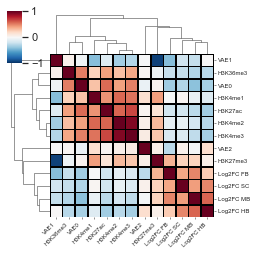

,H3K4me1,H3K4me1 padj,H3K4me2,H3K4me2 padj,H3K4me3,H3K4me3 padj,H3K27ac,H3K27ac padj,H3K36me3,H3K36me3 padj,...,Log2FC HB padj,Log2FC SC,Log2FC SC padj,VAE0,VAE0 padj,VAE1,VAE1 padj,VAE2,VAE2 padj,labels
0,1.000000,0.000,0.577810,0.000,0.542405,0.000,0.447440,0.000,0.233317,0.000,...,0.000,0.018961,0.483,0.290316,0.000,-0.429432,0.000,0.160867,0.000,H3K4me1
1,0.577810,0.000,1.000000,0.000,0.924958,0.000,0.580934,0.000,0.297887,0.000,...,0.000,-0.081153,0.003,0.413076,0.000,-0.345997,0.000,0.054786,0.064,H3K4me2
2,0.542405,0.000,0.924958,0.000,1.000000,0.000,0.665160,0.000,0.384651,0.000,...,0.000,-0.146253,0.000,0.504997,0.000,-0.295549,0.000,0.082467,0.006,H3K4me3
3,0.447440,0.000,0.580934,0.000,0.665160,0.000,1.000000,0.000,0.409243,0.000,...,0.000,-0.193694,0.000,0.565461,0.000,-0.139742,0.000,0.028115,0.388,H3K27ac
4,0.233317,0.000,0.297887,0.000,0.384651,0.000,0.409243,0.000,1.000000,0.000,...,0.000,-0.238202,0.000,0.512823,0.000,0.046966,0.107,0.016249,0.593,H3K36me3
5,0.418358,0.000,0.323148,0.000,0.280802,0.000,0.133524,0.000,-0.060812,0.029,...,0.042,0.229742,0.000,0.038033,0.159,-0.934789,0.000,0.063581,0.034,H3K27me3
6,-0.005829,0.829,-0.090222,0.001,-0.155255,0.000,-0.189595,0.000,-0.227877,0.000,...,0.000,0.384757,0.000,-0.356593,0.000,-0.425466,0.000,-0.267380,0.000,Log2FC FB
7,-0.073640,0.008,-0.180603,0.000,-0.250089,0.000,-0.273331,0.000,-0.291420,0.000,...,0.000,0.418366,0.000,-0.410923,0.000,-0.236248,0.000,-0.022891,0.469,Log2FC MB
8,-0.128567,0.000,-0.278947,0.000,-0.339278,0.000,-0.345238,0.000,-0.274281,0.000,...,0.000,0.491601,0.000,-0.335841,0.000,0.000894,0.974,0.168714,0.000,Log2FC HB
9,0.018961,0.523,-0.081153,0.003,-0.146253,0.000,-0.193694,0.000,-0.238202,0.000,...,0.000,1.000000,0.000,-0.300869,0.000,-0.196599,0.000,0.054409,0.064,Log2FC SC


In [14]:
all_vae_data = np.copy(vae_data)
vae_data = all_vae_data[:, 0:3]
vae_vis = VVis(vae_mse, u, None)
div_cmap = 'seismic'

# -----------------------------------------------------------------------------------
#                         Figure A
# -----------------------------------------------------------------------------------
vae_vis.plot_feature_correlation(df_observed, '', columns=observed_cols, show_plt=True, user_config={'cmap': 'RdBu_r'},
                                 title=f'Feature vs observed features {experiment_name}',
                             output_dir=fig_dir, save_fig=True)

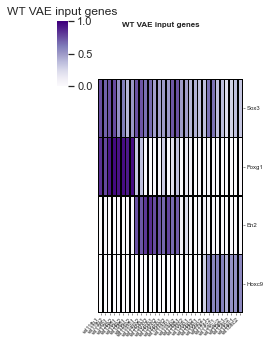

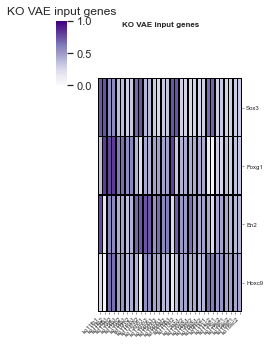

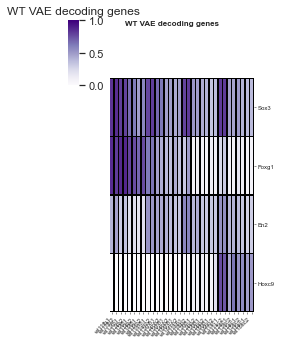

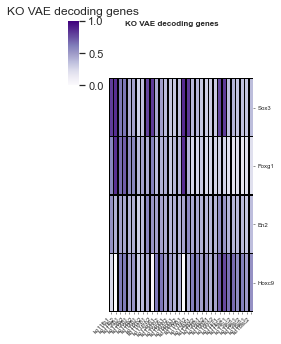

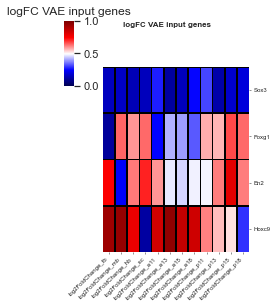

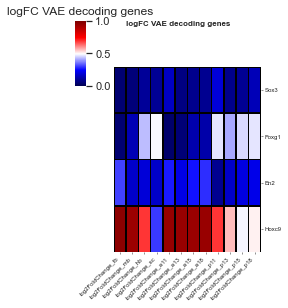

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/matrix.py:1205: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


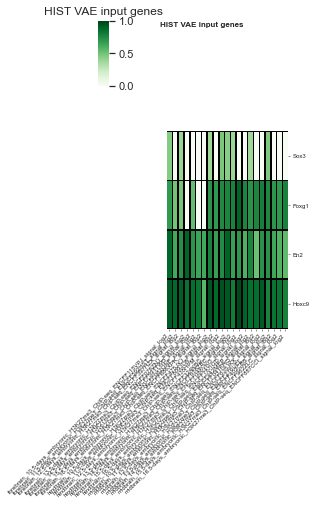

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/matrix.py:1205: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


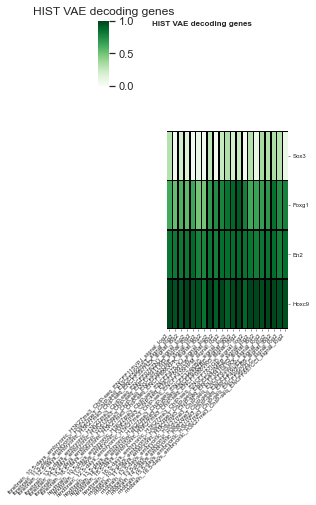

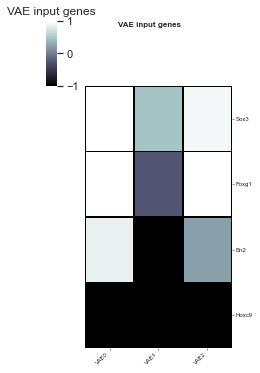

In [15]:
# -----------------------------------------------------------------------------------
#                         Figure B
# -----------------------------------------------------------------------------------
bin_cmap = 'bone'
wt_cols = [c for c in df_input.columns if 'wt' in c]
plot_gene_heatmap(df_input, ['Sox3'], ['Foxg1'], ['En2'], ['Hoxc9'], 
                  wt_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='input', cmap=rna_cmap, title='WT VAE input genes', v_min=0, v_max=1)
ko_cols = [c for c in df_input.columns if 'ko' in c]
plot_gene_heatmap(df_input, ['Sox3'], ['Foxg1'], ['En2'], ['Hoxc9'], 
                  ko_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='input', cmap=rna_cmap, title='KO VAE input genes', v_min=0, v_max=1)
# Decoding of the same genes
plot_gene_heatmap(df_input, ['Sox3'], ['Foxg1'], ['En2'], ['Hoxc9'], 
                  wt_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='decoding', cmap=rna_cmap, 
                  title='WT VAE decoding genes', v_min=0, v_max=1)
plot_gene_heatmap(df_input, ['Sox3'], ['Foxg1'], ['En2'], ['Hoxc9'], 
                  ko_cols, vae_data, vae_mse,
                  gene_name, mark='', method='decoding', cmap=rna_cmap, 
                  title='KO VAE decoding genes', v_min=0, v_max=1)

# logFC
log_cols = [c for c in df_input.columns if 'log2FoldChange' in c]
plot_gene_heatmap(df_input, ['Sox3'], ['Foxg1'], ['En2'], ['Hoxc9'], 
                  log_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='input', cmap=div_cmap, title='logFC VAE input genes', v_min=0, v_max=1)
# Decoding of the same genes
plot_gene_heatmap(df_input, ['Sox3'], ['Foxg1'], ['En2'], ['Hoxc9'], 
                  log_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='decoding', cmap=div_cmap, 
                  title='logFC VAE decoding genes', v_min=0, v_max=1)

# H3K27me3 cols
h3k_cols = [c for c in df_input.columns if 'H3K27me3' in c]
plot_gene_heatmap(df_input, ['Sox3'], ['Foxg1'], ['En2'], ['Hoxc9'], 
                  h3k_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='input', cmap=hist_cmap, title='HIST VAE input genes', v_min=0, v_max=1)
# Decoding of the same genes
plot_gene_heatmap(df_input, ['Sox3'], ['Foxg1'], ['En2'], ['Hoxc9'], 
                  h3k_cols, vae_data, vae_mse, 
                  gene_name, mark='', method='decoding', cmap=hist_cmap, 
                  title='HIST VAE decoding genes', v_min=0, v_max=1)

# latent space
plot_gene_heatmap(df, ['Sox3'], ['Foxg1'], ['En2'], ['Hoxc9'], 
                  ['VAE0', 'VAE1', 'VAE2'], vae_data, vae_mse, 
                  gene_name, mark='', method='input', cmap=bin_cmap, title='VAE input genes', v_min=-1, v_max=1)


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/sciviso/scatterplot.py:232: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


<Figure size 216x360 with 0 Axes>

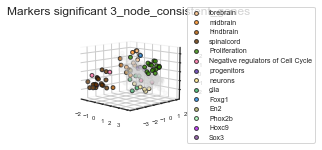

<Axes3DSubplot:title={'center':'Markers significant 3_node_consistent_genes'}>

<Figure size 144x144 with 0 Axes>

In [16]:
# -----------------------------------------------------------------------------------
#                         Figure C
# -----------------------------------------------------------------------------------

# Encode the values using the VAE
scaler = MinMaxScaler(copy=True)
# Encode all the genes into the latent space
vae_sig_input_values, df_sig_input, labels = get_input_data(df_sig, gene_name)
sig_scaled_vals = scaler.fit_transform(vae_sig_input_values)
sig_vae_data = vae_mse.encode_new_data(sig_scaled_vals)


gene_markers_sep = [['Emx1', 'Eomes', 'Tbr1', 'Foxg1', 'Lhx6'], 
                    ['En1', 'En2', 'Lmx1a', 'Bhlhe23', 'Sall4'], 
                    ['Hoxb1', 'Krox20', 'Fev', 'Hoxd3', 'Phox2b'],
                    ['Hoxd8', 'Hoxd9', 'Hoxd10', 'Hoxd11', 'Hoxd12', 'Hoxd13', 'Hoxa7', 'Hoxa9', 'Hoxa10', 'Hoxa11', 
                    'Hoxa13', 'Hoxb9', 'Hoxb13',  'Hoxc8', 'Hoxc9', 'Hoxc10', 'Hoxc11', 'Hoxc12', 'Hoxc13'],
                    ['Ccna1', 'Ccna2', 'Ccnd1', 'Ccnd2', 'Ccnd3', 'Ccne1', 'Ccne2', 'Cdc25a', 
                    'Cdc25b', 'Cdc25c', 'E2f1', 'E2f2', 'E2f3', 'Mcm10', 'Mcm5', 'Mcm3', 'Mcm2', 'Cip2a'],
                    ['Cdkn1a', 'Cdkn1b', 'Cdkn1c', 'Cdkn2a', 'Cdkn2b', 'Cdkn2c', 'Cdkn2d'],
                    ['Sox2', 'Sox1', 'Sox3', 'Hes1', 'Hes5'],
                    ['Snap25', 'Syt1', 'Slc32a1','Slc17a6', 'Syn1'],
                    ['Cspg4', 'Aqp4', 'Slc6a11', 'Olig1', 'Igfbp3'],
                    ['Foxg1'], 
                    ['En2'], 
                    ['Phox2b'],
                    ['Hoxc9'],
                    ['Sox3']
                    ]

marker_labels_sep = ['forebrain', 'midbrain', 'hindbrain',  'spinalcord', 
                     'Proliferation', 'Negative regulators of Cell Cycle', 
                    'progenitors', 'neurons', 'glia',
                     'Foxg1', 'En2', 'Phox2b', 'Hoxc9', 'Sox3'
                    ]
color_map = {}
i = 4
colours = []
for c in marker_labels_sep:
    if 'brain' in c or 'spinal' in c:
        if 'spinal' in c:
            color_map[c] = sc_colour
        else:
            color_map[c] = get_tissue_colour(c.lower())
    else:
        color_map[c] = sci_colour[i]
    i += 1
vae_vis.colours = [c for i, c in color_map.items()]
vae_vis.s = 20
vae_vis.plot_values_on_scatters(df_sig_input, gene_name, marker_labels_sep,
                            gene_markers_sep, output_dir=fig_dir, vae_data=sig_vae_data, fig_type="svg",
                            title=f'Markers significant {experiment_name}',
                            show_plt=True, save_fig=False, angle_plot=315, user_config={'s': 15, 'figsize': (2, 2)})

<Figure size 144x144 with 0 Axes>

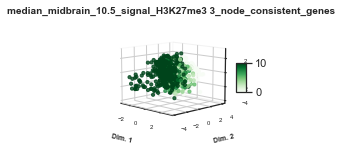

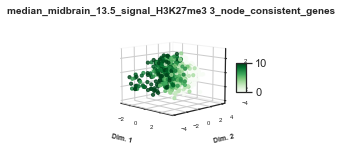

<Figure size 144x144 with 0 Axes>

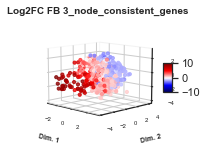

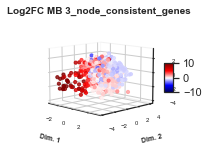

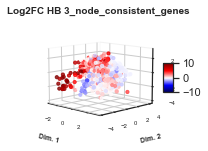

In [17]:

# -----------------------------------------------------------------------------------
#                         Figure D
# -----------------------------------------------------------------------------------

feature_obs_ax = vae_vis.plot_feature_scatters(df, gene_name, columns=['median_midbrain_10.5_signal_H3K27me3',
                                                                       'median_midbrain_13.5_signal_H3K27me3',
                                                                       'median_midbrain_16.5_signal_H3K27me3',]
                                                                       , vae_data=vae_data, 
                                               show_plt=False, output_dir=fig_dir, fig_type="svg", 
                                               save_fig=False, title=f'{experiment_name}',
                                               angle_plot=315, user_config={'cmap':hist_cmap, 
                                                                            'vmin':0, 'vmax':10,
                                                                            'figsize': (2, 2)})

feature_obs_ax = vae_vis.plot_feature_scatters(df, gene_name, columns=['Log2FC FB',
                                                                      'Log2FC MB',
                                                                      'Log2FC HB']
                                               , vae_data=vae_data, 
                                               show_plt=False, output_dir=fig_dir, fig_type="svg", 
                                               save_fig=False, title=f'{experiment_name}',
                                               angle_plot=315, user_config={'cmap': div_cmap, 
                                                                            'vmin':-10, 'vmax':10,
                                                                           'figsize': (2, 2)})


## Visualisations

<Figure size 144x144 with 0 Axes>

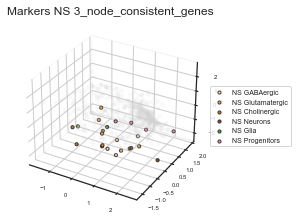

<Figure size 288x288 with 0 Axes>

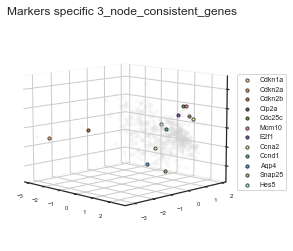

<Axes3DSubplot:title={'center':'Markers specific 3_node_consistent_genes'}>

<Figure size 288x288 with 0 Axes>

In [18]:
gene_markers_ns = [['Slc32a1', 'Gad1', 'Gad2', 'Slc6a1'],
                    ['Slc17a6', 'VGLUT2', 'Slc17a7', 'VGLUT1', 'Slc17a8', 'VGLUT3', 'Slc1a1', 'Slc1a2', 'Slc1a6'],
                    ['Chat', 'Slc5a7', 'Slc18a3', 'Ache'],
                    ['Tubb3', 'Snap25', 'Syt1'],
                    ['Gfap', 'Olig2'],
                    ['Sox2', 'Hes1', 'Hes5', 'Vim']]

marker_labels_ns = ['NS GABAergic', 'NS Glutamatergic', 'NS Cholinergic', 'NS Neurons', 'NS Glia', 'NS Progenitors']

vae_vis.plot_values_on_scatters(df_sig_input, gene_name, marker_labels_ns,
                            gene_markers_ns, output_dir=fig_dir, vae_data=sig_vae_data,
                            title=f'Markers NS {experiment_name}', fig_type="pdf",
                            show_plt=True, save_fig=True)
# Plot gene names on scatter
gene_markers_sep = [['Cdkn1a'], ['Cdkn2a'], ['Cdkn2b'], ['Cip2a'], ['Cdc25c'], ['Mcm10'],
                    ['E2f1'], ['Ccna2'], ['Ccnd1'], ['Aqp4'], ['Snap25'], ['Hes5']
                    ]

marker_labels_sep = ['Cdkn1a', 'Cdkn2a', 'Cdkn2b',  'Cip2a', 
                     'Cdc25c', 'Mcm10', 
                    'E2f1', 'Ccna2', 'Ccnd1',
                     'Aqp4', 'Snap25', 'Hes5'
                    ]
vae_vis.plot_values_on_scatters(df_sig_input, gene_name, marker_labels_sep,
                            gene_markers_sep, output_dir=fig_dir, vae_data=sig_vae_data, fig_type="svg",
                            title=f'Markers specific {experiment_name}',
                            show_plt=True, save_fig=True,  angle_plot=315)

## 5) Quantify separability of latent space

In the next section we compare the distances in the latent space to those using other summaries of the data. 

The distances are computed as the euclidean distance to the centroid. Where the centroid is either the center of the cluster of genes of interest OR the center of the two groups. We expect the referece to have a greater spread and that our genes should be closer to the centroid of the gene set they belong to.

Datasets tested:
1) VAE deep (3 layer)
2) VAE shallow (1 layer)
3) PCA (3 PCs)
4) RNAseq data (normalised TMM 64 features)
5) VAE input data (normalised TMM and normalised H3K27me3 and LogFC, 100 features)
6) logFC forebrain and H3K27me3 signal.



## 6) Save ranks for GSEA

We perform GSEA on the ranks of the VAE.

In [19]:

# -----------------------------------------------------------------------------------
#                         Save genes sorted by latent node (GSEA)
# -----------------------------------------------------------------------------------
for n in range(0, num_nodes):
    with open(f'{ora_dir}vae{n}_genes_{experiment_name}_{date}.csv', 'w+') as f:
        f.write(gene_id + ',value\n')
        desc_sorted = (-vae_data[:,n]).argsort()  # Sort the genes by descending order
        genes = df[gene_id].values[desc_sorted]
        vae_data_sorted = vae_data[:,n][desc_sorted]
        i = 0
        for g in genes:
            f.write(f'{g},{vae_data_sorted[i]}\n')
            i += 1
            

# -----------------------------------------------------------------------------------
#                         Save genes sorted by latent node (GSEA)
# -----------------------------------------------------------------------------------
for n in range(0, num_nodes):
    with open(f'{ora_dir}vae{n}_gene-names_{experiment_name}_{date}.csv', 'w+') as f:
        f.write(gene_name + ',value\n')
        desc_sorted = (-vae_data[:,n]).argsort()  # Sort the genes by descending order
        genes = df[gene_name].values[desc_sorted]
        vae_data_sorted = vae_data[:,n][desc_sorted]
        i = 0
        for g in genes:
            f.write(f'{g},{vae_data_sorted[i]}\n')
            i += 1

## 7) Compute clusters driving VAE 

In the next section, we use information about the VAE nodes to compute clusters regarding the latent space. 

--------------------------------------------------------------------------------
                                   Set 1	62	                                    
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                                   Set 2	180	                                   
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                                   Set 3	80	                                    
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                                   Set 4	223	                                   
--------------------------------------------------------------------------------
----------------------------

<Figure size 288x288 with 0 Axes>

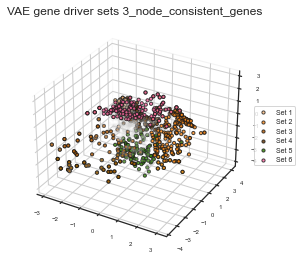

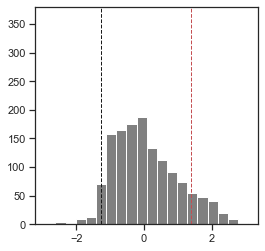

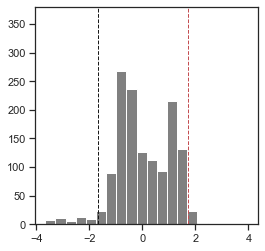

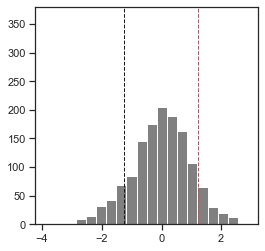

In [20]:
def get_q1_q3(node_idx):
    iqr_val = 0.95 * stats.iqr(vae_data[:, node_idx])
    q1_genes_idxs = np.where(vae_data[:, node_idx] <= -1.25)[0] # (np.mean(vae_data[:, node_idx]) - iqr_val))[0]
    q3_genes_idxs = np.where(vae_data[:, node_idx] >= 1.25)[0] #(np.mean(vae_data[:, node_idx]) + iqr_val))[0]
    return q1_genes_idxs, q3_genes_idxs

# -----------------------------------------------------------------------------------
#                         Find the genes driving the latent space
# -----------------------------------------------------------------------------------

n_clusters = 6
# Get the indexs for each of the q1 and q3 for each node
q1_n0_idxs, q3_n0_idxs = get_q1_q3(0)
q1_n1_idxs, q3_n1_idxs = get_q1_q3(1)
q1_n2_idxs, q3_n2_idxs = get_q1_q3(2)

# Create a list of the indexs
vae_set_idxs = [
    q1_n0_idxs, q3_n0_idxs, 
    q1_n1_idxs, q3_n1_idxs, 
    q1_n2_idxs, q3_n2_idxs
]

vae_set_labels = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']

# Get all the driver and non-driver idxs
non_driver_idxs = []
driver_idxs = []
for i, ids in enumerate(vae_set_idxs):
    vae_mse.u.dp([vae_set_labels[i], len(ids)])
    driver_idxs += list(ids)
    
for i in range(0, len(df)):
    if i not in driver_idxs:
        non_driver_idxs.append(i)
# -----------------------------------------------------------------------------------
#                         Plot a VENN of how the genes in teh clusters overlap
# -----------------------------------------------------------------------------------

gene_sets = [[], [], [], [], [], []]

for i, g in enumerate(df[gene_name].values):
    ci = 0
    for gene_set in vae_set_idxs:
        for j in gene_set:
            if i == j:
                gene_sets[ci].append(g)
        ci += 1

set_sets = []
for g in gene_sets:  
    if len(g) > 1:
        set_sets.append(set(g))

#set_labels = venn.get_labels(set_sets)
vae_set_labels_l = [s.replace('Set', 'Group') for s in vae_set_labels]
vae_set_genes_len_dict = {}
vae_set_genes_dict = {}
for i, l in enumerate(vae_set_labels):
    vae_set_genes_dict[l] = gene_sets[i]
    vae_set_genes_len_dict[l] = len(gene_sets[i])

#venn.venn6(set_labels, names=vae_set_labels_l)
#save_fig('gene_sets.svg')
#plt.show()


vae_set_genes_as_list = []
for set_name in vae_set_labels:
    vae_set_genes_as_list.append(vae_set_genes_dict.get(set_name))

sorted_sets_by_size = {k: v for k, v in sorted(vae_set_genes_len_dict.items(), key=lambda item: item[1])}
gene_set_labels_unique = []
for g in df[gene_name].values:
    found = False
    for label, values in sorted_sets_by_size.items():
        gene_group = vae_set_genes_dict[label]
        for g_l in gene_group:
            if g_l == g:
                gene_set_labels_unique.append(label)
                found = True
                break
        if found:
            break
    if not found:
        gene_set_labels_unique.append(None)
df['GeneDriverSet'] =  gene_set_labels_unique

# We also want to add each of the gene sets
gene_labels = [[], [], [], [], [], []]
for g in df[gene_name].values:
    for i, label in enumerate(vae_set_labels):
        found = False
        gene_group = vae_set_genes_dict[label]
        for g_l in gene_group:
            if g == g_l:
                gene_labels[i].append(True)
                found = True
                break
        if not found:
            gene_labels[i].append(False)
for i, label in enumerate(vae_set_labels):
    df[label] = gene_labels[i]
    
            
# -----------------------------------------------------------------------------------
#                         Plot the genes on a scatter plot
# -----------------------------------------------------------------------------------
vae_vis.plot_values_on_scatters(df, gene_name, vae_set_labels,
                            vae_set_genes_as_list, vae_data=vae_data, output_dir=fig_dir, 
                            title=f'VAE gene driver sets {experiment_name}',
                            show_plt=True, save_fig=True)

# -----------------------------------------------------------------------------------
#                         Plot histograms of the VAE nodes with cutoffs used above
# -----------------------------------------------------------------------------------
for n in range(0, num_nodes):
    x = vae_data[:,n]
    iqr_val = 1.0 * stats.iqr(x)
    plt.hist(vae_data[:,n], bins=20, color='grey')
    plt.ylim(0, 380)
    plt.axvline(x.mean() - iqr_val, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(x.mean() + iqr_val, color='r', linestyle='dashed', linewidth=1)
    save_fig(f'hist-{n}')
    plt.show()



(array([  14.,  265., 7945., 4210.,  253.,   37.,   18.,   18.,   26.,
          11.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

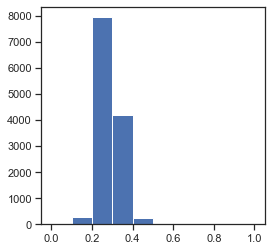

In [21]:
plt.hist(df_sig_input['log2FoldChange_fb'].values)

In [22]:
df.to_csv(f'{output_dir}DF_training_VAE.csv', index=False)

## Save data for input to the website

In [23]:
# Add the cluster values to the df_sig_input so that we can visualise those on the latent space
df_sig_input

# -----------------------------------------------------------------------------------
#                         Data setup for Vis
# -----------------------------------------------------------------------------------

hist_metric = 'signal'
input_cols = list(df_sig_input.columns)

def get_median(df, mark, time="", tissue="brain"):
    cols = []
    for c in df.columns:
        if tissue in c and mark in c and hist_metric in c and time in c and 'median' not in c:
            cols.append(c)
    # get nan median
    vals = np.nanmedian(df[cols].values, axis=1)
    
    return np.nan_to_num(vals)

marks = ['H3K27me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K27ac', 'H3K9me3', 'H3K36me3', 'H3K9ac']

# Get the median over all time points and all brain tissues
for m in marks:
    # For the marks we didn't keep this in the input 
    df_sig_input[f'{m}'] = get_median(df_sig, m, time="", tissue="brain")
    
times = ['10.5', '11.5', '12.5', '13.5', '14.5', '15.5', '16.5']
for m in marks:
    for e in times:
        df_sig_input[f'median_brain_{e}_signal_{m}'] = get_median(df_sig, m, time=e, tissue="brain")
    
tissues = ['hindbrain', 'midbrain', 'forebrain']
for m in marks:
    for e in times:
        for t in tissues:
            df_sig_input[f'median_{t}_{e}_signal_{m}'] = get_median(df_sig, m, time=e, tissue=t)


df_sig_input['AverageWT'] = np.mean(df_sig[[c for c in df_sig.columns if 'wt' in c]].values, axis=1)
df_sig_input['AverageKO'] = np.mean(df_sig[[c for c in df_sig.columns if 'ko' in c]].values, axis=1)
df_sig_input['AverageKO-WT'] = df_sig_input['AverageKO'].values - df_sig_input['AverageWT'].values

# Add in the VAE columns 
for v in range(0, len(sig_vae_data[0])):
    df_sig_input[f'VAE{v}'] = sig_vae_data[:, v]

# Rename/add some columns just to make figs easier
df_sig_input['Log2FC FB'] = df_sig['log2FoldChange_fb'].values
df_sig_input['Log2FC MB'] = df_sig['log2FoldChange_mb'].values
df_sig_input['Log2FC HB'] = df_sig['log2FoldChange_hb'].values
df_sig_input['Log2FC SC'] = df_sig['log2FoldChange_sc'].values
df_sig_input['Log2FC A11'] = df_sig['log2FoldChange_a11'].values
df_sig_input['Log2FC A13'] = df_sig['log2FoldChange_a13'].values
df_sig_input['Log2FC A15'] = df_sig['log2FoldChange_a15'].values
df_sig_input['Log2FC A18'] = df_sig['log2FoldChange_a18'].values
df_sig_input['Log2FC P11'] = df_sig['log2FoldChange_p11'].values
df_sig_input['Log2FC P13'] = df_sig['log2FoldChange_p13'].values
df_sig_input['Log2FC P15'] = df_sig['log2FoldChange_p15'].values
df_sig_input['Log2FC P18'] = df_sig['log2FoldChange_p18'].values



/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [24]:
df_training

,level_0,entrezgene_id,external_gene_name,ensembl_gene_id,chrs,wt11fb1,wt11fb2,wt13fb1,wt13fb2,wt15fb1,...,ko15mb_merged-rep,ko18mb_merged-rep,ko11hb_merged-rep,ko13hb_merged-rep,ko15hb_merged-rep,ko18hb_merged-rep,ko11sc_merged-rep,ko13sc_merged-rep,ko15sc_merged-rep,ko18sc_merged-rep
0,22,100039596,Tcf24,ENSMUSG00000099032,1,0.036967,0.000000,0.000000,0.117607,0.115029,...,1.354508,2.010396,0.696520,1.455900,1.817656,2.129484,0.488633,0.948807,1.125029,1.635636
1,37,14048,Eya1,ENSMUSG00000025932,1,4.871068,6.079498,4.450584,4.546339,3.648064,...,4.413960,4.382909,5.342146,4.744922,4.525706,4.842515,4.776000,3.393935,3.829654,4.098087
2,38,17681,Msc,ENSMUSG00000025930,1,0.419438,0.351603,0.180671,0.452119,0.716528,...,1.578198,2.075640,1.368070,2.062583,1.661717,2.648328,2.267934,2.474883,2.028493,2.621163
3,42,226866,Sbspon,ENSMUSG00000032719,1,0.391165,0.612548,0.539628,0.723482,0.787616,...,0.971404,1.089588,0.611552,1.085105,1.080316,1.619992,0.710653,0.698025,1.166523,1.791507
4,53,94227,Pi15,ENSMUSG00000067780,1,0.302862,0.452037,0.429609,0.723482,0.787616,...,1.814407,3.014021,0.352095,1.577501,2.278077,3.481130,0.139701,1.198267,2.127628,3.739829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366,20656,12338,Capn6,ENSMUSG00000067276,X,5.405896,6.252664,4.772695,4.385631,2.599981,...,3.631229,3.902079,5.012153,3.207432,3.333847,3.352505,4.384485,2.570951,3.306429,3.104725
1367,20660,22067,Trpc5,ENSMUSG00000041710,X,0.176031,0.096254,0.804964,1.476961,2.695497,...,3.640032,3.941713,0.680088,3.808168,3.943584,3.925410,0.516566,2.986919,3.587593,4.023615
1368,20757,237178,Ppef1,ENSMUSG00000062168,X,0.447167,0.064878,0.400742,0.359649,0.221559,...,1.146692,1.142115,0.310367,1.172972,1.902963,1.149155,0.223703,3.653562,3.596417,2.509351
1369,20777,70008,Ace2,ENSMUSG00000015405,X,0.362327,0.452037,0.037990,0.079460,0.367916,...,0.149532,0.846707,0.249537,0.561091,0.446561,1.462765,0.052559,0.066093,0.230294,0.632523


In [25]:
# Read in the signficant but unmarked and un perturbed datasets so we can label 
prelim_folder = '../../data/results/prelim/'
marked_sig = pd.read_csv(f'{prelim_folder}Exp._Sig_Marked_un-Perturbed_gene-name_20210124.csv')
unmarked_sig = pd.read_csv(f'{prelim_folder}Exp._Sig_Unmarked_un-Perturbed_gene-name_20210124.csv')

In [26]:
marked_caff_sig = pd.read_csv(f'{prelim_folder}Exp._Sig_Marked_Perturbed_gene-name_20210124.csv')
unmarked_caff_sig = pd.read_csv(f'{prelim_folder}Exp._Sig_Unmarked_Perturbed_gene-name_20210124.csv')

In [27]:
set(marked_sig[gene_name]) & set(unmarked_sig[gene_name])

set()

In [28]:
set(marked_caff_sig[gene_name]) & set(unmarked_caff_sig[gene_name])

set()

In [29]:
cluster_map ={1: 'Unmarked proliferation', 2: 'Marked Posterior', 3: 'Unmarked immune response', 
             4: 'Development', 5: 'Marked Anterior'}

pro_prolif_genes = ['E2f1', 'E2f2', 'E2f3', 'Ccna1', 'Ccna2', 'Ccnb1', 'Ccnb2', 'Ccnb3',  'Ccnd1', 'Ccnd2', 'Ccnd3', 
          'Ccne1', 'Ccne2', 'Cdk1', 'Cck2', 'Cdk4', 'Cdk6',
         'Cdc25a', 'Cdc25b', 'Cdc25c']
anti_prolif_genes = ['Cdkn2a', 'Cdkn2b', 'Cdkn2c', 'Cdkn2d', 'Cdkn1a', 'Cdkn1b',  'Cdkn1c', 'Rb1','Chek1', 'Wee1']

gene_labels = []

marked_const_aff_genes = set(marked_caff_sig[gene_name])
unmarked_const_aff_genes = set(unmarked_caff_sig[gene_name])
marked_sig = set(marked_sig[gene_name])
unmarked_sig = set(unmarked_sig[gene_name])

for g in df_sig_input[gene_name].values:
    label = ''
    for i in range(1, 6):
        if g in gene_sets[i]:
            label += cluster_map.get(i) + ' '
    if label == '':
        # Check if it is in the consisently affected dataset
        if g in marked_const_aff_genes:
            label = 'Consistently affected marked'
        elif g in marked_sig:
            label = 'Partly affected marked'
        elif g in unmarked_const_aff_genes:
            label = 'Consistently affected unmarked'
        elif g in unmarked_sig:
            label = 'Partly affected unmarked'
        else:
            print(g)
    if g in pro_prolif_genes:
        u.warn_p([g, label])
    elif g in anti_prolif_genes:
        u.err_p([g, label])
    gene_labels.append(label.strip())
df_sig_input['GroupLabel'] = gene_labels

--------------------------------------------------------------------------------
                         Cdk1	Partly affected unmarked	                         
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                         Cdk4	Partly affected unmarked	                         
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                         E2f3	Partly affected unmarked	                         
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                         Ccnb1	Unmarked proliferation 	                         
--------------------------------------------------------------------------------
----------------------------

In [30]:
set(['Snap25', 'Syt1', 'Slc32a1', 'Slc17a6', 'Syn1']) & set(df_sig[gene_name])

{'Slc17a6', 'Slc32a1', 'Snap25', 'Syn1', 'Syt1'}

In [31]:
set(['Aqp4', 'Cspg4', 'Slc6a11', 'Olig1', 'Igfbp3']) & set(df_sig[gene_name])

{'Aqp4', 'Cspg4', 'Igfbp3', 'Olig1', 'Slc6a11'}

In [32]:
set(['Sox2', 'Sox1', 'Sox3',  'Hes1', 'Hes5']) & set(df_sig[gene_name])

{'Hes1', 'Hes5', 'Sox1', 'Sox2', 'Sox3'}

In [33]:
# Save the select columns to the DF for visualisation
all_cols = [gene_name,
     'VAE0',
    'VAE1',
    'VAE2',
    'Log2FC FB',
    'Log2FC MB',
    'Log2FC HB',
    'Log2FC SC',
    'GroupLabel',
    'H3K27me3',
    'H3K27ac',
    'H3K9me3',
    'H3K4me1', 
    'H3K4me2', 
    'H3K4me3', 
    'H3K36me3', 
    'H3K9ac',
    'AverageWT',
    'AverageKO',
    'AverageKO-WT',
    'Log2FC A11',
    'Log2FC A13',
    'Log2FC A15',
    'Log2FC A18',
    'Log2FC P11',
    'Log2FC P13',
    'Log2FC P15',
    'Log2FC P18'
]
df_sig_input[all_cols].to_csv(f'{output_dir}DF_Visualisation_VAE.csv', index=False)

## Figure 5 box plots

Plot boxplot trends of each group



No handles with labels found to put in legend.


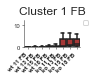

No handles with labels found to put in legend.


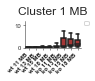

No handles with labels found to put in legend.


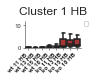

No handles with labels found to put in legend.


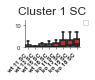

No handles with labels found to put in legend.


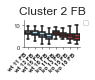

No handles with labels found to put in legend.


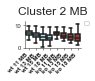

No handles with labels found to put in legend.


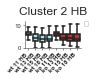

No handles with labels found to put in legend.


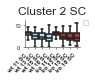

No handles with labels found to put in legend.


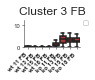

No handles with labels found to put in legend.


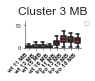

No handles with labels found to put in legend.


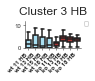

No handles with labels found to put in legend.


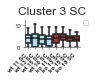

No handles with labels found to put in legend.


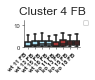

No handles with labels found to put in legend.


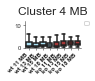

No handles with labels found to put in legend.


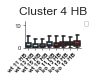

No handles with labels found to put in legend.


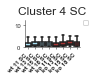

No handles with labels found to put in legend.


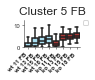

No handles with labels found to put in legend.


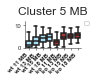

No handles with labels found to put in legend.


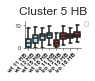

No handles with labels found to put in legend.


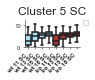

No handles with labels found to put in legend.


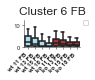

No handles with labels found to put in legend.


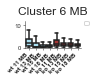

No handles with labels found to put in legend.


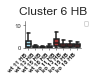

No handles with labels found to put in legend.


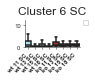

In [34]:
hox_genes = sc_genes
forebrain_genes = fb_genes
h3cols = []
fb_rna_cols = []
sc_rna_cols = []

# Do it in this way so they are correctly ordered
for c in df.columns:
    if 'H3K27me' in c and 'signal' in c:
        h3cols.append(c)
    elif 'wt' in c:
        if 'fb' in c:
            fb_rna_cols.append(c)
        if 'sc' in c:
            sc_rna_cols.append(c)
for c in df.columns:
    if 'ko' in c:
        if 'fb' in c:
            fb_rna_cols.append(c)
        if 'sc' in c:
            sc_rna_cols.append(c)

def plot_gene_boxplot(df, title, cluster_id, cols, idxs):
    idxs = idxs[cluster_id]
    boxplot = Boxplot(df, gene_name, cols[0])
    box_df = boxplot.format_data_for_boxplot(df, cols, gene_name, df[gene_name].values[idxs])
    is_hox = []
    sns.set_style("white")
    for c in box_df['Samples'].values:
        if 'Hox' in c:
            is_hox.append('Hox')
        else:
            is_hox.append('Hox like')
    box_df['is_hox'] = is_hox

    boxplot = Boxplot(box_df, "Conditions", "Values", add_stats=False, add_dots=False, figsize=(1,0.5),
                       order=cols)
    boxplot.palette = sci_colour

    ax = boxplot.plot()
    plt.title(title)
    ax.set_ylim(0, 12)
    sns.set_style("white")
    c = 0
    for b in ax.artists:
        if c < len(cols)/2:
            b.set_facecolor(wt_colour)
        else:
            b.set_facecolor(ko_colour)
        c += 1
    save_fig(f'{title}')
    
    plt.show()

avgs_fb = [['wt11fb1',
         'wt11fb2'],
         ['wt13fb1',
         'wt13fb2'],
         ['wt15fb1',
         'wt15fb2'],
         ['wt18fb1',
         'wt18fb2'],
         ['ko11fb1',
         'ko11fb2'],
         ['ko13fb1',
         'ko13fb2'],
         ['ko15fb1',
         'ko15fb2'],
         ['ko18fb1',
         'ko18fb2']]

avgs_sc = [['wt11sc1',
         'wt11sc2'],
         ['wt13sc1',
         'wt13sc2'],
         ['wt15sc1',
         'wt15sc2'],
         ['wt18sc1',
         'wt18sc2'],
         ['ko11sc1',
         'ko11sc2'],
         ['ko13sc1',
         'ko13sc2'],
         ['ko15sc1',
         'ko15sc2'],
         ['ko18sc1',
         'ko18sc2']]

avgs_hb = [['wt11hb1',
         'wt11hb2'],
         ['wt13hb1',
         'wt13hb2'],
         ['wt15hb1',
         'wt15hb2'],
         ['wt18hb1',
         'wt18hb2'],
         ['ko11hb1',
         'ko11hb2'],
         ['ko13hb1',
         'ko13hb2'],
         ['ko15hb1',
         'ko15hb2'],
         ['ko18hb1',
         'ko18hb2']]

avgs_mb = [['wt11mb1',
         'wt11mb2'],
         ['wt13mb1',
         'wt13mb2'],
         ['wt15mb1',
         'wt15mb2'],
         ['wt18mb1',
         'wt18mb2'],
         ['ko11mb1',
         'ko11mb2'],
         ['ko13mb1',
         'ko13mb2'],
         ['ko15mb1',
         'ko15mb2'],
         ['ko18mb1',
         'ko18mb2']]
avgs_df = pd.DataFrame()
avgs_df[gene_name] = df[gene_name].values
fb_cols = []
for f in avgs_fb:
    new_col = f'{f[0][:2]} {f[0][2:4]} FB'
    avgs_df[new_col] = (df[f[0]].values + df[f[1]].values) / 2.0
    fb_cols.append(new_col)
    
sc_cols = []
for f in avgs_sc:
    new_col = f'{f[0][:2]} {f[0][2:4]} SC'
    avgs_df[new_col] = (df[f[0]].values + df[f[1]].values) / 2.0
    sc_cols.append(new_col)
    
mb_cols = []
for f in avgs_mb:
    new_col = f'{f[0][:2]} {f[0][2:4]} MB'
    avgs_df[new_col] = (df[f[0]].values + df[f[1]].values) / 2.0
    mb_cols.append(new_col)
    
hb_cols = []
for f in avgs_hb:
    new_col = f'{f[0][:2]} {f[0][2:4]} HB'
    avgs_df[new_col] = (df[f[0]].values + df[f[1]].values) / 2.0
    hb_cols.append(new_col)
    
for i, gs in enumerate(vae_set_idxs):
    plot_gene_boxplot(avgs_df, f'Cluster {i + 1} FB', i, fb_cols, vae_set_idxs)
    plot_gene_boxplot(avgs_df, f'Cluster {i + 1} MB', i, mb_cols, vae_set_idxs)
    plot_gene_boxplot(avgs_df, f'Cluster {i + 1} HB', i, hb_cols, vae_set_idxs)
    plot_gene_boxplot(avgs_df, f'Cluster {i + 1} SC', i, sc_cols, vae_set_idxs)

## Figure 5 heatmaps

Plot the heatmaps to show the logFC and the H3K27me3 signal

In [35]:
def plot_vae_rna_cols(vis_df, cols, num_nodes, fb_logfc, mb_logfc, hb_logfc, sc_logfc, 
                      h3k27me3_fb_e11, h3k27me3_fb_e18, h3k27me3_hb_e11, h3k27me3_hb_e18, title='Heatmap', 
                      num_values=10):
    vae_cols = [f'VAE{i}' for i in range(0, num_nodes)]

    sns.set_style("ticks")
    for r_i, r_c in enumerate(cols):
        for direction in ['up', 'down']:
            # First add the bottom ones
            fig, ax = plt.subplots()
            sns.set(rc={'figure.figsize': (3.5, 2), 'font.family': 'sans-serif',
            'font.sans-serif': 'Arial', 'font.size': 6}, style="ticks")
            rcm_df_sorted = vis_df.sort_values(by=[r_c])
            if direction == 'up':
                rcm_df_tails = rcm_df_sorted.nlargest(num_values, r_c)
            else:
                rcm_df_tails = rcm_df_sorted.nsmallest(num_values, r_c)
            # Add the smallest and the largest
            # first heatmap
            N = len(rcm_df_tails)
            ax.set_xlim(-0.5, 7.5)
            ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
            ax.set_xticklabels(['FB', 'MB', 'HB', 'SC', 
                                'FB e11.5', 'FB e18.5', 'HB e11.5', 'HB e18'])
            ax.set_yticks(range(N))
            ax.set_yticklabels(list(rcm_df_tails[gene_name].values))
            ax.set_ylabel('Genes')

            max_hk3 = 35
            max_rna = 10
            min_rna = -10
            cmap_rna = 'seismic'
            cmap_hk3 = 'Greens'
            im1 = ax.imshow(np.vstack([rcm_df_tails[fb_logfc], rcm_df_tails[fb_logfc]]).T, 
                            aspect='auto',
                            extent=[-0.5, 0.5, -0.5, N - 0.5], vmin=min_rna, vmax=max_rna,
                            origin='lower', cmap=cmap_rna)
            im1 = ax.imshow(np.vstack([rcm_df_tails[mb_logfc], rcm_df_tails[mb_logfc]]).T, 
                            aspect='auto',
                            extent=[0.5, 1.5, -0.5, N - 0.5], vmin=min_rna, vmax=max_rna,
                            origin='lower', cmap=cmap_rna)
            im1 = ax.imshow(np.vstack([rcm_df_tails[hb_logfc], rcm_df_tails[hb_logfc]]).T, 
                aspect='auto',
                extent=[1.5, 2.5, -0.5, N - 0.5], vmin=min_rna, vmax=max_rna,
                origin='lower', cmap=cmap_rna)
            # Now add in the H3K27me3 ones
            im1 = ax.imshow(np.vstack([rcm_df_tails[sc_logfc], rcm_df_tails[sc_logfc]]).T, 
                aspect='auto',
                extent=[2.5, 3.5, -0.5, N - 0.5], vmin=min_rna, vmax=max_rna,
                origin='lower', cmap=cmap_rna)

            im3 = ax.imshow(np.vstack([rcm_df_tails[h3k27me3_fb_e11], rcm_df_tails[h3k27me3_fb_e11]]).T, 
                            aspect='auto',
                            extent=[3.5, 4.5, -0.5, N - 0.5], vmin=0, vmax=max_hk3,
                            origin='lower', cmap=cmap_hk3)

            im3 = ax.imshow(np.vstack([rcm_df_tails[h3k27me3_fb_e18], rcm_df_tails[h3k27me3_fb_e18]]).T, 
                aspect='auto',
                extent=[4.5, 5.5, -0.5, N - 0.5], vmin=0, vmax=max_hk3,
                origin='lower', cmap=cmap_hk3)

            im3 = ax.imshow(np.vstack([rcm_df_tails[h3k27me3_hb_e11], rcm_df_tails[h3k27me3_hb_e11]]).T, 
                            aspect='auto',
                            extent=[5.5, 6.5, -0.5, N - 0.5], vmin=0, vmax=max_hk3,
                            origin='lower', cmap=cmap_hk3)

            im3 = ax.imshow(np.vstack([rcm_df_tails[h3k27me3_hb_e18], rcm_df_tails[h3k27me3_hb_e18]]).T, 
                aspect='auto',
                extent=[6.5, 7.5, -0.5, N - 0.5], vmin=0, vmax=max_hk3,
                origin='lower', cmap=cmap_hk3)

            cbar1 = fig.colorbar(im1, ax=ax, label='RNA logFC')
            cbar2 = fig.colorbar(im3, ax=ax, label='H3K27me3 signal')

            fig.tight_layout()
            plt.xticks(rotation=45, horizontalalignment='right')
            plt.title(f'{title} {r_c}')
            save_fig(f'{title.replace(" ", "_")}_{direction}_{r_c}')

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:75: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


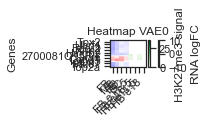

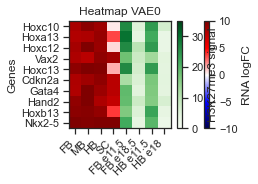

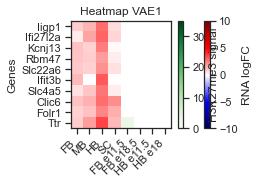

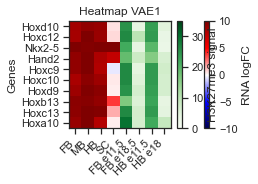

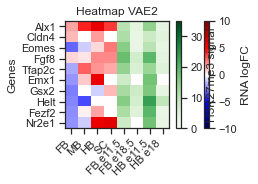

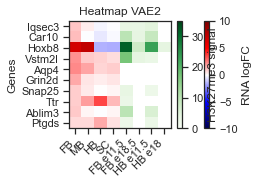

In [36]:
h3k27me3_fb_e11 = [c for c in df.columns if '10.5' in c and 'forebrain' in c and 'H3K27me3' in c and 'signal' in c and 'median' not in c][0]
h3k27me3_fb_e18 = [c for c in df.columns if '16.5' in c and 'forebrain' in c and 'H3K27me3' in c and 'signal' in c and 'median' not in c][0]

h3k27me3_hb_e11 = [c for c in df.columns if '10.5' in c and 'hindbrain' in c and 'H3K27me3' in c and 'signal' in c and 'median' not in c][0]
h3k27me3_hb_e18 = [c for c in df.columns if '16.5' in c and 'hindbrain' in c and 'H3K27me3' in c and 'signal' in c and 'median' not in c][0]

plot_vae_rna_cols(df, ["VAE0", "VAE1", "VAE2"], 3,     
                    'Log2FC FB',
                    'Log2FC MB',
                    'Log2FC HB',
                    'Log2FC SC', 
                     h3k27me3_fb_e11, h3k27me3_fb_e18, h3k27me3_hb_e11, h3k27me3_hb_e18)

## Save the VAE groups for ORA

Here we save the groups for ORA and the ranks for GSEA.



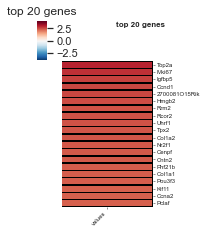

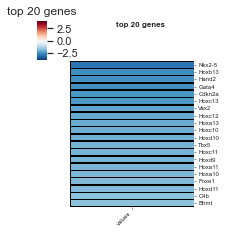

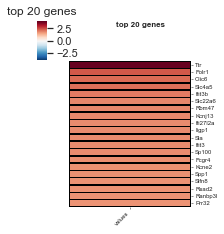

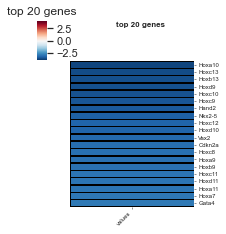

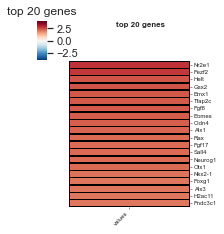

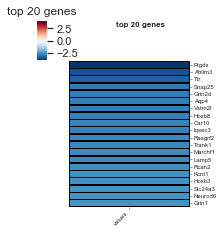

In [37]:
# -----------------------------------------------------------------------------------
#                         Save background genes (ORA)
# -----------------------------------------------------------------------------------

with open(f'{ora_dir}background_genes_{experiment_name}_{date}.csv', 'w+') as f:
    genes = df_all[gene_id].values
    f.write(gene_id + '\n')
    for g in genes:
        f.write(f'{g}\n')
        
# -----------------------------------------------------------------------------------
#                         Save training genes (sig genes) (ORA)
# -----------------------------------------------------------------------------------
with open(f'{ora_dir}training-df_genes_{experiment_name}_{date}.csv', 'w+') as f:
    genes = df_training[gene_id].values
    f.write(gene_id + '\n')
    for g in genes:
        f.write(f'{g}\n')
        
# -----------------------------------------------------------------------------------
#                         Save genes in each of the clusters we annotated (ORA)
# -----------------------------------------------------------------------------------
for i in range(0, n_clusters):
    with open(f'{ora_dir}cluster_{i}_genes_{experiment_name}_{date}.csv', 'w+') as f:
        genes = df[gene_id].values[vae_set_idxs[i]]
        f.write(gene_id + '\n')
        for g in genes:
            f.write(f'{g}\n')
    
# -----------------------------------------------------------------------------------
#                         Save genes sorted by latent node (GSEA) and only the top
# -----------------------------------------------------------------------------------
def plot_top_vae_genes(vae_data_sorted, gene_ids_sorted, gene_names_sorted, label="", num=20):
        i = 0
        gs = []
        for g in gene_names_sorted:
            if g != "0":
                f.write(f'{g},{vae_data_sorted[i]}\n')
                gs.append(g)
            else:
                f.write(f'{gene_ids_sorted[i]},{vae_data_sorted[i]}\n')
                gs.append(gene_ids_sorted[i])
            i += 1
            if i >= num:
                break
        heatmap_df = pd.DataFrame()
        heatmap_df[gene_name] = gs
        heatmap_df['values'] = vae_data_sorted[:num]
        heatmap = Heatmap(heatmap_df, ['values'], gene_name, vmin=-4, vmax=4,
                  title=f'top {num} genes', cluster_cols=False, cluster_rows=False)
        heatmap.palette=sns.color_palette(sci_colour)
        heatmap.plot()
        pplot()
        save_fig(f'vae{n}_genes-top-{num}-{label}')
        plt.show()
        
for n in range(0, num_nodes):
    with open(f'{ora_dir}vae-{n + 1}_genes-top10_{experiment_name}_{date}.csv', 'w+') as f:
        f.write(gene_id + ',value\n')
        desc_sorted = (-vae_data[:,n]).argsort()  # Sort the genes by descending order
        gene_names_sorted = df[gene_name].values[desc_sorted]
        gene_ids_sorted = df[gene_id].values[desc_sorted]
        vae_data_sorted = vae_data[:,n][desc_sorted]
        plot_top_vae_genes(vae_data_sorted, gene_ids_sorted, gene_names_sorted, label="top")
        
    with open(f'{ora_dir}vae-{n + 1}_genes-bottom10_{experiment_name}_{date}.csv', 'w+') as f:
        f.write(gene_id + ',value\n')
        desc_sorted = (vae_data[:,n]).argsort()  # Sort the genes by descending order
        gene_names_sorted = df[gene_name].values[desc_sorted]
        vae_data_sorted = vae_data[:,n][desc_sorted]
        gene_ids_sorted = df[gene_id].values[desc_sorted]
        plot_top_vae_genes(vae_data_sorted, gene_ids_sorted, gene_names_sorted, label="bottom")

for n in range(0, num_nodes):
    with open(f'{ora_dir}vae-{n + 1}_{experiment_name}_{date}.csv', 'w+') as f:
        f.write(gene_id + ',value\n')
        desc_sorted = (vae_data[:,n]).argsort()  # Sort the genes by descending order
        gene_names_sorted = df[gene_id].values[desc_sorted]
        vae_data_sorted = vae_data[:,n][desc_sorted]
        for i, g in enumerate(gene_names_sorted):
            f.write(f'{g},{vae_data_sorted[i]}\n')

In [38]:
# -----------------------------------------------------------------------------------
#                         Save genes in each of the clusters we annotated (ORA)
# -----------------------------------------------------------------------------------
for i in range(0, n_clusters):
    with open(f'{ora_dir}cluster_{i}_gene-names_{experiment_name}_{date}.csv', 'w+') as f:
        genes = df[gene_name].values[vae_set_idxs[i]]
        rank_vae0 = vae_data[:, 0][vae_set_idxs[i]]
        rank_vae1 = vae_data[:, 1][vae_set_idxs[i]]
        rank_vae2 = vae_data[:, 2][vae_set_idxs[i]]
        f.write(f'gene_name,VAE-1,VAE-2,VAE-3\n')
        for i, g in enumerate(genes):
            f.write(f'{g},{rank_vae0[i]},{rank_vae1[i]},{rank_vae2[i]}\n')
    

## Figure 5 ChromHMM profiles

Plot Histone modification proflies for each group so we can see if there is any enrichment.

## 7) Inspecting the data in context of chromHMM annotations

Downloaded the pooled samples frmo http://enhancer.sdsc.edu/enhancer_export/ENCODE/chromHMM/pooled/
for forebrain, hindbrain, and midbrian at e16.5 on 04 December 2020.


http://enhancer.sdsc.edu/enhancer_export/ENCODE/chromHMM/readme

The files in this directory contain chromHMM chromatin state calls for multiple tissues during mouse embryonic development, as described here: http://www.biorxiv.org/content/early/2017/07/21/166652.

All files are in bed format. There is one file for each tissue at each developmental stage.
The columns are 1) chromosome, 2) regions start, 3)  region end, 4) chromatin state number 5) Chromatin state label. 
There are 15 chromating states, labeled as follows:


        State	Label	Description
        1	Pr-A	Promoter, Active
        2	Pr-W	Promoter, Weak/Inactive
        3	Pr-B	Promoter, Bivalent
        4	Pr-F	Promoter, Flanking
        5	En-Sd	Enhancer, Strong TSS-distal
        6	En-Sp	Enhancer, Strong TSS-proximal
        7	En-W	Enhancer, Weak TSS-distal
        8	En-Pd	Enhancer, Poised TSS-distal
        9	En-Pp	Enhancer, Poised TSS-proximal
        10	Tr-S	Transcription, Strong
        11	Tr-P	Transcription, Permissive
        12	Tr-I	Transcription, Initiation
        13	Hc-P	Heterochromatin, Polycomb-associated
        14	Hc-H	Heterochromatin, H3K9me3-associated
        15	NS	No Chromatin Signal
        NRS	NRS	No Reproducible State (ony relevant to "replicated" call set)


There are four subdirectories:

rep1\
This subdirectory contains chromatin state calls made using ChIP-seq datasets from biological replicate 1 (two biological replicates were performed for each ChIP-seq experiment).

rep2\
This subdirectory contains chromatin state calls made using ChIP-seq datasets from biological replicate 2.

replicated\
This subdirectory contains the intersection of the replicate 1 and replicate 2 chromatin state calls. 
Here, we require that a region is called in the same state in both replicates. If a region is not called in the same state in both replicates, it is labeled "NRS" for No Reproducible Signal. Note this is differenct than state 15, which is "No Signal." 

pooled\
This subdirectory contains chromatin state calls on ChIP-seq data pooled from both replicates.
We expect this will be the desired set of files for most users.


Each subdirectory has two additional subdirectorites:

archive\
This contains an older version of the bed files in which there are only state number, no labels. Aside from the labels, the files are identical to the working versions in the main directory.

tracks\
This contains bigBed versions of the files for visualization on the UCSC Genome Browser.


There is one additional subdirectory that does not conform to the templates decribed above. This is 6_mark_models\.
This subdirectory contains chromHMM segmentation of the e10.5 stage where we did not have all 8 marks. 
Note that the 11-state and 16-states models used for this segmentation are distinct from the 15-state (8-mark) model described above for the other stages. 
Please see manuscript and Extended Data Figure 7 for additional information.



        header = "chr,start,end,label,annotation"
        bed = Bed(os.path.join(self.data_dir, 'e16.5_forebrain_15_segments.bed'),
                  header=None, overlap_method='in_promoter',
                  output_bed_file=os.path.join(self.data_dir, 'e16.5_forebrain_15_segments_selectedPeaks.bed'),
                  buffer_after_tss=0, buffer_before_tss=10, buffer_gene_overlap=0,
                  gene_start=3, gene_end=4, gene_chr=2, gene_direction=5, gene_name=0,
                  chr_idx=0, start_idx=1, end_idx=2, peak_value=4, header_extra="3", sep='\t'
                  )
        # Add the gene annot
        bed.set_annotation_from_file(self.mm10_annot)
        # Now we can run the assign values
        bed.assign_locations_to_genes()
        bed.save_loc_to_csv(f'{self.data_dir}test_e16.5_forebrain_15_segments.csv')

In [39]:
# -----------------------------------------------------------------------------------
#                         Merge information with annotations
# -----------------------------------------------------------------------------------

chrom_dir = os.path.join(supp_dir, "annot")
chromhmm_annot = pd.read_csv(f'{chrom_dir}/e16.5_forebrain_15_segments.csv')
print(len(chromhmm_annot), len(df))
# Make sure we only keep 1 annotation per gene
chromhmm_annot = chromhmm_annot.groupby('external_gene_name').first()
# Merge this with our dataframe
df = df.merge(chromhmm_annot, on='external_gene_name', how='left', suffixes=('', '_chmm'))
# Ensure the new length is the same as the old length
len(df)

53254 1371


1371

Pr-A 0.24802314368370298 0.17457840756079304 [[1, 85], [61.0, 1286.0]]
Pr-W 0.0 0.0019815664944420985 [[0, 147], [62.0, 1224.0]]
Pr-B 0.5069657744624836 0.06957588473414678 [[9, 344], [53.0, 1027.0]]
Pr-F 0.0 0.0007674533464589754 [[0, 164], [62.0, 1207.0]]
En-Sd 0.0 1.0 [[0, 7], [62.0, 1364.0]]
En-Sp 0.0 0.6246954710395699 [[0, 26], [62.0, 1345.0]]
En-W 0.0 1.0 [[0, 4], [62.0, 1367.0]]
En-Pd 1.598809523809524 0.3757481029111142 [[2, 28], [60.0, 1343.0]]
En-Pp 0.0 0.4009217452840129 [[0, 36], [62.0, 1335.0]]
Tr-S 0.0 1.0 [[0, 4], [62.0, 1367.0]]
Tr-P 1.5675865953252606 0.27383679350529067 [[9, 134], [53.0, 1237.0]]
Tr-I 0.0 1.0 [[0, 15], [62.0, 1356.0]]
Hc-P 2.7622115672759966 0.0025213384922534265 [[15, 142], [47.0, 1229.0]]
Hc-H 11.221311475409836 0.124345814356102 [[1, 2], [61.0, 1369.0]]
NS 3.254421768707483 9.016987208538535e-05 [[20, 175], [42.0, 1196.0]]


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator


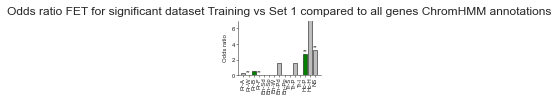

Pr-A 5.501604278074867 4.369599661953072e-15 [[48, 85], [132.0, 1286.0]]
Pr-W 3.38265306122449 6.965518380881973e-10 [[52, 147], [128.0, 1224.0]]
Pr-B 0.29126488939308 1.789748823125851e-07 [[16, 344], [164.0, 1027.0]]
Pr-F 1.2425562242635413 0.3342723653858386 [[26, 164], [154.0, 1207.0]]
En-Sd 0.0 1.0 [[0, 7], [180.0, 1364.0]]
En-Sp 4.026946107784431 0.00024000238512966222 [[13, 26], [167.0, 1345.0]]
En-W 1.9092178770949721 0.4607875660485072 [[1, 4], [179.0, 1367.0]]
En-Pd 0.26795690343176376 0.24214321559289073 [[1, 28], [179.0, 1343.0]]
En-Pp 0.8428030303030303 1.0 [[4, 36], [176.0, 1335.0]]
Tr-S 0.0 1.0 [[0, 4], [180.0, 1367.0]]
Tr-P 0.05157175018760944 8.291476909574294e-07 [[1, 134], [179.0, 1237.0]]
Tr-I 1.5322033898305085 0.45569407463635647 [[3, 15], [177.0, 1356.0]]
Hc-P 0.14669372165194558 1.774474486131201e-05 [[3, 142], [177.0, 1229.0]]
Hc-H 0.0 1.0 [[0, 2], [180.0, 1369.0]]
NS 0.11583535108958838 3.58631919432044e-07 [[3, 175], [177.0, 1196.0]]


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator


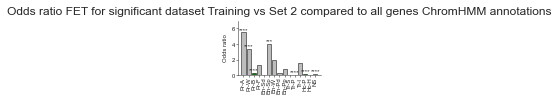

Pr-A 0.19151154132539092 0.08376742654843522 [[1, 85], [79.0, 1286.0]]
Pr-W 0.0 0.0003577056615543604 [[0, 147], [80.0, 1224.0]]
Pr-B 2.0961776348342407 0.0023318229337622215 [[33, 344], [47.0, 1027.0]]
Pr-F 0.0 8.143390424405342e-05 [[0, 164], [80.0, 1207.0]]
En-Sd 0.0 1.0 [[0, 7], [80.0, 1364.0]]
En-Sp 0.0 0.3950490840406473 [[0, 26], [80.0, 1345.0]]
En-W 0.0 1.0 [[0, 4], [80.0, 1367.0]]
En-Pd 0.0 0.39870718835415564 [[0, 28], [80.0, 1343.0]]
En-Pp 0.0 0.25896549663402646 [[0, 36], [80.0, 1335.0]]
Tr-S 0.0 1.0 [[0, 4], [80.0, 1367.0]]
Tr-P 0.0 0.0005323880338418577 [[0, 134], [80.0, 1237.0]]
Tr-I 0.0 1.0 [[0, 15], [80.0, 1356.0]]
Hc-P 9.565974796145293 4.412021222573505e-19 [[42, 142], [38.0, 1229.0]]
Hc-H 0.0 1.0 [[0, 2], [80.0, 1369.0]]
NS 0.0 5.188498522240626e-05 [[0, 175], [80.0, 1196.0]]


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator


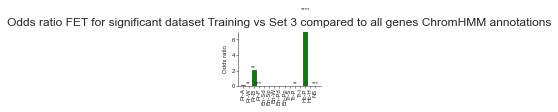

Pr-A 1.2485436893203883 0.4595642158711125 [[17, 85], [206.0, 1286.0]]
Pr-W 1.1956043956043956 0.4190882738128393 [[28, 147], [195.0, 1224.0]]
Pr-B 0.0 4.2162756122430757e-26 [[0, 344], [223.0, 1027.0]]
Pr-F 0.13442476890522329 2.0652404898182156e-07 [[4, 164], [219.0, 1207.0]]
En-Sd 0.8777348777348777 1.0 [[1, 7], [222.0, 1364.0]]
En-Sp 1.1864855328158082 0.7921397673155959 [[5, 26], [218.0, 1345.0]]
En-W 0.0 1.0 [[0, 4], [223.0, 1367.0]]
En-Pd 1.326201448321264 0.46145943879012286 [[6, 28], [217.0, 1343.0]]
En-Pp 0.6773211567732116 0.6440197216845152 [[4, 36], [219.0, 1335.0]]
Tr-S 1.5394144144144144 0.529779431950093 [[1, 4], [222.0, 1367.0]]
Tr-P 1.7771569957698141 0.006785427448538306 [[36, 134], [187.0, 1237.0]]
Tr-I 0.0 0.24959165623171417 [[0, 15], [223.0, 1356.0]]
Hc-P 0.0 3.7027908588664884e-10 [[0, 142], [223.0, 1229.0]]
Hc-H 6.1945701357466065 0.09644920300090952 [[2, 2], [221.0, 1369.0]]
NS 6.191746031746032 7.710881518533144e-30 [[106, 175], [117.0, 1196.0]]


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator


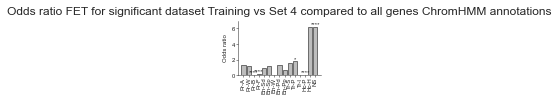

Pr-A 1.1477484787018255 0.6052307709708241 [[11, 85], [145.0, 1286.0]]
Pr-W 1.1547743184865187 0.5868947688092181 [[19, 147], [137.0, 1224.0]]
Pr-B 0.8009784458309699 0.32705749945288565 [[33, 344], [123.0, 1027.0]]
Pr-F 1.540414066931367 0.07246092554839278 [[27, 164], [129.0, 1207.0]]
En-Sd 2.5306122448979593 0.2324097507581155 [[2, 7], [154.0, 1364.0]]
En-Sp 1.0143288084464555 1.0 [[3, 26], [153.0, 1345.0]]
En-W 2.2048387096774196 0.4170010167725652 [[1, 4], [155.0, 1367.0]]
En-Pd 1.5882213812677388 0.37520130787198747 [[5, 28], [151.0, 1343.0]]
En-Pp 0.7271241830065359 0.7911379988646342 [[3, 36], [153.0, 1335.0]]
Tr-S 2.2048387096774196 0.4170010167725652 [[1, 4], [155.0, 1367.0]]
Tr-P 0.7692786069651741 0.4736439725646061 [[12, 134], [144.0, 1237.0]]
Tr-I 1.174025974025974 0.6898496143650471 [[2, 15], [154.0, 1356.0]]
Hc-P 1.6517041178367917 0.041197404546333624 [[25, 142], [131.0, 1229.0]]
Hc-H 0.0 1.0 [[0, 2], [156.0, 1369.0]]
NS 0.3210738255033557 0.001545060904323077 [[7, 175

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator


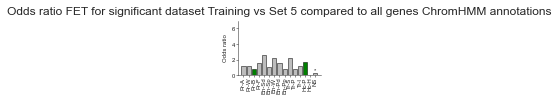

Pr-A 0.7893606138107417 0.6952526891058393 [[6, 85], [115.0, 1286.0]]
Pr-W 0.5112781954887218 0.11677826270018386 [[7, 147], [114.0, 1224.0]]
Pr-B 1.7677096083231334 0.0048695282776436925 [[45, 344], [76.0, 1027.0]]
Pr-F 0.810248377713135 0.6584862370606197 [[12, 164], [109.0, 1207.0]]
En-Sd 1.6238095238095238 0.4925103289011059 [[1, 7], [120.0, 1364.0]]
En-Sp 3.176450742240216 0.013965822833765887 [[7, 26], [114.0, 1345.0]]
En-W 0.0 1.0 [[0, 4], [121.0, 1367.0]]
En-Pd 0.8061224489795918 1.0 [[2, 28], [119.0, 1343.0]]
En-Pp 0.0 0.1110542623477057 [[0, 36], [121.0, 1335.0]]
Tr-S 0.0 1.0 [[0, 4], [121.0, 1367.0]]
Tr-P 0.15514862661482504 0.0013656410857616024 [[2, 134], [119.0, 1237.0]]
Tr-I 0.0 0.6262248512800649 [[0, 15], [121.0, 1356.0]]
Hc-P 2.4859904105483968 0.00026011625702471885 [[27, 142], [94.0, 1229.0]]
Hc-H 0.0 1.0 [[0, 2], [121.0, 1369.0]]
NS 0.056952380952380956 5.0284641066378245e-06 [[1, 175], [120.0, 1196.0]]


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator


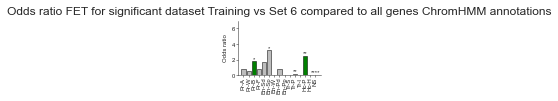

In [40]:
# We also want to plot the annotations from gorkin et al for each of the clusters
from statsmodels.stats.multitest import multipletests

def run_annot_plot(df_bg, df_fg, title=""):
    changes = []
    order = ['Pr-A', 'Pr-W', 'Pr-B', 'Pr-F', 'En-Sd', 'En-Sp', 
         'En-W', 'En-Pd', 'En-Pp', 'Tr-S', 'Tr-P', 'Tr-I', 
          'Hc-P', 'Hc-H', 'NS']
    total = len(df_bg) * 1.0
    total_sig = len(df_fg) * 1.0
    perc_all = []
    perc_sig = []
    
    for o in order:
        o_all = len(df_bg[df_bg['peak_value'] == o])
        o_sig = len(df_fg[df_fg['peak_value'] == o])
        perc_all.append(o_all)
        perc_sig.append(o_sig)
        if o_all == 0 and o_sig == 0:
            changes.append(0)
        else:
            changes.append(((o_sig) - (o_all)))

    odds_ratios = []
    pvalues = []
    for i, o in enumerate(order):
        # Do a FET on each one
        oddsratio, pvalue = stats.fisher_exact([[perc_sig[i], perc_all[i]], 
                                                [total_sig - perc_sig[i],
                                                 total - perc_all[i]]])

        print(o, oddsratio, pvalue,[[perc_sig[i], perc_all[i]], 
                                                [total_sig - perc_sig[i], 
                                                 total - perc_all[i]]])
        odds_ratios.append(oddsratio)
        pvalues.append(pvalue)

    reg, padj, a, b = multipletests(pvalues, alpha=0.1, 
                                    method='fdr_bh', returnsorted=False)

    p_sigs = []
    for p in padj: 
        if p > 0.05:
            p_sigs.append('')
        elif p <= 0.05 and p > 0.01:
            p_sigs.append('*')
        elif p <= 0.01 and p > 0.001:
            p_sigs.append('**')
        elif p <= 0.001 and p > 0.0001:
            p_sigs.append('***')
        elif p <= 0.0001:
            p_sigs.append('****')
        else:
            print(p)
            p_sigs.append('')

    fig, ax = plt.subplots(figsize=(1.5,1.0))
    c = [grey] * 14
    c[2] = "green"
    c[12] = "green"
    plt.bar(order, odds_ratios, color=c, linewidth=0.5, edgecolor='black')
    rects = ax.patches
    # Make some labels.
    labels = [f'{p_sigs[i]}' for i in range(0, len(rects))]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, label,
                ha='center', va='bottom')
    plt.ylim(0, 7)
    plt.yticks(np.arange(0, 7, 2.0))
    ax.set_title(f'Odds ratio FET for significant dataset {title} compared to all genes ChromHMM annotations')
    ax.set_xlabel('', fontsize=6)
    ax.set_ylabel('Odds ratio', fontsize=6)
    ax.set_xticklabels(order, rotation=90, ha="center")

        
    ax.tick_params(direction='out', length=2, width=0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=6)
    ax.tick_params(axis='x', which='major', pad=0)
    ax.tick_params(axis='y', which='major', pad=0)

    save_fig(f'OR-CM-{title}')
    
    plt.show()

for gene_set_label in vae_set_labels:
    run_annot_plot(df, df[df[gene_set_label] == True], title=f'Training vs {gene_set_label}')

53254 20900
Pr-A 0.16607420573205955 2.148953216275548e-92 [[85, 5950], [1286.0, 14950.0]]
Pr-W 0.5954233460773135 9.414743557547487e-10 [[147, 3508], [1224.0, 17392.0]]
Pr-B 7.495674942111099 2.2492063227528104e-139 [[344, 894], [1027.0, 20006.0]]
Pr-F 2.4410479101791274 2.9726993079622145e-20 [[164, 1102], [1207.0, 19798.0]]
En-Sd 1.572192513368984 0.22811405425132192 [[7, 68], [1364.0, 20832.0]]
En-Sp 1.1060587546986156 0.5926797643301734 [[26, 359], [1345.0, 20541.0]]
En-W 1.7443829031246734 0.3009362133436212 [[4, 35], [1367.0, 20865.0]]
En-Pd 2.157855547282204 0.00044861531889056703 [[28, 200], [1343.0, 20700.0]]
En-Pp 1.4407303370786517 0.050404632283021236 [[36, 384], [1335.0, 20516.0]]
Tr-S 0.870728393771554 1.0 [[4, 70], [1367.0, 20830.0]]
Tr-P 1.1432078804754633 0.15221518913175552 [[134, 1809], [1237.0, 19091.0]]
Tr-I 1.8384955752212389 0.032705856267117785 [[15, 125], [1356.0, 20775.0]]
Hc-P 5.861708384019851 2.776409677538453e-51 [[142, 404], [1229.0, 20496.0]]
Hc-H 0.121

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator


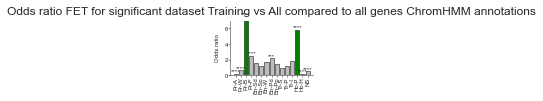

In [41]:
df_bg = df_all.copy()  # Make a copy so we don't override the other one

# Also have a look at how the marks plot over genes that are not significant
chrom_dir = os.path.join(supp_dir, "annot")
chromhmm_annot = pd.read_csv(f'{chrom_dir}/e16.5_forebrain_15_segments.csv')
print(len(chromhmm_annot), len(df_bg))
# Make sure we only keep 1 annotation per gene
chromhmm_annot = chromhmm_annot.groupby('external_gene_name').first()
# Merge this with our dataframe
df_bg = df_bg.merge(chromhmm_annot, on='external_gene_name', how='left', suffixes=('', '_chmm'))
# Ensure the new length is the same as the old length
run_annot_plot(df_bg, df, title=f'Training vs All')

## Figure 6

### Analysis of the cell cycle genes

Anti-proliferative genes:
```
genes = [
'Cdkn1a', 'Cdkn1b', 'Cdkn2a', 'Cdkn1c', 'Cdkn2b', 'Cdkn2c', 'Cdkn2d', 'Ccnd1', 'Ccnd2', 'Ccnd3', 'Ccne1', 'Ccne2', 'Rb1', 'E2f1', 'E2f2', 'E2f3', 'Cdk2', 'Cdk4', 'Cdk6'
]
```

Pro-prolifferative genes:
```
genes = ['Ccna1', 'Ccna2', 'Ccnb1', 'Ccnb2', 'Ccnb3', 'Cdc25a', 'Cdc25b', 'Cdc25c', 'Cdk1', 'Chek1', 'Chek2', 'Wee1', 'Wee2']
```

Here we plot:  

1) A: the anterior and posterior heamaps of the cell cycle genes and the H3K27me3 profiles for each of these.
    Suppl: as per reviewer comment also plot the tissue changes.  
2) C: plot the consistently affected pro-prolifferative genes fro the mouse embryo and then look at the corresponding genes in the human embryo context.  
3) D: plot the trends of select genes as they change over the tissues  

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/matrix.py:1205: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


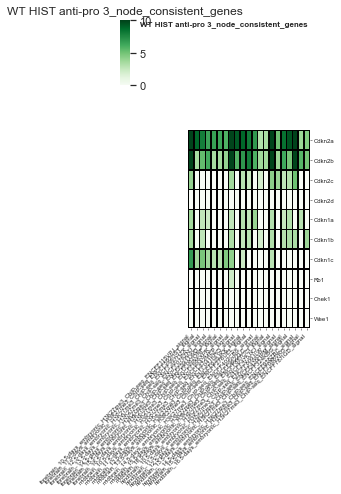

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


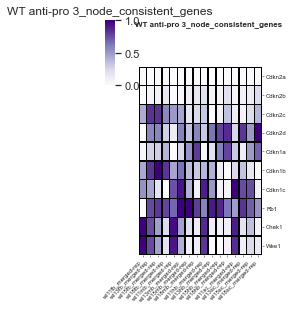

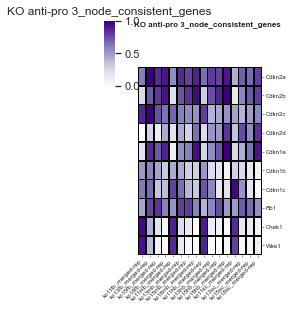

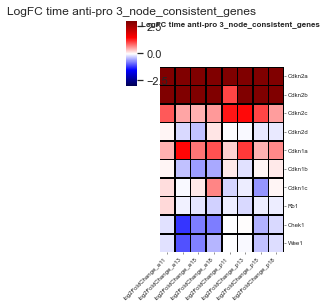

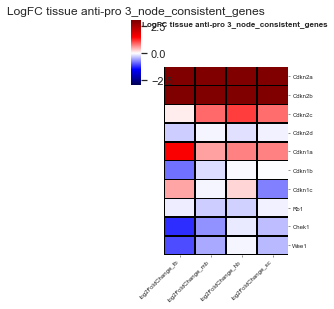

--------------------------------------------------------------------------------
                       anti-pro	Number of marked genes:	                        
--------------------------------------------------------------------------------
7 10


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: Mean of empty slice


In [42]:
div_cmap = 'seismic' #'RdBu_r'
H3k_cols = [
 'forebrain_10.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF115VPJ_signal',
 'forebrain_11.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF592HST_signal',
 'forebrain_12.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF397HZX_signal',
 'forebrain_13.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF076ZNJ_signal',
 'forebrain_14.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF591TWD_signal',
 'forebrain_15.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF082ONF_signal',
 'forebrain_16.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF686XPK_signal',
            
 'midbrain_10.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF942MEP_signal',
 'midbrain_11.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF041KRQ_signal',
 'midbrain_12.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF635JKX_signal',
 'midbrain_13.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF276UEL_signal',
 'midbrain_14.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF402CBS_signal',
 'midbrain_15.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF962ZLC_signal',
 'midbrain_16.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF887CCI_signal',
            
 'hindbrain_10.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF475JXJ_signal',
 'hindbrain_11.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF809JLW_signal',
 'hindbrain_12.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF435HPM_signal',
 'hindbrain_13.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF324KBG_signal',
 'hindbrain_14.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF658ZBC_signal',
 'hindbrain_15.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF086VKO_signal',
 'hindbrain_16.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF787IGD_signal']

wt_cols = [c for c in df_all.columns if 'wt' in c and 'merged' in c]
ko_cols = [c for c in df_all.columns if 'ko' in c and 'merged' in c]
logfc = [c for c in df_all.columns if 'log2Fold' in c]

mean_h3k = np.nanmean(-1 * df_all[logfc].values, axis=1)
desc_sorted = (mean_h3k).argsort()  # Sort the genes by descending order
gene_names_sorted = df_all[gene_name].values[desc_sorted]

genes = ['Cdkn2a', 'Cdkn2b', 'Cdkn2c', 'Cdkn2d', 'Cdkn1a', 'Cdkn1b',  'Cdkn1c', 'Rb1','Chek1', 'Wee1']
genes2 = [] 
genes4 = [] 
genes3 = []

tst_lbl = 'anti-pro'


values = df_all[H3k_cols].values[desc_sorted]
plot_gene_heatmap(df_all, genes, genes2, genes4, genes3,
                  H3k_cols, vae_data, vae_mse,
                  gene_name, mark='H3K27me3', method='input', 
                  title=f'WT HIST {tst_lbl} {experiment_name}', cmap=hist_cmap, 
                  genes=gene_names_sorted, values=values)

# Normalise so we can better see changes across the gene
x = df_all[wt_cols + ko_cols].values #returns a numpy array
x = ((x.T - np.min(x, axis=1))/(np.max(x, axis=1) - np.min(x, axis=1))).T
df_norm = pd.DataFrame(x)
df_norm.columns = wt_cols + ko_cols
df_norm[gene_name] = df_all[gene_name].values
values = df_norm[wt_cols].values[desc_sorted]
plot_gene_heatmap(df_norm, genes, genes2, genes4, genes3,
                  wt_cols, all_vae_data, vae_mse,
                  gene_name, mark='H3K27me3', merge_reps=False, cmap=rna_cmap,
                  method='input', title=f'WT {tst_lbl} {experiment_name}', 
                  genes=gene_names_sorted, values=values, v_min=0, v_max=1)

values = df_norm[ko_cols].values[desc_sorted]
plot_gene_heatmap(df_norm, genes, genes2, genes4, genes3,
                  ko_cols, all_vae_data, vae_mse,
                  gene_name, mark='H3K27me3', merge_reps=False, cmap=rna_cmap,
                  method='input', title=f'KO {tst_lbl} {experiment_name}', 
                  genes=gene_names_sorted, values=values, v_min=0, v_max=1)

logfc = [c for c in df_all.columns if 'log2Fold' in c and  ('a1' in c or 'p1' in c)]
values = df_all[logfc].values[desc_sorted]
plot_gene_heatmap(df_all, genes, genes2, genes4, genes3,
                  logfc, all_vae_data, vae_mse,
                  gene_name, mark='H3K27me3', merge_reps=False, cmap=div_cmap,
                  method='input', title=f'LogFC time {tst_lbl} {experiment_name}', 
                  genes=gene_names_sorted, values=values)

logfc = [c for c in df_all.columns if 'log2Fold' in c and ('a1' not in c and 'p1' not in c)]
values = df_all[logfc].values[desc_sorted]
plot_gene_heatmap(df_all, genes, genes2, genes4, genes3,
                  logfc, all_vae_data, vae_mse,
                  gene_name, mark='H3K27me3', merge_reps=False, cmap=div_cmap,
                  method='input', title=f'LogFC tissue {tst_lbl} {experiment_name}', 
                  genes=gene_names_sorted, values=values)


h3k_cols = [c for c in df_all if 'H3K27me3' in c and 'median' not in c and 'signal' in c and 'brain' in c]
h3k_const_aff = df_all[np.nanmean(df_all[h3k_cols].values, axis=1) > 0][gene_name].values
u = SciUtil()
u.dp([tst_lbl, 'Number of marked genes:'])
print(len(set(genes) & set(h3k_const_aff)), len(set(genes)))

## Figure 6 pro-prolif genes A

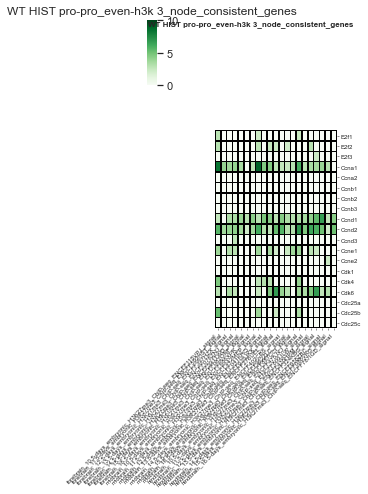

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


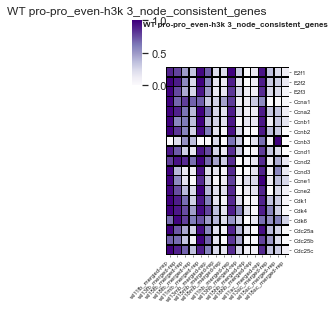

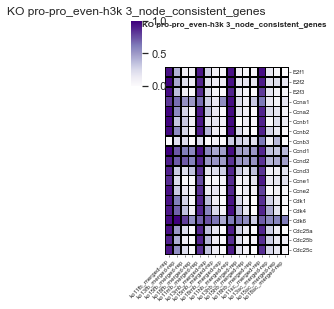

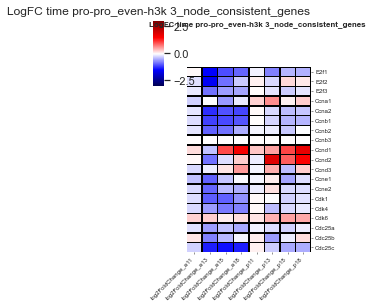

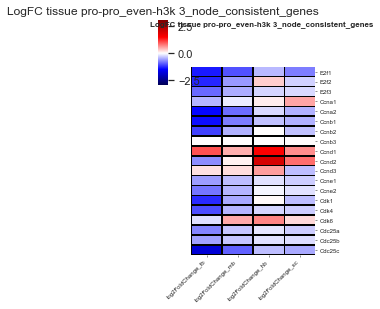

--------------------------------------------------------------------------------
                   pro-pro_even-h3k	Number of marked genes:	                    
--------------------------------------------------------------------------------
12 20


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice


In [43]:
genes = ['E2f1', 'E2f2', 'E2f3', 'Ccna1', 'Ccna2', 'Ccnb1', 'Ccnb2', 'Ccnb3',  'Ccnd1', 'Ccnd2', 'Ccnd3', 
          'Ccne1', 'Ccne2', 'Cdk1', 'Cck2', 'Cdk4', 'Cdk6',
         'Cdc25a', 'Cdc25b', 'Cdc25c']
genes2 = [] 
genes4 = [] 
genes3 = []

tst_lbl = 'pro-pro_even-h3k'
values = df_all[H3k_cols].values[desc_sorted]
plot_gene_heatmap(df_all, genes, genes2, genes4, genes3,
                  H3k_cols, vae_data, vae_mse,
                  gene_name, mark='H3K27me3', method='input', 
                  title=f'WT HIST {tst_lbl} {experiment_name}', cmap=hist_cmap, 
                  genes=gene_names_sorted, values=values)


# Normalise so we can better see changes across the gene
x = df_all[wt_cols + ko_cols].values #returns a numpy array
x = ((x.T - np.min(x, axis=1))/(np.max(x, axis=1) - np.min(x, axis=1))).T
df_norm = pd.DataFrame(x)
df_norm.columns = wt_cols + ko_cols
df_norm[gene_name] = df_all[gene_name].values
values = df_norm[wt_cols].values[desc_sorted]
plot_gene_heatmap(df_norm, genes, genes2, genes4, genes3,
                  wt_cols, all_vae_data, vae_mse,
                  gene_name, mark='H3K27me3', merge_reps=False, cmap=rna_cmap,
                  method='input', title=f'WT {tst_lbl} {experiment_name}', 
                  genes=gene_names_sorted, values=values, v_min=0, v_max=1)

values = df_norm[ko_cols].values[desc_sorted]
plot_gene_heatmap(df_norm, genes, genes2, genes4, genes3,
                  ko_cols, all_vae_data, vae_mse,
                  gene_name, mark='H3K27me3', merge_reps=False, cmap=rna_cmap,
                  method='input', title=f'KO {tst_lbl} {experiment_name}', 
                  genes=gene_names_sorted, values=values, v_min=0, v_max=1)

logfc = [c for c in df_all.columns if 'log2Fold' in c and  ('a1' in c or 'p1' in c)]
values = df_all[logfc].values[desc_sorted]
plot_gene_heatmap(df_all, genes, genes2, genes4, genes3,
                  logfc, all_vae_data, vae_mse,
                  gene_name, mark='H3K27me3', merge_reps=False, cmap=div_cmap,
                  method='input', title=f'LogFC time {tst_lbl} {experiment_name}', 
                  genes=gene_names_sorted, values=values)

logfc = [c for c in df_all.columns if 'log2Fold' in c and ('a1' not in c and 'p1' not in c)]
values = df_all[logfc].values[desc_sorted]
plot_gene_heatmap(df_all, genes, genes2, genes4, genes3,
                  logfc, all_vae_data, vae_mse,
                  gene_name, mark='H3K27me3', merge_reps=False, cmap=div_cmap,
                  method='input', title=f'LogFC tissue {tst_lbl} {experiment_name}', 
                  genes=gene_names_sorted, values=values)


h3k_cols = [c for c in df_all if 'H3K27me3' in c and 'median' not in c and 'signal' in c and 'brain' in c]
h3k_const_aff = df_all[np.nanmean(df_all[h3k_cols].values, axis=1) > 0][gene_name].values
u = SciUtil()
u.dp([tst_lbl, 'Number of marked genes:'])
print(len(set(genes) & set(h3k_const_aff)), len(set(genes)))

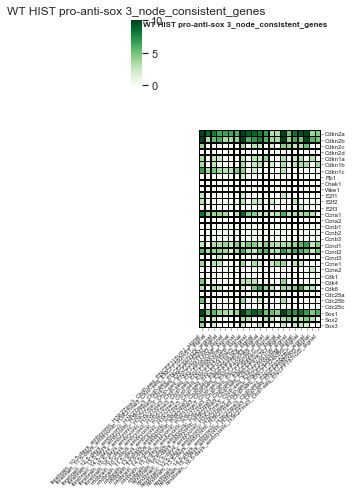

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


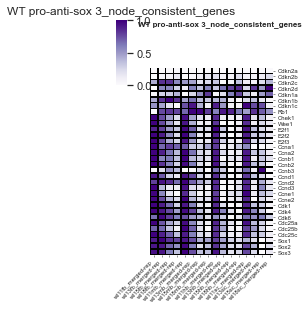

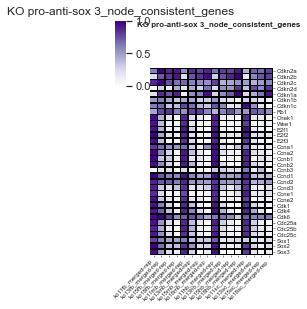

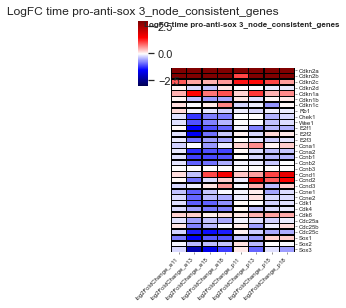

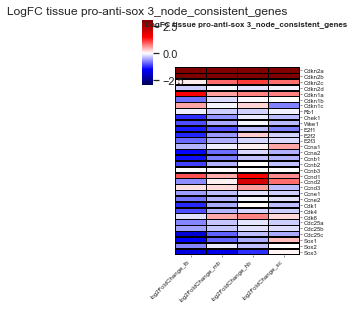

--------------------------------------------------------------------------------
                     pro-anti-sox	Number of marked genes:	                      
--------------------------------------------------------------------------------
22 33


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice


In [44]:
pro_prolif_genes = ['E2f1', 'E2f2', 'E2f3', 'Ccna1', 'Ccna2', 'Ccnb1', 'Ccnb2', 'Ccnb3',  'Ccnd1', 'Ccnd2', 'Ccnd3', 
          'Ccne1', 'Ccne2', 'Cdk1', 'Cck2', 'Cdk4', 'Cdk6',
         'Cdc25a', 'Cdc25b', 'Cdc25c']
anti_prolif_genes = ['Cdkn2a', 'Cdkn2b', 'Cdkn2c', 'Cdkn2d', 'Cdkn1a', 'Cdkn1b',  'Cdkn1c', 'Rb1','Chek1', 'Wee1']

genes = anti_prolif_genes + pro_prolif_genes + ['Sox1', 'Sox2', 'Sox3']
genes2 = [] 
genes4 = [] 
genes3 = []

tst_lbl = 'pro-anti-sox'
values = df_all[H3k_cols].values[desc_sorted]
plot_gene_heatmap(df_all, genes, genes2, genes4, genes3,
                  H3k_cols, vae_data, vae_mse,
                  gene_name, mark='H3K27me3', method='input', 
                  title=f'WT HIST {tst_lbl} {experiment_name}', cmap=hist_cmap, 
                  genes=gene_names_sorted, values=values)


# Normalise so we can better see changes across the gene
x = df_all[wt_cols + ko_cols].values #returns a numpy array
x = ((x.T - np.min(x, axis=1))/(np.max(x, axis=1) - np.min(x, axis=1))).T
df_norm = pd.DataFrame(x)
df_norm.columns = wt_cols + ko_cols
df_norm[gene_name] = df_all[gene_name].values
values = df_norm[wt_cols].values[desc_sorted]
plot_gene_heatmap(df_norm, genes, genes2, genes4, genes3,
                  wt_cols, all_vae_data, vae_mse,
                  gene_name, mark='H3K27me3', merge_reps=False, cmap=rna_cmap,
                  method='input', title=f'WT {tst_lbl} {experiment_name}', 
                  genes=gene_names_sorted, values=values, v_min=0, v_max=1)

values = df_norm[ko_cols].values[desc_sorted]
plot_gene_heatmap(df_norm, genes, genes2, genes4, genes3,
                  ko_cols, all_vae_data, vae_mse,
                  gene_name, mark='H3K27me3', merge_reps=False, cmap=rna_cmap,
                  method='input', title=f'KO {tst_lbl} {experiment_name}', 
                  genes=gene_names_sorted, values=values, v_min=0, v_max=1)

logfc = [c for c in df_all.columns if 'log2Fold' in c and  ('a1' in c or 'p1' in c)]
values = df_all[logfc].values[desc_sorted]
plot_gene_heatmap(df_all, genes, genes2, genes4, genes3,
                  logfc, all_vae_data, vae_mse,
                  gene_name, mark='H3K27me3', merge_reps=False, cmap=div_cmap,
                  method='input', title=f'LogFC time {tst_lbl} {experiment_name}', 
                  genes=gene_names_sorted, values=values)

logfc = [c for c in df_all.columns if 'log2Fold' in c and ('a1' not in c and 'p1' not in c)]
values = df_all[logfc].values[desc_sorted]
plot_gene_heatmap(df_all, genes, genes2, genes4, genes3,
                  logfc, all_vae_data, vae_mse,
                  gene_name, mark='H3K27me3', merge_reps=False, cmap=div_cmap,
                  method='input', title=f'LogFC tissue {tst_lbl} {experiment_name}', 
                  genes=gene_names_sorted, values=values)


h3k_cols = [c for c in df_all if 'H3K27me3' in c and 'median' not in c and 'signal' in c and 'brain' in c]
h3k_const_aff = df_all[np.nanmean(df_all[h3k_cols].values, axis=1) > 0][gene_name].values
u = SciUtil()
u.dp([tst_lbl, 'Number of marked genes:'])
print(len(set(genes) & set(h3k_const_aff)), len(set(genes)))

In [45]:
len(set(df_training[gene_name].values) & set(pro_prolif_genes))

5

In [46]:
set(df_training[gene_name].values) & set(pro_prolif_genes)

{'Ccna2', 'Ccnb1', 'Ccnd1', 'Cdc25c', 'E2f1'}

In [47]:
# Check which group these fell into & they all fall into the pro-prolif cluster
set(gene_sets[1]) & set(pro_prolif_genes)

{'Ccna2', 'Ccnb1', 'Ccnd1', 'Cdc25c', 'E2f1'}

In [48]:
len(set(df_training[gene_name].values) & set(anti_prolif_genes))

3

In [49]:
set(df_training[gene_name].values) & set(anti_prolif_genes)


{'Cdkn1a', 'Cdkn2a', 'Cdkn2b'}

In [50]:
# Check which group these fell into
set(gene_sets[2]) & set(anti_prolif_genes)

{'Cdkn2a', 'Cdkn2b'}

## Print out the average H3K mark for each gene



In [51]:
mean_h3k = np.nanmax(-1 * df_sig[logfc].values, axis=1)
log_fc = df_sig[logfc].values
desc_sorted = (mean_h3k).argsort()  # Sort the genes by descending order
mean_h3k = mean_h3k[desc_sorted]
gene_names_sorted = df_sig[gene_name].values[desc_sorted]
h3k = np.nanmedian(df_sig[h3k_cols].values, axis=1)[desc_sorted]

genes = ['Ccna1', 'Ccna2', 'Ccnb1', 'Ccnb2', 'Ccnb3', 'Cdc25a', 'Cdc25b', 'Cdc25c', 'Ccnd1', 'Ccnd2', 'Ccnd3', 'Ccne1', 'Ccne2',  'E2f1', 'E2f2', 'E2f3', 'Cdk2', 'Cdk4', 'Cdk6']

genes = ['Cdkn1a', 'Cdkn1b', 'Cdkn2a', 'Cdkn1c', 'Cdkn2b', 'Cdkn2c', 'Cdkn2d']
for i, g in enumerate(gene_names_sorted):
    if g in genes:
        print(g, mean_h3k[i], h3k[i])
        

Cdkn2a -7.68183143582525 8.03731
Cdkn2b -3.51203714613558 5.71146
Cdkn1a -0.5495372639944189 3.04388
Cdkn2c -0.110017150923737 3.42122
Cdkn2d 0.298684125045697 nan
Cdkn1c 0.7476729958524408 3.74455
Cdkn1b 0.8321717646928408 3.30582


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


# Figure 6 D plot the expression over tissues

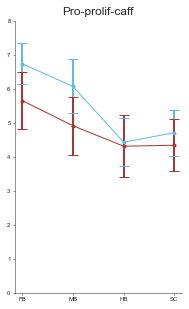

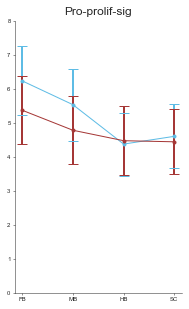

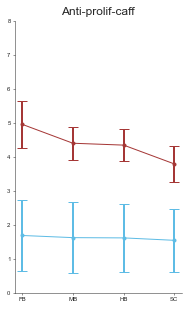

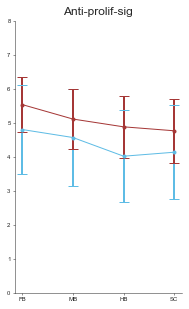

In [52]:
genes = pro_prolif_genes
gene_idxs, gene_names = get_gis(genes, df_training)
plot_tissue_line(w_e13_cols, gene_idxs, gene_names, df_training, 'Pro-prolif-caff', e13_cols)
gene_idxs, gene_names = get_gis(genes, df_sig)
plot_tissue_line(w_e13_cols, gene_idxs, gene_names, df_sig, 'Pro-prolif-sig', e13_cols)

# Do the anti prolif const aff
genes = anti_prolif_genes
gene_idxs, gene_names = get_gis(genes, df_training)
plot_tissue_line(w_e13_cols, gene_idxs, gene_names, df_training, 'Anti-prolif-caff', e13_cols)

# Do the anti prolif sig aff
gene_idxs, gene_names = get_gis(genes, df_sig)
plot_tissue_line(w_e13_cols, gene_idxs, gene_names, df_sig, 'Anti-prolif-sig', e13_cols)




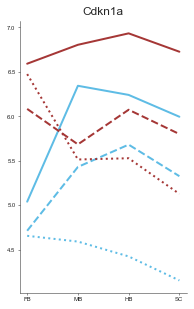

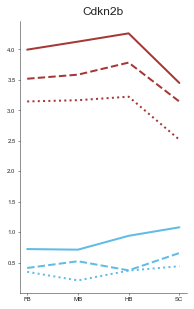

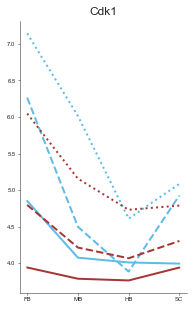

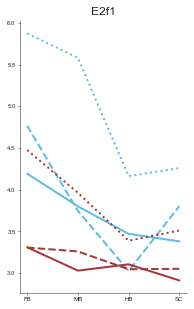

In [53]:
def plot_tissue_line(w_e18_cols, gene_idxs, gene_names, df_training, title='', ko_e18_cols=None):
    labels_lst = []
    c_i = 5
    wt_colour = '#5ebce5'
    fig, ax = plt.subplots()
    for i, g in enumerate(gene_names):
        ax.plot(['FB', 'MB', 'HB', 'SC'], df_training[w_e13_cols].values[gene_idxs[i]], c=wt_colour, linewidth=2.0, linestyle="dotted")
        ax.plot(['FB', 'MB', 'HB', 'SC'], df_training[w_e15_cols].values[gene_idxs[i]], c=wt_colour, linewidth=2.0, linestyle="dashed")
        ax.plot(['FB', 'MB', 'HB', 'SC'], df_training[w_e18_cols].values[gene_idxs[i]], c=wt_colour, linewidth=2.0)

        labels_lst.append(f'WT {g}')
        if ko_e18_cols:
            labels_lst.append(f'Eed-cKO {g}')
            ax.plot(['FB', 'MB', 'HB', 'SC'], df_training[e13_cols].values[gene_idxs[i]], label=g, c=ko_colour, linewidth=2.0, linestyle="dotted")
            ax.plot(['FB', 'MB', 'HB', 'SC'], df_training[e15_cols].values[gene_idxs[i]], label=g, c=ko_colour, linewidth=2.0, linestyle="dashed")
            ax.plot(['FB', 'MB', 'HB', 'SC'], df_training[e18_cols].values[gene_idxs[i]], label=g, c=ko_colour, linewidth=2.0)

        c_i += 1
        if c_i == len(sci_colour):
            c_i = 0
        
    plt.title(f'{title}')
    ax.tick_params(labelsize=6)
    set_ax_params(ax)
    save_fig(f'line_time_{title}')
    plt.show()
    
for g in ['Cdkn1a', 'Cdkn2b']:
    genes = [g]
    gene_idxs, gene_names = get_gis(genes, df_sig)
    plot_tissue_line(w_e18_cols, gene_idxs, gene_names, df_sig, g, e18_cols)
    
for g in ['Cdk1', 'E2f1']:
    genes = [g] 
    gene_idxs, gene_names = get_gis(genes, df_sig)
    plot_tissue_line(w_e18_cols, gene_idxs, gene_names, df_sig, g, e18_cols)


## Figure 6 C and Suppl figure 11

### Plot human relationships 

#### Map between human and mouse


In [54]:
from scibiomart import SciBiomart

annot_df = pd.read_csv(os.path.join(supp_dir, 'mm10Sorted_mmusculus_gene_ensembl-GRCm38.p6.csv'))
gene_names = annot_df[gene_name].values
gene_name_to_ens_id = {}
for i, g in enumerate(annot_df['ensembl_gene_id'].values):
    if not gene_name_to_ens_id.get(gene_names[i]):
        gene_name_to_ens_id[gene_names[i]] = g
        

sb = SciBiomart()
sb.set_mart('ENSEMBL_MART_ENSEMBL')
sb.set_dataset('hsapiens_gene_ensembl')
attributes = ['ensembl_gene_id', 'mmusculus_homolog_ensembl_gene', 'mmusculus_homolog_perc_id_r1']
results = sb.run_query({}, attributes)

# Make a list of the genes that map
human_mouse_values = []
mouse_human_dict = {}

# Filter the results to include only those that have Not Nones in they're mmusculus_homolog_ensembl_gene
results_NN = results[results['mmusculus_homolog_ensembl_gene'] != None]
mmusculus_homolog_ensembl_gene = results_NN['mmusculus_homolog_ensembl_gene'].values
similarity = results_NN['mmusculus_homolog_perc_id_r1'].values

i = 0
count = 0
human_mouse_dict = {}
mouse_human_dict = {}
for g in results_NN['ensembl_gene_id'].values:
    if mmusculus_homolog_ensembl_gene[i] != None:
        if similarity[i] is not None and float(similarity[i]) > 80:  ## Only keep them if the similarlity is > 0.5
            human_mouse_dict[g] =  mmusculus_homolog_ensembl_gene[i]
            mouse_human_dict[mmusculus_homolog_ensembl_gene[i]] = g
            count += 1
    i += 1

len(mouse_human_dict)
genes = df_all[gene_name].values
human_genes = []
mm_grps = []
for g in genes:
    ens = gene_name_to_ens_id.get(g)
    if ens is not None:
        # Now try get human
        hu = mouse_human_dict.get(ens)
        if hu:
            human_genes.append(hu)
            mm_grps.append(g)
print(len(genes), len(human_genes))

hu_grps = []
mm_n_grps = []

for i in range(0, n_clusters):
    genes = df[gene_name].values[vae_set_idxs[i]]
    human_genes = []
    mm_grps = []
    for g in genes:
        ens = gene_name_to_ens_id.get(g)
        if ens is not None:
            # Now try get human
            hu = mouse_human_dict.get(ens)
            if hu:
                human_genes.append(hu)
                mm_grps.append(g)
    print(len(genes), len(human_genes))
    hu_grps.append(human_genes)

    mm_n_grps.append(mm_grps)
    


20900 11385
62 23
180 124
80 62
223 71
156 122
121 77


## Download human gene info from PsychEncode

http://development.psychencode.org/#

https://science.sciencemag.org/content/362/6420/eaat7615

ensembl_gene_id
gene_symbol


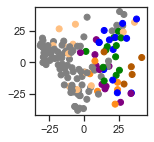

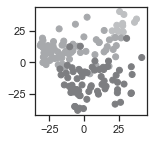

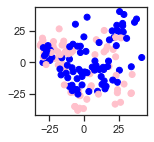

In [92]:
from statannot import add_stat_annotation

human_b = pd.read_csv(supp_dir + 'genes_matrix_csv/expression_matrix.csv', header=None)
human_rm = pd.read_csv(supp_dir + 'genes_matrix_csv/rows_metadata.csv')
human_cm = pd.read_csv(supp_dir + 'genes_matrix_csv/columns_metadata.csv')

# Great now find these in our embryonic and plot box plots
hu_idxs = [[], [], [], [], [], []]
for i, g in enumerate(human_rm['ensembl_gene_id'].values):
    for gi, genes in enumerate(hu_grps):
        if g in genes:
            hu_idxs[gi].append(i)
            break

ages = human_cm['age'].values
gender = human_cm['gender'].values
regions = human_cm['structure_acronym'].values
col_names = ['row-id']
donor_id = human_cm['donor_id'].values

# Rename columns to early, mid, w1 = e8, 9, w2 = 12, 13, w3 = 16, 17, w4 = > 17
for i, r in enumerate(regions):
    a = int(ages[i].split(' ')[0])
    stage = 0
    if a < 23:
        if a > 18:
            stage = 'W4'
        elif a > 13:
            stage = 'W3'
        elif a > 9:
            stage = 'W2'
        else:
            stage = 'W1'
    else:
        stage = 'NA'
    cn = regions[i] + '_' + ages[i].replace(' ', '-') + '_' + stage + '_' + gender[i]  + '_' + str(donor_id[i])
    col_names.append(cn)

human_b.columns = col_names
tissue_c = ['MFC', 'OFC', 'DFC', 'NFC', 'M1C', 'S1C', 'IPC', 'A1C', 'STC', 'ITC', 'V1C', 'HIP', 'AMY', 'STR', 'MD', 'CBC']
human_emb = human_b[[c for c in human_b.columns if 'pcw' in c and ('OFC' in c or 'MD' in c or 'CBC' in c or
                                                                  'MFC' in c or 'DFC' in c or 'M1C' in c or
                                                                  'S1C' in c or 'IPC' in c or 'A1C' in c or
                                                                  'STC' in c or 'V1C' in c or 'HIP' in c or
                                                                  'HIP' in c or 'AMY' in c or 'STR' in c)]]

human_emb = human_emb[[c for c in human_emb if 'W1' in c or 'W2' in c or 'W3' in c or 'W4' in c]]
human_emb['ensembl_gene_id'] = human_rm['ensembl_gene_id'].values
human_emb['gene_symbol'] = human_rm['gene_symbol'].values
human_emb['entrez_id'] = human_rm['entrez_id'].values

human_emb_log = pd.DataFrame()
human_emb_num = pd.DataFrame()
human_emb_log['ensembl_gene_id'] = human_emb['ensembl_gene_id'].values
human_emb_log['gene_symbol'] = human_emb['gene_symbol'].values
human_emb = human_emb.fillna(0)
for c in human_emb.columns:
    if 'entrez_id' not in c:
        try:
            human_emb_log[c] = np.log2(human_emb[c].values + 1)
            human_emb_num[c] = np.log2(human_emb[c].values + 1)
        except:
            print(c)
    
    
def plot_hu_gene_boxplot(df, title, cluster_id, cols, idxs, ylim=10):
    idxs = idxs
    boxplot = Boxplot(df, 'ensembl_gene_id', cols[0])
    box_df = boxplot.format_data_for_boxplot(df, cols, 'ensembl_gene_id', df['ensembl_gene_id'].values[idxs])
    print(box_df)
    boxplot = Boxplot(box_df, "Conditions", "Values", add_stats=False, add_dots=False, figsize=(3.5,3), 
                       order=cols, title_font_size=12, label_font_size=10)
    boxplot.palette = 'Greys'

    ax = boxplot.plot()
    plt.title(title)
    ax.set_ylim(0, ylim)

    save_fig(f'{title}')
    
    plt.show()


""" PCA of the human embryo samples. """

pca_vae = PCA(n_components=2)  # make sure we have the same components as the VAE to keep the test fair
pca_values = pca_vae.fit_transform(np.log2(human_emb_num.values.T + 1))

reg_cols = []
t_col = []
g_col = []
for c in human_emb_num.columns:
    if 'OFC' in c:
        reg_cols.append(fb_colour)
    elif 'MD' in c:
        reg_cols.append(mb_colour)
    elif 'CBC' in c:
        reg_cols.append(hb_colour)
    elif 'HIP' in c:
        reg_cols.append('blue')
    elif 'AMY' in c:
        reg_cols.append('green')
    elif 'STR' in c:
        reg_cols.append('purple')
    else:
        reg_cols.append('grey')
    tc = int(c.split('_')[1].split('-')[0])
    if tc < 12:
        t_col.append(e11_colour)
    elif tc < 16:
        t_col.append(e13_colour) 
    elif tc < 22:
        t_col.append(e15_colour) 
    else:
        t_col.append(e18_colour) 
    if '_F' in c:
        g_col.append('pink')
    else:
        g_col.append('blue')
        
# Plot the scatter to see how different features distribute
plt.scatter(pca_values[:,0], pca_values[:,1], c=reg_cols)
plt.show()

plt.scatter(pca_values[:,0], pca_values[:,1], c=t_col)
plt.show()

plt.scatter(pca_values[:,0], pca_values[:,1], c=g_col)
plt.show()

OFC_cols = [c for c in human_emb.columns if 'OFC' in c]


In [89]:
human_emb_log

,ensembl_gene_id,M1C-S1C_8-pcw_W1_M_13058,AMY_8-pcw_W1_M_13058,STC_8-pcw_W1_M_13058,MFC_8-pcw_W1_M_13058,DFC_8-pcw_W1_M_13058,OFC_8-pcw_W1_M_13058,HIP_8-pcw_W1_M_13058,DFC_9-pcw_W1_M_12833,MFC_9-pcw_W1_M_12833,...,STR_21-pcw_W4_M_12886,HIP_21-pcw_W4_M_12886,STC_21-pcw_W4_M_12886,AMY_21-pcw_W4_M_12886,OFC_21-pcw_W4_M_12886,V1C_21-pcw_W4_M_12886,S1C_21-pcw_W4_M_12886,CBC_21-pcw_W4_M_12886,IPC_21-pcw_W4_M_12886,DFC_21-pcw_W4_M_12886
0,ENSG00000000003,4.658283,4.345572,4.392196,5.510576,5.521802,5.395223,5.465784,4.494295,4.783054,...,2.602484,3.667828,2.334590,3.493178,2.634903,2.368104,2.763223,4.658924,2.759084,2.649112
1,ENSG00000000005,0.094017,0.000000,0.245116,0.559571,0.240278,0.709593,0.219024,0.036132,0.381775,...,0.000000,0.255339,0.063268,0.069246,0.000000,0.055877,0.030984,0.027465,0.031847,0.029546
2,ENSG00000000419,4.443982,4.302681,4.338313,5.083345,5.291219,4.924644,4.762361,3.941343,4.060981,...,3.438405,3.679270,3.477006,3.585259,3.739682,3.402245,3.734706,3.848757,3.404826,3.432339
3,ENSG00000000457,2.386127,1.828561,1.981479,2.164727,2.204714,2.099991,2.188094,2.269607,2.093797,...,1.591888,1.819427,1.619428,2.016935,1.762692,1.713625,2.105873,2.040976,1.795873,1.700910
4,ENSG00000000460,2.176576,1.603029,1.667772,2.245368,2.189239,1.927843,2.255301,2.384130,2.298386,...,0.776340,1.026578,0.702341,1.061453,0.861974,0.820011,1.061190,1.632712,0.776458,0.958698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52371,ENSGR0000237040,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
52372,ENSGR0000237531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
52373,ENSGR0000237801,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
52374,ENSGR0000248421,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [139]:
def plot_mm_gene_boxplot(df, title, cluster_id, cols, idxs, ylim=10, colours=None):
    idxs = idxs
    boxplot = Boxplot(df, 'ensembl_gene_id', cols[0])
    box_df = boxplot.format_data_for_boxplot(df, cols, gene_name, df[gene_name].values[idxs])

    boxplot = Violinplot(box_df, "Conditions", "Values", add_stats=True, add_dots=True, figsize=(2,2), 
                       order=cols, title_font_size=7, label_font_size=6)
    boxplot.palette = colours

    ax = boxplot.plot()
    plt.title(title)
    #ax.set_ylim(0, 12)

    save_fig(f'{title}')
    
    plt.show()

    
def plot_hu_gene_boxplot(df, title, cluster_id, cols, idxs, ylim=10, colours=None):
    idxs = idxs
    boxplot = Boxplot(df, 'ensembl_gene_id', cols[0])
    box_df = boxplot.format_data_for_boxplot(df, cols, 'ensembl_gene_id', df['ensembl_gene_id'].values[idxs])

    boxplot = Violinplot(box_df, "Conditions", "Values", add_stats=True, add_dots=True, figsize=(2,2), 
                       order=cols, title_font_size=7, label_font_size=6)
    boxplot.palette = colours

    ax = boxplot.plot()
    plt.title(title)
    #ax.set_ylim(0, 12)

    save_fig(f'{title}')
    
    plt.show()
    
def mouse_gene_tst(df, gene_lst, label, brain_tissue='', time_m='', anterior_regions=False):
    """ Plot the genes """
    wt_cols = [gene_name]
    # ----------------------------------
    # First we test for the tissue sig (collect the ones meeting the brain tissue)
    # and test across time points.
    # ----------------------------------
    
    if anterior_regions:
        for c in df.columns:
            if 'wt' in c and 'merged' not in c and ('fb' in c or 'mb' in c):
                wt_cols.append(c)
    else:
        for c in df.columns:
            if 'wt' in c and 'merged' not in c and brain_tissue in c:
                wt_cols.append(c)
    print(wt_cols)
    # Plot gene boxplot
    wt_df = df[wt_cols]

    g2_idxs = []
    for i, g in enumerate(df[gene_name].values):
        if g in gene_lst:
            g2_idxs.append(i)

    plot_mm_gene_boxplot(wt_df, f'{label} in time {brain_tissue} {time_m} mouse', i, ['11', '13', '15', '18'], g2_idxs, 
                         0, colours=[e11_colour, e13_colour, e15_colour, e18_colour])

    # ----------------------------------
    # Next we test for the WT vs KO sig (tissue and time must be included)
    # and test across conditions.
    # ----------------------------------
    wt_cols = [gene_name]
    for c in df.columns:
        if 'merged' not in c and brain_tissue in c and '11' not in c and time_m in c:
            wt_cols.append(c)

    # Plot gene boxplot
    wt_df = df[wt_cols]
    plot_mm_gene_boxplot(wt_df, f'{label}  wt-ko in {brain_tissue} {time_m} mouse', i, ['wt', 'ko'], g2_idxs, 0, 
                        colours=[wt_colour, ko_colour])

    # ----------------------------------
    # Lastly compare against the time points, here we want 
    # to test significances across tissues. (do this from E13-E18 as per DE)
    # ----------------------------------
    g2_idxs = []
    for i, g in enumerate(df[gene_name].values):
        if g in gene_lst:
            g2_idxs.append(i)

    wt_cols = [gene_name]
    for c in df.columns:
        if 'wt' in c and 'merged' not in c and '11' not in c:
            wt_cols.append(c)
    wt_df = df[wt_cols]
    plot_mm_gene_boxplot(wt_df, f'Test for {label} in mouse', i, ['fb', 'mb', 'hb', 'sc'], 
                         g2_idxs, 0, colours=[fb_colour, mb_colour, hb_colour, sc_colour])



def human_gene_tst(df, gene_lst, label, human_brain_tissue='', human_time=''):
    # Make a new DF
    human_emb_a = pd.DataFrame()
    tissue_c = ['DFC', 'HIP', 'STR', 'CBC']
    human_emb_a['ensembl_gene_id'] = human_emb['ensembl_gene_id'].values
    for c in human_emb_log.columns:
        if human_brain_tissue in c:
            human_emb_a[c] = human_emb_log[c].values

    genes = human_emb_log['gene_symbol'].values

    g2m_genes = []
    for g in gene_lst:
        ens = gene_name_to_ens_id.get(g)
        if ens is not None:
            # Now try get human
            hu = mouse_human_dict.get(ens)
            if hu:
                g2m_genes.append(hu)
    print(g2m_genes)
    g2_idxs = []
    for i, g in enumerate(human_emb_log['ensembl_gene_id'].values):
        if g in g2m_genes:
            g2_idxs.append(i)

    # Boxplot of genes for Time points in OFC
    plot_hu_gene_boxplot(human_emb_a, f'Test for {label} in ages {human_brain_tissue} of Human embryos',
                         i, ['W1', 'W2', 'W3', 'W4'], 
                         g2_idxs, 0, colours=[e11_colour, e13_colour, e15_colour, e18_colour])

    human_emb_a = pd.DataFrame()
    human_emb_a['ensembl_gene_id'] = human_emb_log['ensembl_gene_id'].values
    tissue_c = ['DFC', 'HIP', 'STR', 'CBC']    
    for c in human_emb.columns:
        if c.split('_')[0] in tissue_c and human_time in c:
            human_emb_a[c] = human_emb_log[c].values
    genes = human_emb_log['gene_symbol'].values
    g2_idxs = []
    for i, g in enumerate(human_emb_log['ensembl_gene_id'].values):
        if g in g2m_genes:
            g2_idxs.append(i)

    plot_hu_gene_boxplot(human_emb_a, f'Test for {label} in tissue of Human embryos', i, tissue_c, g2_idxs, 0, 
                        colours=[fb_colour, mb_colour, hb_colour])


    


['ENSG00000134057', 'ENSG00000101412', 'ENSG00000145386', 'ENSG00000110092']
p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

W1 v.s. W2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.942e-04 U_stat=1.920e+02
W2 v.s. W3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.423e-02 U_stat=1.040e+02
W3 v.s. W4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.224e-01 U_stat=9.600e+01
W1 v.s. W3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.050e-04 U_stat=1.280e+02
W2 v.s. W4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.090e+02
W1 v.s. W4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.635e-03 U_stat=6.400e+01


No handles with labels found to put in legend.


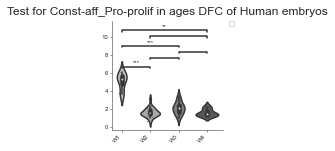

p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

DFC v.s. HIP: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.809e-06 U_stat=6.640e+02
HIP v.s. STR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.340e-05 U_stat=1.887e+03
STR v.s. CBC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.645e-04 U_stat=1.760e+02
DFC v.s. STR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.141e-01 U_stat=1.124e+03
HIP v.s. CBC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.160e+02
DFC v.s. CBC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.269e-04 U_stat=1.990e+02


No handles with labels found to put in legend.


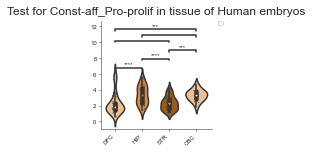

['external_gene_name', 'wt11fb1', 'wt11fb2', 'wt13fb1', 'wt13fb2', 'wt15fb1', 'wt15fb2', 'wt18fb1', 'wt18fb2', 'wt11mb1', 'wt11mb2', 'wt13mb1', 'wt13mb2', 'wt15mb1', 'wt15mb2', 'wt18mb1', 'wt18mb2']
p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

11 v.s. 13: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.891e-01 U_stat=2.800e+02
13 v.s. 15: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.891e-01 U_stat=2.800e+02
15 v.s. 18: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.191e-01 U_stat=2.580e+02


No handles with labels found to put in legend.


11 v.s. 15: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.659e-04 U_stat=3.400e+02
13 v.s. 18: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.696e-03 U_stat=3.210e+02
11 v.s. 18: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.614e-05 U_stat=3.740e+02


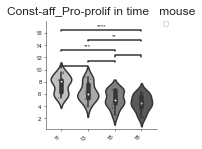

No handles with labels found to put in legend.


p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

wt v.s. ko: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.336e-02 U_stat=8.531e+03


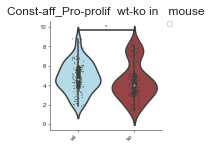

p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

fb v.s. mb: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.959e-01 U_stat=5.950e+02
mb v.s. hb: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.007e-01 U_stat=5.830e+02
hb v.s. sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.890e+02
fb v.s. hb: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.783e-04 U_stat=7.260e+02
mb v.s. sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.250e+02
fb v.s. sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.377e-03 U_stat=6.790e+02


No handles with labels found to put in legend.


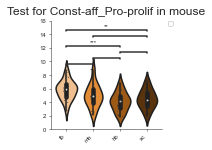

In [140]:
genes =[
    'Ccnb1',
    'Cdc25c',
    'E2f1',
    'Ccna2',
    'Ccnd1',
] # Caff sig affected pro-prolif genes

human_gene_tst(df_sig, genes, 'Const-aff_Pro-prolif', 'DFC')
mouse_gene_tst(df_sig, genes, 'Const-aff_Pro-prolif', '', '', anterior_regions=True)

['ENSG00000101412', 'ENSG00000007968', 'ENSG00000112242', 'ENSG00000133101', 'ENSG00000145386', 'ENSG00000134057', 'ENSG00000157456', 'ENSG00000110092', 'ENSG00000118971', 'ENSG00000112576', 'ENSG00000175305', 'ENSG00000135446', 'ENSG00000105810', 'ENSG00000164045', 'ENSG00000101224']
p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

W1 v.s. W2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.538e-10 U_stat=2.451e+03
W2 v.s. W3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.163e-01 U_stat=2.090e+03
W3 v.s. W4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.168e-01 U_stat=1.101e+03
W1 v.s. W3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.012e-08 U_stat=1.570e+03
W2 v.s. W4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.390e+03


No handles with labels found to put in legend.


W1 v.s. W4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.157e-07 U_stat=8.070e+02


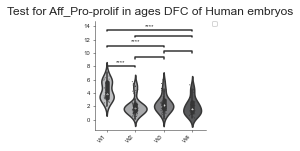

p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

DFC v.s. HIP: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.293e-08 U_stat=1.343e+04
HIP v.s. STR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.138e-07 U_stat=2.326e+04
STR v.s. CBC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.600e-05 U_stat=4.371e+03
DFC v.s. STR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.750e+04
HIP v.s. CBC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.189e+03
DFC v.s. CBC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.501e-05 U_stat=4.990e+03


No handles with labels found to put in legend.


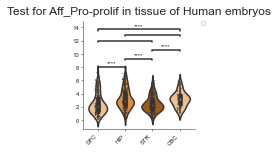

['external_gene_name', 'wt11fb1', 'wt11fb2', 'wt13fb1', 'wt13fb2', 'wt15fb1', 'wt15fb2', 'wt18fb1', 'wt18fb2']
p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

11 v.s. 13: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.138e-01 U_stat=7.810e+02
13 v.s. 15: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.346e-01 U_stat=8.080e+02
15 v.s. 18: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.593e-01 U_stat=8.280e+02


No handles with labels found to put in legend.


11 v.s. 15: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.515e-03 U_stat=9.350e+02
13 v.s. 18: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.007e-03 U_stat=9.670e+02
11 v.s. 18: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.719e-04 U_stat=1.020e+03


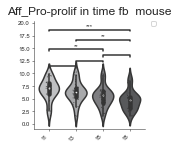

No handles with labels found to put in legend.


p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

wt v.s. ko: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.989e-03 U_stat=7.196e+03


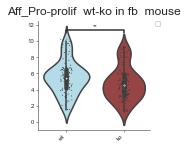

p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

fb v.s. mb: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.311e-02 U_stat=7.107e+03
mb v.s. hb: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.811e-01 U_stat=6.828e+03
hb v.s. sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.247e+03
fb v.s. hb: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.915e-06 U_stat=8.043e+03
mb v.s. sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.254e+03
fb v.s. sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.667e-03 U_stat=7.502e+03


No handles with labels found to put in legend.


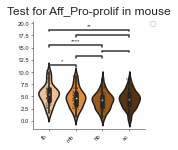

In [141]:
genes = ['E2f1', 'E2f2', 'E2f3', 'Ccna1', 'Ccna2', 'Ccnb1', 'Ccnb2', 'Ccnb3',  'Ccnd1', 'Ccnd2', 'Ccnd3', 
          'Ccne1', 'Ccne2', 'Cdk1', 'Cck2', 'Cdk4', 'Cdk6',
         'Cdc25a', 'Cdc25b', 'Cdc25c']
human_gene_tst(df_sig, genes, 'Aff_Pro-prolif', 'DFC')
mouse_gene_tst(df_sig, genes, 'Aff_Pro-prolif', 'fb', '', anterior_regions=False)

['ENSG00000112333', 'ENSG00000153266', 'ENSG00000187821', 'ENSG00000180613', 'ENSG00000135638', 'ENSG00000163508']
p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

W1 v.s. W2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.630e+02
W2 v.s. W3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.040e+02
W3 v.s. W4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.570e+02
W1 v.s. W3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.825e+02
W2 v.s. W4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.130e+02
W1 v.s. W4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.647e-01 U_stat=1.000e+02


No handles with labels found to put in legend.


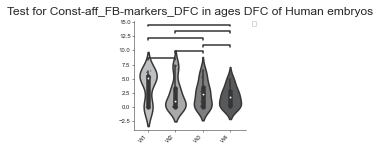

p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

DFC v.s. HIP: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.706e-01 U_stat=2.720e+03
HIP v.s. STR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.199e-05 U_stat=4.018e+03
STR v.s. CBC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.122e-04 U_stat=1.662e+03
DFC v.s. STR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.983e-01 U_stat=3.576e+03
HIP v.s. CBC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.902e-05 U_stat=1.811e+03
DFC v.s. CBC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.876e-03 U_stat=1.815e+03


No handles with labels found to put in legend.


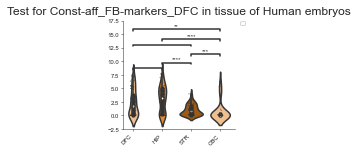

['external_gene_name', 'wt11fb1', 'wt11fb2', 'wt13fb1', 'wt13fb2', 'wt15fb1', 'wt15fb2', 'wt18fb1', 'wt18fb2']
p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

11 v.s. 13: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.070e+02
13 v.s. 15: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.490e+02
15 v.s. 18: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.380e+02
11 v.s. 15: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.440e+02
13 v.s. 18: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.992e-01 U_stat=2.730e+02


No handles with labels found to put in legend.


11 v.s. 18: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.649e-01 U_stat=2.820e+02


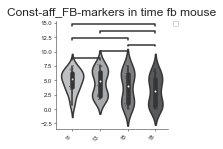

No handles with labels found to put in legend.


p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

wt v.s. ko: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.051e-02 U_stat=2.288e+03


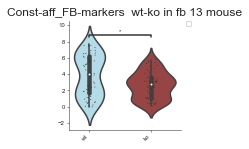

p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

fb v.s. mb: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.183e-08 U_stat=2.878e+03
mb v.s. hb: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.006e-04 U_stat=2.550e+03
hb v.s. sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.410e-01 U_stat=2.141e+03
fb v.s. hb: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.197e-14 U_stat=3.299e+03
mb v.s. sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.237e-06 U_stat=2.790e+03
fb v.s. sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.293e-15 U_stat=3.364e+03


No handles with labels found to put in legend.


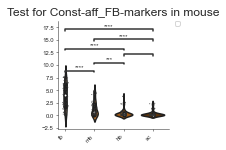

In [110]:
genes = ['Nr2e1', 'Fezf2', 'Helt', 'Gsx2', 'Emx1', 'Tfap2c', 'Fgf8', 'Eomes', 'Cldn4', 'Alx1'] 
human_gene_tst(df, genes, 'Const-aff_FB-markers_DFC', 'DFC', '')
mouse_gene_tst(df, genes, 'Const-aff_FB-markers', 'fb', '13')

['ENSG00000163501', 'ENSG00000233608', 'ENSG00000112333', 'ENSG00000170162', 'ENSG00000179855', 'ENSG00000115507', 'ENSG00000113196', 'ENSG00000188522', 'ENSG00000181885', 'ENSG00000064195', 'ENSG00000215644', 'ENSG00000176165', 'ENSG00000136352', 'ENSG00000198807', 'ENSG00000182107', 'ENSG00000183598', 'ENSG00000120149', 'ENSG00000164251', 'ENSG00000035499', 'ENSG00000153266', 'ENSG00000165588', 'ENSG00000158815', 'ENSG00000168135', 'ENSG00000169884', 'ENSG00000170421', 'ENSG00000111057', 'ENSG00000175643', 'ENSG00000145103', 'ENSG00000159263', 'ENSG00000184697', 'ENSG00000213937', 'ENSG00000162040', 'ENSG00000127588', 'ENSG00000143921', 'ENSG00000138083', 'ENSG00000170577', 'ENSG00000137090', 'ENSG00000095596', 'ENSG00000148704', 'ENSG00000168267', 'ENSG00000136535', 'ENSG00000144355', 'ENSG00000115844', 'ENSG00000052850', 'ENSG00000101311', 'ENSG00000125879', 'ENSG00000101057', 'ENSG00000132677', 'ENSG00000156150', 'ENSG00000178403', 'ENSG00000104413', 'ENSG00000178919', 'ENSG000001

No handles with labels found to put in legend.


W1 v.s. W4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.151e+04


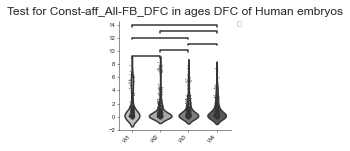

p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

DFC v.s. HIP: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.014e-05 U_stat=4.805e+05
HIP v.s. STR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.757e+05
STR v.s. CBC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.240e-02 U_stat=1.959e+05
DFC v.s. STR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.749e-03 U_stat=4.571e+05
HIP v.s. CBC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.292e-03 U_stat=2.173e+05


No handles with labels found to put in legend.


DFC v.s. CBC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.091e+05


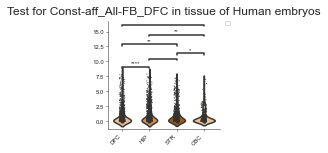

['external_gene_name', 'wt11fb1', 'wt11fb2', 'wt13fb1', 'wt13fb2', 'wt15fb1', 'wt15fb2', 'wt18fb1', 'wt18fb2']
p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

11 v.s. 13: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.765e-02 U_stat=3.298e+04
13 v.s. 15: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.209e-04 U_stat=3.515e+04
15 v.s. 18: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.078e-01 U_stat=3.292e+04


No handles with labels found to put in legend.


11 v.s. 15: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.246e-08 U_stat=3.835e+04
13 v.s. 18: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.886e-09 U_stat=3.861e+04
11 v.s. 18: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.888e-14 U_stat=4.141e+04


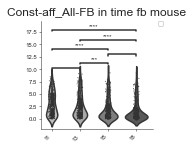

No handles with labels found to put in legend.


p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

wt v.s. ko: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.652e-09 U_stat=2.174e+05


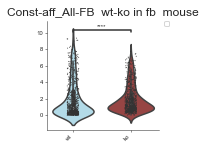

p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

fb v.s. mb: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.968e-10 U_stat=3.154e+05
mb v.s. hb: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.263e-14 U_stat=3.257e+05
hb v.s. sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.471e-01 U_stat=2.456e+05
fb v.s. hb: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.261e-41 U_stat=3.718e+05
mb v.s. sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.989e-07 U_stat=3.077e+05


No handles with labels found to put in legend.


fb v.s. sc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.504e-30 U_stat=3.560e+05


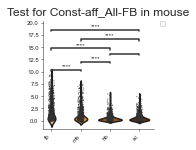

In [111]:
# Here we test the caff brain group (all genes)
genes = gene_sets[5]
human_gene_tst(df, genes, 'Const-aff_All-FB_DFC', 'DFC', '')
mouse_gene_tst(df, genes, 'Const-aff_All-FB', 'fb', '')

## Suppl Figure box plots for IB4 staining
| selection:   100 x 500 um                      | Huang       | Moments    | Moments    |           |                 |                 |
|------------------------------------------------|-------------|------------|------------|-----------|-----------------|-----------------|
| WT_E13,5                                       | DAPI um^3   | Sox2 um^3  | IB4 um^3   | Sox2/DAPI | IB4Moments/DAPI | IB4Moments/Sox2 |
| F168E3 Wt IB4 pH3 Sox DAPI s17 bPv   20x-1.tif | 230706480.0 | 57751064.0 | 25721550.0 | 0.250     | 0.111           | 0.445           |
| F168E3 Wt IB4 pH3 Sox DAPI s17aPva   20x-1.tif | 207328544.0 | 37618748.0 | 21857964.0 | 0.181     | 0.105           | 0.581           |
| F168E3 Wt IB4 pH3 Sox DAPI s17aPvb   20x-1.tif | 144466304.0 | 29460762.0 | 30978632.0 | 0.204     | 0.214           | 1.052           |
| F168E3 Wt IB4 pH3 Sox DAPI s17aRva   20x-1.tif | 215090096.0 | 55730028.0 | 27561110.0 | 0.259     | 0.128           | 0.495           |
| F168E3 Wt IB4 pH3 Sox DAPI s20Rva 20x.tif      | 192441056.0 | 53438428.0 | 22971328.0 | 0.278     | 0.119           | 0.430           |

| KO_E13,5                                      | DAPI um^3   | Sox2 um^3  | IB4 um^3   | Sox2/DAPI | IB4Moments/DAPI | IB4Moments/Sox2 |
|-----------------------------------------------|-------------|------------|------------|-----------|-----------------|-----------------|
| F167E5 KO IB4 pH3 Sox DAPI s18Lva   20x-1.tif | 230362656.0 | 23963010.0 | 44433460.0 | 0.104     | 0.193           | 1.854           |
| F167E5 KO IB4 pH3 Sox DAPI s18Rva 20x.tif     | 218045712.0 | 25660260.0 | 46617732.0 | 0.118     | 0.214           | 1.817           |
| F167E5 KO IB4 pH3 Sox DAPI s18Rvb 20x.tif     | 256518624.0 | 35614156.0 | 81238112.0 | 0.139     | 0.317           | 2.281           |
| F167E5 KO IB4 pH3 Sox DAPI s20Lva   20x-1.tif | 261038736.0 | 42595696.0 | 61291760.0 | 0.163     | 0.235           | 1.439           |
| F167E5 KO IB4 pH3 Sox DAPI s20Rva   20x-1.tif | 235437968.0 | 31517374.0 | 66306976.0 | 0.134     | 0.282           | 2.104           |

No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Eed-cKO: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.219e-02 U_stat=2.500e+01


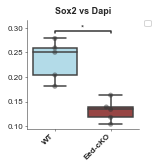

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Eed-cKO: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.780e-02 U_stat=1.500e+00


No handles with labels found to put in legend.


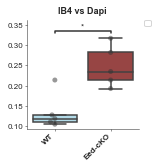

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Eed-cKO: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.219e-02 U_stat=0.000e+00


No handles with labels found to put in legend.


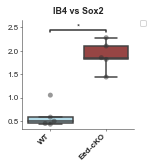

In [62]:
sox2_vs_dapi_wt = [0.250, 0.181, 0.204, 0.259, 0.278]
sox2_vs_dapi_ko = [0.104, 0.118, 0.139, 0.163, 0.134]

# IB4
ib4_vs_dapi_wt = [0.111, 0.105, 0.214, 0.128, 0.119]
ib4_vs_dapi_ko = [0.193, 0.214, 0.317, 0.235, 0.282]

# IB4 and Sox2
ib4_vs_sox2_wt = [0.445, 0.581, 1.052, 0.495, 0.430]
ib4_vs_sox2_ko = [1.854, 1.817, 2.281, 1.439, 2.104]

ib4_df = pd.DataFrame()
labels = []
values = []
for v in sox2_vs_dapi_wt:
    labels.append('WT')
    values.append(v)
for v in sox2_vs_dapi_ko:
    labels.append('Eed-cKO')
    values.append(v)
ib4_df['Label'] = labels
ib4_df['Ratio'] = values

boxplot = Boxplot(ib4_df, "Label", "Ratio", add_stats=True, title='Sox2 vs Dapi', add_dots=True, figsize=(2.0,2.0), 
                   order=['WT', 'Eed-cKO'], title_font_size=9, label_font_size=8)
boxplot.palette = [wt_colour, ko_colour]
boxplot.plot()
plt.savefig(f'{fig_dir}Sox2vsDapi.svg')
plt.show()

# Do the same for IB4
ib4_df = pd.DataFrame()
labels = []
values = []
for v in ib4_vs_dapi_wt:
    labels.append('WT')
    values.append(v)
for v in ib4_vs_dapi_ko:
    labels.append('Eed-cKO')
    values.append(v)
ib4_df['Label'] = labels
ib4_df['Ratio'] = values

boxplot = Boxplot(ib4_df, "Label", "Ratio", add_stats=True, title='IB4 vs Dapi', add_dots=True, figsize=(2.0,2.0), 
                   order=['WT', 'Eed-cKO'], title_font_size=9, label_font_size=8)
boxplot.palette = [wt_colour, ko_colour]
boxplot.plot()
plt.savefig(f'{fig_dir}IB4vsDapi.svg')
plt.show()

# Do the same for IB4 vs Docs2
ib4_df = pd.DataFrame()
labels = []
values = []
for v in ib4_vs_sox2_wt:
    labels.append('WT')
    values.append(v)
for v in ib4_vs_sox2_ko:
    labels.append('Eed-cKO')
    values.append(v)
ib4_df['Label'] = labels
ib4_df['Ratio'] = values

boxplot = Boxplot(ib4_df, "Label", "Ratio", add_stats=True, title='IB4 vs Sox2', add_dots=True, figsize=(2.0,2.0), 
                   order=['WT', 'Eed-cKO'], title_font_size=9, label_font_size=8)
boxplot.palette = [wt_colour, ko_colour]
boxplot.plot()
plt.savefig(f'{fig_dir}IB4vsSox2.svg')
plt.show()


## Get smallest distances between samples

### Suppl table 2

Here we want to print out the sample that has the smallest normalise SSQ difference between genes

In [63]:
wt_cols = [c for c in df.columns if 'wt' in c and 'merged' in c]
ko_cols = [c for c in df.columns if 'ko' in c and 'merged' in c]
ssq_dists = []
u.dp(["All difference:"])
for wc in ko_cols:
    smallest_diff = 10000000000
    mst_sim = None
    for kc in wt_cols:
        x_diff = np.sqrt(np.sum((df_all[wc].values - df_all[kc].values)**2, axis=0))
        print(f'{wc.split("_")[0]},{kc.split("_")[0]},{x_diff}')
        if x_diff < smallest_diff:
            smallest_diff = x_diff
            mst_sim = kc.split("_")[0]
            
### Now let's just print out the smalles t diff
u.dp(["Smallest difference:"])
for wc in ko_cols:
    smallest_diff = 10000000000
    mst_sim = None
    for kc in wt_cols:
        x_diff = np.sqrt(np.sum((df_all[wc].values - df_all[kc].values)**2, axis=0))
        if x_diff < smallest_diff:
            smallest_diff = x_diff
            mst_sim = kc.split("_")[0]
    print(f'{wc.split("_")[0]},{mst_sim},{smallest_diff}')


--------------------------------------------------------------------------------
                                All difference:	                                
--------------------------------------------------------------------------------
ko11fb,wt11fb,46.13041217141976
ko11fb,wt13fb,96.31498537846748
ko11fb,wt15fb,126.17521819740459
ko11fb,wt18fb,158.15170028653253
ko11fb,wt11mb,32.68888649920045
ko11fb,wt13mb,123.24215198500161
ko11fb,wt15mb,152.15502397144562
ko11fb,wt18mb,173.64756692424598
ko11fb,wt11hb,52.74528561931896
ko11fb,wt13hb,157.98424020311603
ko11fb,wt15hb,175.52118288533703
ko11fb,wt18hb,184.4663742350005
ko11fb,wt11sc,72.84236630973075
ko11fb,wt13sc,149.49809716892403
ko11fb,wt15sc,155.1793045187712
ko11fb,wt18sc,186.02043234719997
ko13fb,wt11fb,145.8941922169742
ko13fb,wt13fb,67.84849788293374
ko13fb,wt15fb,77.39694302354529
ko13fb,wt18fb,89.6881937422115
ko13fb,wt11mb,127.15664000179015
ko13fb,wt13mb,67.77767343459935
ko13fb,wt15mb,83.77920656498978
ko13fb,wt18m

## Print out the TF relationships



In [64]:
# Have a look at the TFs and their targets for regulons (i.e. does grp2 have TFs that tagret group3?)
regs = pd.read_csv(supp_dir + 'regulons_mm10_A-B.csv')
reg_tfs = set(regs['tf'].values)
group_labels = {1: 'Prolifferation', 2: 'Posterior', 3: 'Immune response', 4: 'Development', 5: 'Forebrain'}

for i in range(1, n_clusters):
    genes = df_training[gene_name].values[vae_set_idxs[i]]
    # Flag the TFs in this group, we'll then test these to see if we have lots of the targets in another group
    tfs = list(reg_tfs & set(genes)) 
    # Now we want to go through each of the other groups and record how many were targetted
    u.dp([group_labels[i], f'\n{len(tfs)} Tfs: ', ', '.join(tfs)])

    for j in range(1, n_clusters):
        genes_targets = df_training[gene_name].values[vae_set_idxs[j]]
        total_targets = 0
        for tf in tfs:
            targets = set(regs[regs['tf'] == tf]['target'].values)
            total_targets += len(list(targets & set(genes_targets)))
            if len(list(targets & set(genes_targets))) > 0:
                print(f'{tf} -->', ', '.join(list(targets & set(genes_targets))))
        print(f'--------------- Total for {group_labels[i]} targeting {group_labels[j]}: {total_targets} -------------')

        
#regs = pd.read_csv(supp_dir + 'regulons_mm10_A-B-C-D.csv')
regs[regs['tf'] == 'Cdkn1b'] #Tbx3, mesoderm markeds Hand1, gata2
#df_sig = pd.read_csv(f'{input_dir}df-significant_epi-2500_20210124.csv')
for g in regs[regs['target'] == 'Foxm1']['tf'].values:
    if len(df_training[df_training[gene_name] == g]) > 0:
        print(g, '\n')
        #print(df_sig[df_sig[gene_name] == g])


--------------------------------------------------------------------------------
       Prolifferation	
6 Tfs: 	Mybl2, Foxm1, Twist1, E2f1, Tal1, Tcf7l2	        
--------------------------------------------------------------------------------
Foxm1 --> Bmi1, Cdc25c, Ccnb1, Cenpa, Cenpf, Cdc6, Ccnd1, Aurkb
Twist1 --> Nr2f1
E2f1 --> Mybl2, Bmi1, Foxm1, Ect2, Ccnd1, Rrm2, Cdca7, Cdc45, Tgfb2, Uhrf1, Kif2c, Cdc6, Gmnn, Mcm10, Ccna2, Top2a
Tcf7l2 --> Ccnd1
--------------- Total for Prolifferation targeting Prolifferation: 26 -------------
E2f1 --> Pax2, Hoxb9
--------------- Total for Prolifferation targeting Posterior: 2 -------------
Foxm1 --> Cdc6, Cenpa, Cdc25c, Aurkb
E2f1 --> Slc14a2, Top2a, Ect2, Oca2, Sp110, Cdc45, Cdc6, Mcm10
Tal1 --> C3ar1
--------------- Total for Prolifferation targeting Immune response: 13 -------------
Foxm1 --> Cdkn1a
Twist1 --> Cdkn1a
E2f1 --> Pax2, Cdkn1a, Hoxb9
--------------- Total for Prolifferation targeting Development: 5 -------------
Twist1 --> Cldn7


# Print out all combinations of subset analyese


This is to give an idea of how many comparisons you would have to do if you were doing pairwise comparisons.

In [65]:

def combinations(arr):
     
    # number of arrays
    n = len(arr)
    all_conds = []
    # to keep track of next element 
    # in each of the n arrays
    indices = [0 for i in range(n)]
 
    while (1):
 
        # prcurrent combination
        cond_1 = ''
        for i in range(n):
            cond_1 += arr[i][indices[i]] + ' '
        all_conds.append(cond_1)
 
        # find the rightmost array that has more
        # elements left after the current element
        # in that array
        next = n - 1
        while (next >= 0 and
              (indices[next] + 1 >= len(arr[next]))):
            next-=1
 
        # no such array is found so no more
        # combinations left
        if (next < 0):
            break
 
        # if found move to next element in that
        # array
        indices[next] += 1
 
        # for all arrays to the right of this
        # array current index again points to
        # first element
        for i in range(next + 1, n):
            indices[i] = 0

    return all_conds


import itertools

fb = ['fb-up', 'fb-no-change', 'fb-down']
mb = ['mb-up', 'mb-no-change', 'mb-down']
hb = ['hb-up', 'hb-no-change', 'hb-down']
sc = ['sc-up', 'sc-no-change', 'sc-down']
time = ['11>e18', '11=e18', '11<18']
marked_10 = ['marked-e10', 'not-marked-10']
marked_16 = ['marked-e16', 'not-marked-16']
conds = [fb, sc, time, marked_10]
print(len(combinations([fb, sc, marked_10])))
print(len(combinations([fb, sc, time, marked_10])))
print(len(combinations([fb, sc, marked_10, marked_16])))
print(len(combinations([fb, sc, time, marked_10, marked_16])))
print(len(combinations([fb, mb, hb, sc, marked_10, marked_16])))
print(len(combinations([fb, mb, hb, sc, time, marked_10, marked_16])))

18
54
36
108
324
972


## Visualise VAE model against other models

Here we test other summary methods for gene separability.

In [66]:
import umap
import phate
from sklearn.manifold import TSNE


def get_shallow_vae(values, num_nodes, r_seed):
    config = {'loss': {'loss_type': 'mse', 'distance_metric': 'mmd', 'mmd_weight': 1.0},
              'encoding': {'layers': []},
              'decoding': {'layers': []},
              'latent': {'num_nodes': num_nodes}, 'optimiser': {'params': {}, 'name': 'adam'},
              'seed': r_seed}  # ensure there is a random seed just like in UMAP and TSNE

    vae_shallow = VAE(values, values, ['l']*len(values), config, f'vae_{num_nodes}')
    vae_shallow.encode('default', epochs=100, batch_size=50)
    # Encode the same using the linear vae
    vae_data_shallow = vae_shallow.encode_new_data(values)
    return vae_data_shallow, vae_shallow


def get_deep_vae(values, num_nodes, r_seed):
    config = {'loss': {'loss_type': 'mse', 'distance_metric': 'mmd', 'mmd_weight': 1.0,
                       'mmcd_method': 'k'},
              'encoding': {'layers': [{'num_nodes': 64, 'activation_fn': 'selu'},
                                      {'num_nodes': 32, 'activation_fn': 'relu'}
                                      ]},
              'decoding': {'layers': [
                  {'num_nodes': 32, 'activation_fn': 'relu'},
                  {'num_nodes': 64, 'activation_fn': 'selu'}]},
              'latent': {'num_nodes': num_nodes}, 'optimiser': {'params': {}, 'name': 'adam'},
              'seed': r_seed}

    vae_mse = VAE(values, values, ['l']*len(values), config, f'runs')
    vae_mse.encode('default', epochs=100, batch_size=50)
    vae_data = vae_mse.encode_new_data(values)
    return vae_data, vae_mse


vae_data_shallow = get_shallow_vae(vae_input_values, 3, 19)

fb_genes = ['Emx1', 'Eomes', 'Tbr1', 'Foxg1', 'Lhx6', 'Arx', 'Dlx1', 'Dlx2', 'Dlx5', 'Nr2e2', 'Otx2']
mb_genes = ['En1', 'En2', 'Lmx1a', 'Bhlhe23', 'Sall4']
hb_genes = ['Hoxb1', 'Krox20', 'Fev', 'Hoxd3', 'Phox2b']
sc_genes = ['Hoxd8', 'Hoxd9', 'Hoxd10', 'Hoxd11', 'Hoxd12', 'Hoxd13', 'Hoxa7', 'Hoxa9', 'Hoxa10', 'Hoxa11', 'Hoxa13',
            'Hoxb9', 'Hoxb13',  'Hoxc8', 'Hoxc9', 'Hoxc10', 'Hoxc11', 'Hoxc12', 'Hoxc13']

ns_glutamatergic = ['Slc17a6', 'VGLUT2', 'Slc17a7', 'VGLUT1', 'Slc17a8', 'VGLUT3', 'Slc1a1', 'Slc1a2', 'Slc1a6']
ns_progenitors = ['Sox2', 'Hes1', 'Hes5', 'Vim']
prolif_genes = ['Ccna1', 'Ccna2', 'Ccnd1', 'Ccnd2', 'Ccnd3', 'Ccne1', 'Ccne2', 'Cdc25a', 
'Cdc25b', 'Cdc25c', 'E2f1', 'E2f2', 'E2f3', 'Mcm10', 'Mcm5', 'Mcm3', 'Mcm2', 'Cip2a']

lc = [c for c in df.columns if 'log2FoldChange' in c] 
logfc_values = df[lc + ['H3K27me3']].values
data_tsne = TSNE(n_components=3).fit_transform(vae_input_values)

phate_op = phate.PHATE(n_components=3)
data_phate = phate_op.fit_transform(vae_input_values)
umap_e = umap.UMAP(n_components=3).fit_transform(vae_input_values)
pca_vae = PCA(n_components=3)
pca_values = pca_vae.fit_transform(vae_input_values)
data_m = {
    'VAE-deep': vae_data,
    'PCA': pca_values,
    'UMAP': umap_e,
    'PHATE': data_phate,
    'TSNE': data_tsne,
}



None
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
default_input (InputLayer)      [(None, 97)]         0                                            
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 3)            294         default_input[0][0]              
__________________________________________________________________________________________________
z_log_sigma (Dense)             (None, 3)            294         default_input[0][0]              
__________________________________________________________________________________________________
z (Lambda)                      (None, 3)            0           z_mean[0][0]                     
                                                                 z_log_sigma[0][0]     

24/24 [==============================] - 1s 14ms/step - loss: 7.7763 - val_loss: 6.0757
Epoch 2/100
24/24 [==============================] - 0s 2ms/step - loss: 4.3589 - val_loss: 3.9317
Epoch 3/100
24/24 [==============================] - 0s 2ms/step - loss: 2.8589 - val_loss: 2.3019
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - loss: 2.1269 - val_loss: 1.8683
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - loss: 1.8848 - val_loss: 1.6317
Epoch 6/100
24/24 [==============================] - 0s 2ms/step - loss: 1.6842 - val_loss: 1.4786
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - loss: 1.5565 - val_loss: 1.3690
Epoch 8/100
24/24 [==============================] - 0s 2ms/step - loss: 1.4288 - val_loss: 1.2781
Epoch 9/100
24/24 [==============================] - 0s 2ms/step - loss: 1.3668 - val_loss: 1.2646
Epoch 10/100
24/24 [==============================] - 0s 2ms/step - loss: 1.2938 - val_loss: 1.2104
Epoch 11/100
24/24 [

24/24 [==============================] - 0s 2ms/step - loss: 0.9943 - val_loss: 0.9470
Epoch 84/100
24/24 [==============================] - 0s 2ms/step - loss: 0.9885 - val_loss: 0.9085
Epoch 85/100
24/24 [==============================] - 0s 2ms/step - loss: 0.9879 - val_loss: 0.9059
Epoch 86/100
24/24 [==============================] - 0s 2ms/step - loss: 0.9858 - val_loss: 0.8944
Epoch 87/100
24/24 [==============================] - 0s 2ms/step - loss: 0.9864 - val_loss: 0.9286
Epoch 88/100
24/24 [==============================] - 0s 2ms/step - loss: 0.9888 - val_loss: 0.9322
Epoch 89/100
24/24 [==============================] - 0s 2ms/step - loss: 0.9810 - val_loss: 0.9544
Epoch 90/100
24/24 [==============================] - 0s 2ms/step - loss: 0.9879 - val_loss: 0.9294
Epoch 91/100
24/24 [==============================] - 0s 2ms/step - loss: 0.9738 - val_loss: 0.9553
Epoch 92/100
24/24 [==============================] - 0s 2ms/step - loss: 0.9963 - val_loss: 0.9527
Epoch 93/100


<Figure size 144x144 with 0 Axes>

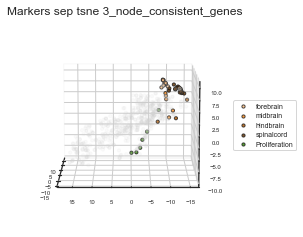

<Figure size 288x288 with 0 Axes>

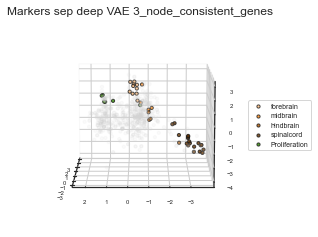

<Figure size 288x288 with 0 Axes>

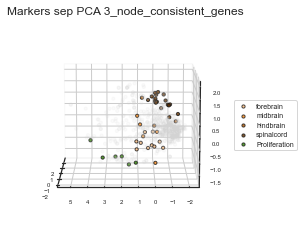

<Figure size 288x288 with 0 Axes>

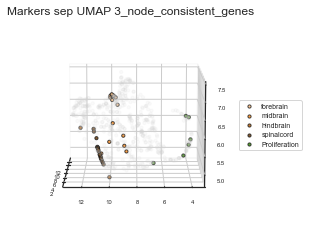

<Figure size 288x288 with 0 Axes>

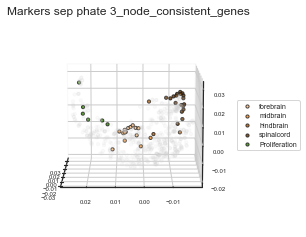

<Axes3DSubplot:title={'center':'Markers sep phate 3_node_consistent_genes'}>

<Figure size 288x288 with 0 Axes>

In [67]:
        
gene_markers_sep = [fb_genes, mb_genes, hb_genes, sc_genes, prolif_genes]
marker_labels_sep = ['forebrain', 'midbrain', 'hindbrain',  'spinalcord', 'Proliferation', ]

color_map = {}
i = 5
for c in marker_labels_sep:
    if 'brain' in c or 'spinal' in c:
        if 'spinal' in c:
            color_map[c] = sc_colour
        else:
            color_map[c] = get_tissue_colour(c.lower())
    else:
        color_map[c] = sci_colour[i]
    i += 1
    
    
angle = 180
vae_vis.plot_values_on_scatters(df_input, gene_name, marker_labels_sep,
                            gene_markers_sep, output_dir=fig_dir, vae_data=data_tsne, 
                            fig_type="svg",
                            title=f'Markers sep tsne {experiment_name}',
                            show_plt=True, save_fig=False, angle_plot=angle)

vae_vis.plot_values_on_scatters(df_input, gene_name, marker_labels_sep,
                            gene_markers_sep, output_dir=fig_dir, vae_data=vae_data, fig_type="svg",
                            title=f'Markers sep deep VAE {experiment_name}',
                            show_plt=True, save_fig=False, angle_plot=angle)

vae_vis.plot_values_on_scatters(df_input, gene_name, marker_labels_sep,
                            gene_markers_sep, output_dir=fig_dir, vae_data=pca_values, fig_type="svg",
                            title=f'Markers sep PCA {experiment_name}',
                            show_plt=True, save_fig=False, angle_plot=angle)

vae_vis.plot_values_on_scatters(df_input, gene_name, marker_labels_sep,
                            gene_markers_sep, output_dir=fig_dir, vae_data=umap_e, fig_type="svg",
                            title=f'Markers sep UMAP {experiment_name}',
                            show_plt=True, save_fig=False, angle_plot=angle)

vae_vis.plot_values_on_scatters(df_input, gene_name, marker_labels_sep,
                            gene_markers_sep, output_dir=fig_dir, vae_data=data_phate, 
                                fig_type="svg",
                            title=f'Markers sep phate {experiment_name}',
                            show_plt=True, save_fig=False, angle_plot=angle)


## Save the genes as ordered lists for functional gene set tests.

We'll test each for functional enrichment

In [68]:
data_m = {
    'VAE-deep': vae_data,
    'PCA': pca_values,
    'UMAP': umap_e,
    'PHATE': data_phate,
    'TSNE': data_tsne,
}
for label, data in data_m.items():
    for n in range(0, num_nodes):
        with open(f'{ora_dir}{label}-{n + 1}_{experiment_name}_{date}.csv', 'w+') as f:
            f.write(gene_id + ',value\n')
            desc_sorted = (data[:,n]).argsort()  # Sort the genes by descending order
            gene_names_sorted = df[gene_id].values[desc_sorted]
            vae_data_sorted = data[:,n][desc_sorted]
            for i, g in enumerate(gene_names_sorted):
                f.write(f'{g},{vae_data_sorted[i]}\n')
                
ora_dir

'../../data/results/3_node_consistent_genes/functional/'

## Save top 200 genes

In [69]:
n_genes = 200

def save_gene_order_lst(data, test_label):
    for n in range(0, num_nodes):
        with open(f'{ora_dir}{test_label}_{n}-max_cons-3_{date}.csv', 'w+') as f:
            f.write(gene_id + ',' + gene_name +  '\n')
            desc_sorted = (-data[:,n]).argsort()  # Sort the genes by descending order
            gene_names_sorted = df_training[gene_name].values[desc_sorted]
            gene_ids_sorted = df_training[gene_id].values[desc_sorted]
            for i in range(0, n_genes):
                f.write(f'{gene_ids_sorted[i]},{gene_names_sorted[i]}\n')

        with open(f'{ora_dir}{test_label}_{n}-min_cons-3_{date}.csv', 'w+') as f:
            f.write(gene_id + ',' + gene_name +  '\n')
            desc_sorted = (data[:,n]).argsort()  # Sort the genes by ascending order
            gene_names_sorted = df_training[gene_name].values[desc_sorted]
            gene_ids_sorted = df_training[gene_id].values[desc_sorted]
            for i in range(0, n_genes):
                f.write(f'{gene_ids_sorted[i]},{gene_names_sorted[i]}\n')

save_gene_order_lst(vae_data, 'VAE-deep')
save_gene_order_lst(pca_values, 'PCA')
save_gene_order_lst(umap_e, 'UMAP')
save_gene_order_lst(data_phate, 'PHATE')
save_gene_order_lst(data_tsne, 'TSNE')

GSEA-unadj_UMAP_UMAP2_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.15097727920349488	
--------------------------------------------------------------------------------


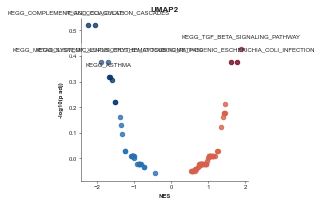

GSEA-unadj_VAE-lin_VAE-lin3_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.0073029814917566	
--------------------------------------------------------------------------------


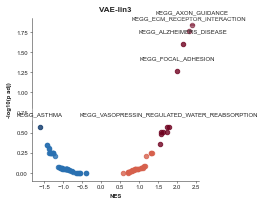

GSEA-unadj_PHATE_PHATE2_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.0013574947549179442	
--------------------------------------------------------------------------------


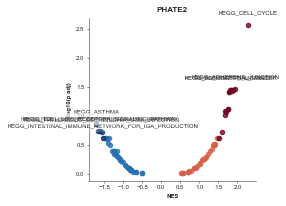

GSEA-unadj_PCA_PCA1_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.0012275564439229298	
--------------------------------------------------------------------------------


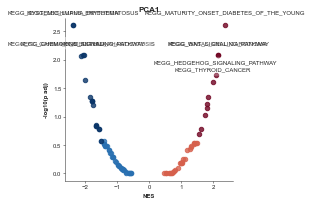

GSEA-unadj_VAE-lin_VAE-lin2_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.003342674193723028	
--------------------------------------------------------------------------------


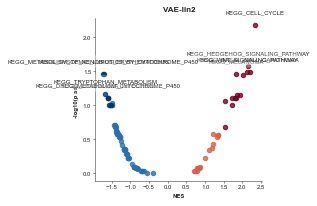

GSEA-unadj_TSNE_TSNE1_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.00030417610280376336	
--------------------------------------------------------------------------------


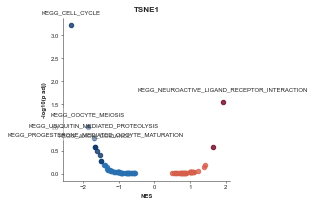

GSEA-unadj_UMAP_UMAP3_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.14212056037060242	
--------------------------------------------------------------------------------


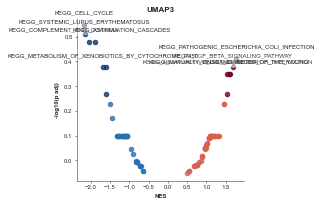

GSEA-unadj_PHATE_PHATE3_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.03309775177112748	
--------------------------------------------------------------------------------


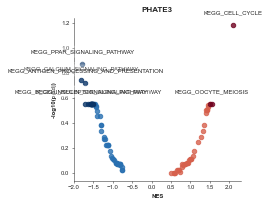

GSEA-unadj_VAE-lin_VAE-lin1_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.00023870955294919864	
--------------------------------------------------------------------------------


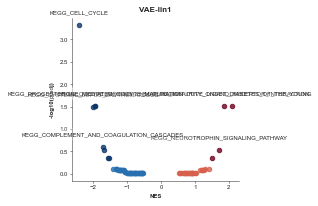

GSEA-unadj_TSNE_TSNE2_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.009544807712405259	
--------------------------------------------------------------------------------


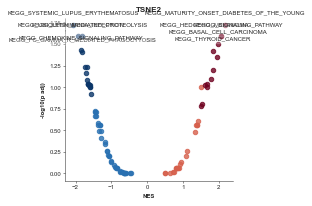

GSEA-unadj_PCA_PCA3_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.0061766083071522785	
--------------------------------------------------------------------------------


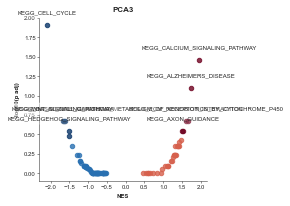

GSEA-unadj_TSNE_TSNE3_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.008438354355644731	
--------------------------------------------------------------------------------


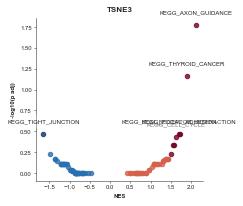

GSEA-unadj_UMAP_UMAP1_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.001873590815145135	
--------------------------------------------------------------------------------


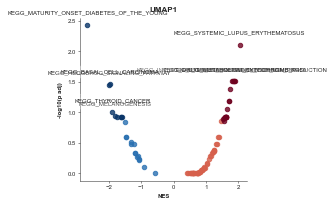

GSEA-unadj_PCA_PCA2_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.0046963770076152685	
--------------------------------------------------------------------------------


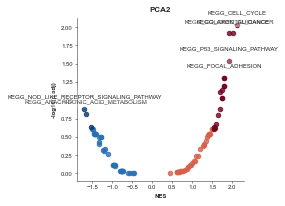

GSEA-unadj_PHATE_PHATE1_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.002077456888684494	
--------------------------------------------------------------------------------


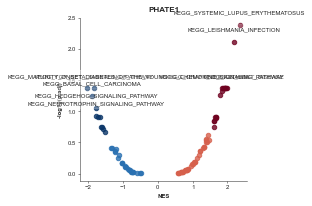

In [71]:
gsea_dir = '../../figures/3_node_consistent_genes/gsea/'
for f in os.listdir(gsea_dir):
    if 'GSEA' in f and 'KEGG' in f and 'Cluster' not in f:
        gsea_out = pd.read_csv(gsea_dir + f)
        print(f)
        volcanoplot = Volcanoplot(gsea_out, 'NES', 'padj', 'pathway', 
                                      f.split("_")[2], 'NES', '-log10(p adj)', 
                                      p_val_cutoff=1.0, max_labels=5,
                                      label_big_sig=True, log_fc_cuttoff=1.5, figsize=(2.0,2.0))
        sns.set_style("ticks")
        volcanoplot.plot()
        save_fig(f'Volcano_gsea_{f.split("_")[2]}')
        plt.show()

GSEA-unadj_UMAP_UMAP2_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.15097727920349488	
--------------------------------------------------------------------------------


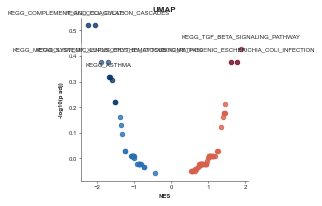

GSEA-unadj_VAE-lin_VAE-lin3_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.0073029814917566	
--------------------------------------------------------------------------------


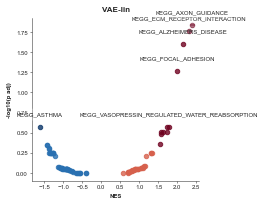

GSEA-unadj_PHATE_PHATE2_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.0013574947549179442	
--------------------------------------------------------------------------------


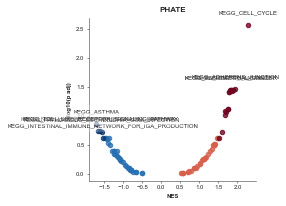

GSEA-unadj_PCA_PCA1_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.0012275564439229298	
--------------------------------------------------------------------------------


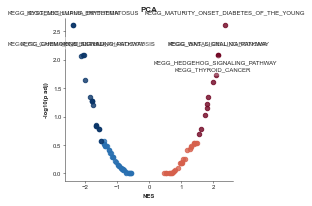

GSEA-unadj_Cluster2_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.01029582635077173	
--------------------------------------------------------------------------------


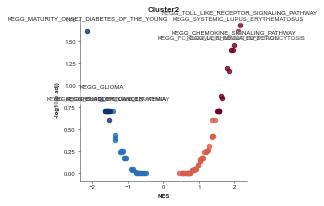

GSEA-unadj_VAE-lin_VAE-lin2_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.003342674193723028	
--------------------------------------------------------------------------------


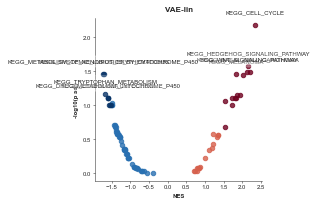

GSEA-unadj_TSNE_TSNE1_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.00030417610280376336	
--------------------------------------------------------------------------------


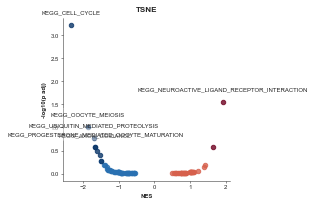

GSEA-unadj_UMAP_UMAP3_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.14212056037060242	
--------------------------------------------------------------------------------


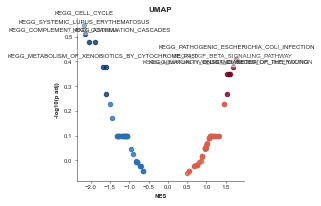

GSEA-unadj_PHATE_PHATE3_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.03309775177112748	
--------------------------------------------------------------------------------


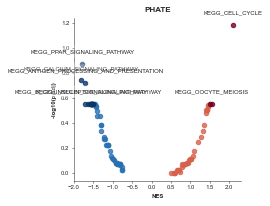

GSEA-unadj_Cluster3_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.0022298143204143197	
--------------------------------------------------------------------------------


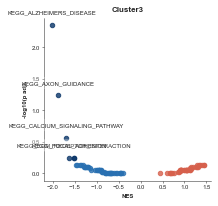

GSEA-unadj_VAE-lin_VAE-lin1_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.00023870955294919864	
--------------------------------------------------------------------------------


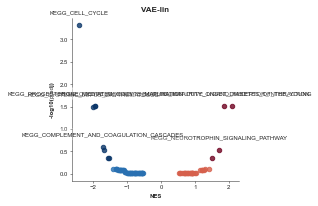

GSEA-unadj_TSNE_TSNE2_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.009544807712405259	
--------------------------------------------------------------------------------


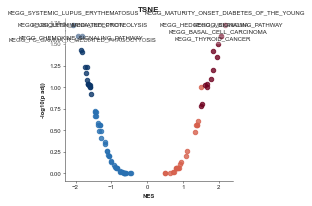

GSEA-unadj_PCA_PCA3_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.0061766083071522785	
--------------------------------------------------------------------------------


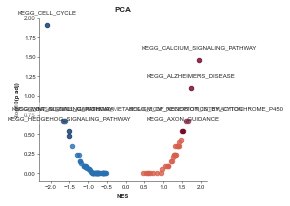

GSEA-unadj_TSNE_TSNE3_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.008438354355644731	
--------------------------------------------------------------------------------


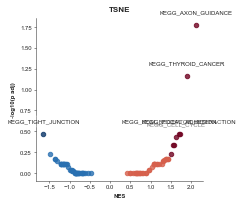

GSEA-unadj_UMAP_UMAP1_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.001873590815145135	
--------------------------------------------------------------------------------


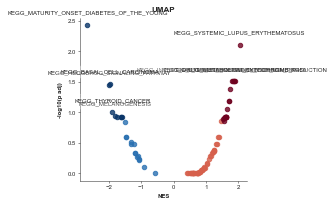

GSEA-unadj_Cluster1_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.01027047415281673	
--------------------------------------------------------------------------------


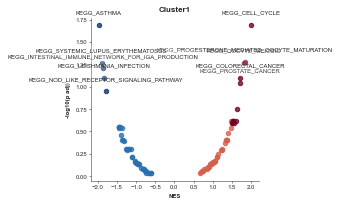

GSEA-unadj_PCA_PCA2_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.0046963770076152685	
--------------------------------------------------------------------------------


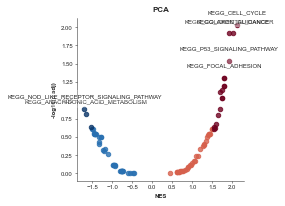

GSEA-unadj_PHATE_PHATE1_KEGG_.csv
--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	0.002077456888684494	
--------------------------------------------------------------------------------


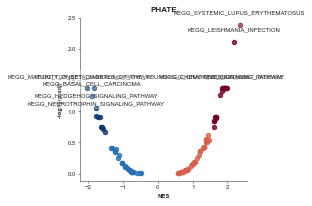

In [72]:
gsea_dir = '../../figures/3_node_consistent_genes/gsea/'
for f in os.listdir(gsea_dir):
    if 'GSEA' in f and 'KEGG' in f:
        gsea_out = pd.read_csv(gsea_dir + f)
        print(f)
        volcanoplot = Volcanoplot(gsea_out, 'NES', 'padj', 'pathway', 
                                      f.split("_")[1], 'NES', '-log10(p adj)', 
                                      p_val_cutoff=1.0, max_labels=5,
                                      label_big_sig=True, log_fc_cuttoff=1.5, figsize=(2.0,2.0))
        sns.set_style("ticks")
        volcanoplot.plot()
        save_fig(f'Volcano_gsea_{f.split("_")[1]}_{f.split("_")[2]}')
        plt.show()

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	5.241935483870968e-09	
--------------------------------------------------------------------------------


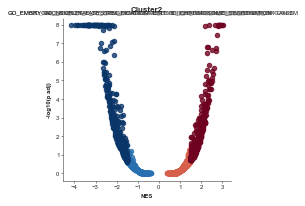

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	4.2453142857245726e-07	
--------------------------------------------------------------------------------


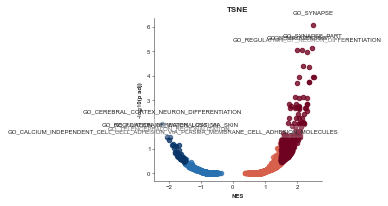

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	1.9117647058823533e-08	
--------------------------------------------------------------------------------


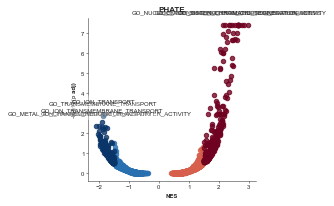

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	6.5e-09	
--------------------------------------------------------------------------------


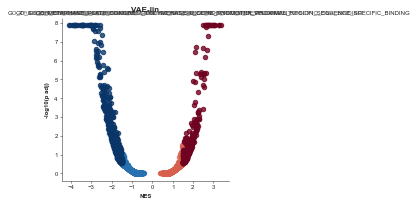

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	1.4130434782608697e-08	
--------------------------------------------------------------------------------


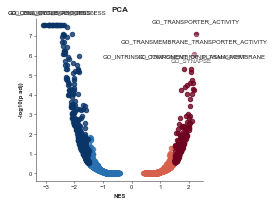

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	8.333333333333334e-09	
--------------------------------------------------------------------------------


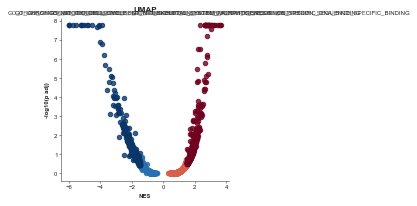

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	1.0833333333333331e-08	
--------------------------------------------------------------------------------


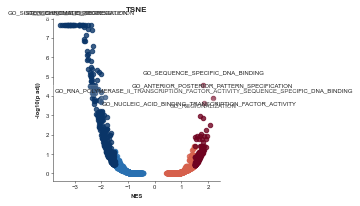

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	5.803571428571429e-09	
--------------------------------------------------------------------------------


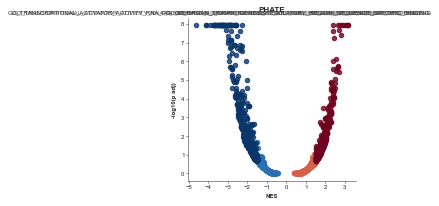

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	4.391891891891892e-09	
--------------------------------------------------------------------------------


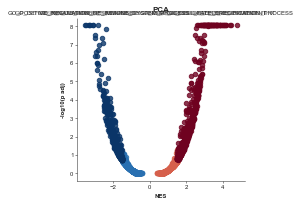

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	1.510389811771658e-07	
--------------------------------------------------------------------------------


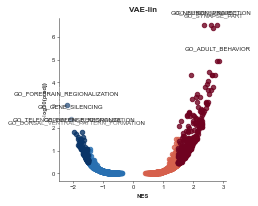

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	1.6778947368421054e-08	
--------------------------------------------------------------------------------


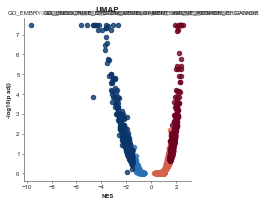

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	2.1666666666666662e-08	
--------------------------------------------------------------------------------


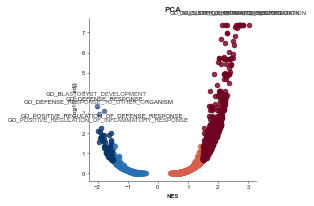

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	1.8822114807424444e-08	
--------------------------------------------------------------------------------


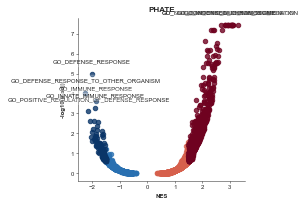

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	1.6154999999999998e-08	
--------------------------------------------------------------------------------


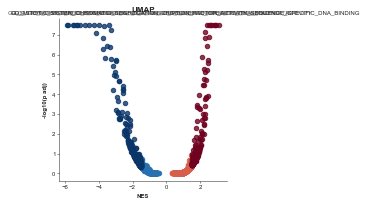

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	9.225501255587968e-07	
--------------------------------------------------------------------------------


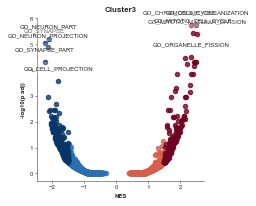

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	3.91566265060241e-09	
--------------------------------------------------------------------------------


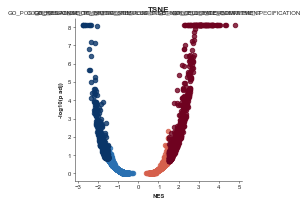

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	9.742424242424242e-09	
--------------------------------------------------------------------------------


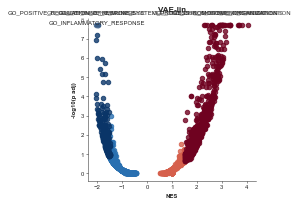

--------------------------------------------------------------------------------
No offset was provided, setting offset to be smallest value recorded in dataset: 	1.4130434782608697e-08	
--------------------------------------------------------------------------------


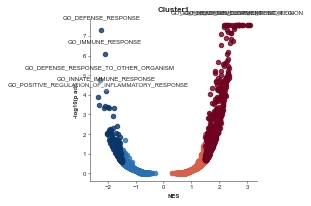

In [73]:
def save_fig(title, ending='.svg'):
    plt.savefig(f'{fig_dir}{title.replace(" ", "-")}{ending}')
    
for f in os.listdir(gsea_dir):
    if 'Go' in f and 'svg' not in f:
        gsea_out = pd.read_csv(gsea_dir + f)
        gsea_out = gsea_out.fillna(1.0)
        volcanoplot = Volcanoplot(gsea_out, 'NES', 'padj', 'pathway', 
                                      f.split("_")[1], 'NES', '-log10(p adj)', 
                                      p_val_cutoff=1.0, max_labels=5,
                                      label_big_sig=True, log_fc_cuttoff=1.5, figsize=(2,2))
        sns.set_style("ticks")
        volcanoplot.plot()
        save_fig(f'Volcano_gsea_GO_{f.split("_")[1]}_{f.split("_")[2]}', ending='.pdf' )
        plt.show()